In [1]:
import argparse
import datetime as dte
import os

import data_formatters.base
import expt_settings.configs

import libs.hyperparam_opt
import libs.tft_model
import libs.utils as utils
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)

ExperimentConfig = expt_settings.configs.ExperimentConfig
HyperparamOptManager = libs.hyperparam_opt.HyperparamOptManager
ModelClass = libs.tft_model.TemporalFusionTransformer
tf.experimental.output_all_intermediates(True)

name, output_folder, use_tensorflow_with_gpu =  'op', '/gpfs/data/fs71801/lkapral66/tft', 'yes'

print("Using output folder {}".format(output_folder))

config = ExperimentConfig(name, output_folder)
formatter = config.make_data_formatter()



expt_name=name
use_gpu=use_tensorflow_with_gpu
model_folder=os.path.join(config.model_folder, "op/tmp")
data_csv_path=config.data_csv_path
data_formatter=formatter
use_testing_mode=False



if not isinstance(data_formatter, data_formatters.base.GenericDataFormatter):
    raise ValueError(
        "Data formatters should inherit from" +
        "AbstractDataFormatter! Type={}".format(type(data_formatter)))

# Tensorflow setup
default_keras_session = tf.compat.v1.keras.backend.get_session()

if use_gpu:
    tf_config = utils.get_default_tensorflow_config(tf_device="gpu")


else:
    tf_config = utils.get_default_tensorflow_config(tf_device="cpu")

print("*** Training from defined parameters for {} ***".format(expt_name))

print("Loading & splitting data...")
raw_data_vienna = pd.read_parquet(data_csv_path)
train, valid, test = data_formatter.split_data(raw_data_vienna)
train_samples, valid_samples = data_formatter.get_num_samples_for_calibration()




# Sets up default params


param_ranges = ModelClass.get_hyperparm_choices()

fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()
params["model_folder"] = model_folder


print("*** Loading hyperparm manager ***")
opt_manager = HyperparamOptManager({k: [params[k]] for k in params},
                                   fixed_params, model_folder)

# Training -- one iteration only
print("*** Running calibration ***")
print("Params Selected:")
for k in params:
    print("{}: {}".format(k, params[k]))
    




/home/fs71801/lkapral66/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Using output folder /gpfs/data/fs71801/lkapral66/tft



2023-11-12 18:18:04.119760: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 18:18:07.372278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


Selecting GPU ID=0
*** Training from defined parameters for op ***
Loading & splitting data...
Formatting train-valid-test splits.
Setting scalers with training data...
gender
asa_score
urgency
surgery_type
invasivebp
ventmode
phase
gender
asa_score
urgency
surgery_type
invasivebp
ventmode
phase
gender
asa_score
urgency
surgery_type
invasivebp
ventmode
phase
*** Loading hyperparm manager ***
*** Running calibration ***
Params Selected:
dropout_rate: 0.3
hidden_layer_size: 240
learning_rate: 0.0002
minibatch_size: 128
max_gradient_norm: 100.0
num_heads: 32
stack_size: 1
model_folder: /gpfs/data/fs71801/lkapral66/tft/saved_models/op/op/tmp


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def replace_task(df, columnn, old, new):
    return df[columnn].replace(old, new, regex=True)

def replace_string_data(df,  replace_data):
    for i, (column, old, new) in enumerate(replace_data):
        print(column)
        print(old)
        print(new)
        df[column] = replace_task(df, column, old, new)
    return df 


In [5]:
def detect_changes(series, threshold):
    """
    Detects abrupt changes in a series that might indicate the start of a forward-filled sequence.

    Args:
    series (pd.Series): The data series to analyze.
    threshold (float): The threshold for detecting a change. This will depend on the nature of your data.

    Returns:
    list: Indices where changes were detected.
    """
    indices = []
    for i in range(1, len(series)):
        if abs(series[i] - series[i-1]) < threshold:
            indices.append(i)
    return indices

In [6]:
all = ['rand_id', 'case_time', 'age', 'gender', 'asa_score', 'urgency',
       'surgery_type', 'hf', 'pulse', 'spo2', 'etco2', 'systolicbp',
       'diastolicbp', 'meanbp', 'invasivebp', 'insevo', 'exsevo', 'indes',
       'exdes', 'berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil', 'compliance', 'fio2', 'peep', 'plateau', 'pmax', 'ppeak',
       'pmean', 'resistance', 'ventfreq', 'ventmode', 'vt',
       'dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor',
       'phase', 'hypotension60', 'hypotension65',  'hypoxemia']

raw_data_kor = pd.read_parquet('/gpfs/data/fs71801/lkapral66/exportVitalDB_all_V2.parquet')


# Replace the detected changes with NaN
change_indices = detect_changes(raw_data_kor['meanbp'], threshold=0.5)
for idx in change_indices:
    raw_data_kor.at[idx, 'meanbp'] = np.nan

# Now, you can interpolate
raw_data_kor['meanbp'] = raw_data_kor['meanbp'].interpolate(method='linear').round()

df_kor = raw_data_kor
replace_data_kor = [ [['invasivebp'],[ 'NIBP', 'ART'], [False,True]], [['hypotension60'],[ 0, 1], [False,True]], [['hypotension65'],[ 0, 1], [False,True]], [['hypoxemia'],[ 0, 1], [False,True]]]

df_kor['case_time'] = df_kor['case_time'].dt.hour * 3600 + df_kor['case_time'].dt.minute * 60 + df_kor['case_time'].dt.second
df_kor[['berodual', 'cisatracurium', 'esketamin', 'etomidat', 'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid', 'propofol', 'remifentanil', 'rocuronium', 'succinylcholin', 'sufentanil', 'pmax', 'resistance', 'ventfreq', 'ventmode', 'vt', 'dobutamin_perfusor', 'levosimendan_perfusor', 'sufentanil_perfusor']]=0.

df_kor = df_kor[df_kor['asa_score'].isin([1,2,3,4,5])]
df_kor = df_kor.loc[df_kor['surgery_type']!=16,:]
df_kor = df_kor[all]




df_kor.replace([np.inf, -np.inf], np.finfo(np.float32).max, inplace=True)

# Step 1: Identify columns with non-finite values
columns_with_non_finite = df_kor.columns[df_kor.isin([np.nan, np.inf, -np.inf]).any()]

# Step 2: Handle non-finite values (e.g., replace with 0)
df_kor[columns_with_non_finite] = df_kor[columns_with_non_finite].fillna(0)

# Step 3: Convert columns to integer dtype
for column in columns_with_non_finite:
    df_kor[column] = df_kor[column].astype(int)

df_kor = replace_string_data(df_kor, replace_data_kor)


for column in raw_data_vienna.columns:
    if column in df_kor.columns:
        df_kor[column] = df_kor[column].astype(raw_data_vienna[column].dtype)



numeric_columns = df_kor.select_dtypes(include=[np.number])
df_kor[numeric_columns.columns] = numeric_columns.fillna(method='ffill').fillna(0.0)

train_kor = data_formatter.transform_inputs(df_kor)

['invasivebp']
['NIBP', 'ART']
[False, True]
['hypotension60']
[0, 1]
[False, True]
['hypotension65']
[0, 1]
[False, True]
['hypoxemia']
[0, 1]
[False, True]


/tmp/ipykernel_1241612/1323321912.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_kor[numeric_columns.columns] = numeric_columns.fillna(method='ffill').fillna(0.0)


gender
asa_score
urgency
surgery_type
invasivebp
ventmode
phase


In [7]:
df_kor['meanbp'].head(120)

0       0
1       0
2       0
3       0
4       0
       ..
115    68
116    68
117    67
118    66
119    65
Name: meanbp, Length: 120, dtype: int64

In [8]:
tf.compat.v1.reset_default_graph()
tf.Graph().as_default()
tf.compat.v1.disable_eager_execution()

params = opt_manager.get_next_parameters()
model = ModelClass(params, use_cudnn=use_gpu)



Resetting temp folder...
*** TemporalFusionTransformer params ***
# dropout_rate = 0.3
# hidden_layer_size = 240
# learning_rate = 0.0002
# max_gradient_norm = 100.0
# minibatch_size = 128
# model_folder = /gpfs/data/fs71801/lkapral66/tft/saved_models/op/op/tmp
# num_heads = 32
# stack_size = 1
# total_time_steps = 62
# num_encoder_steps = 32
# num_epochs = 10
# early_stopping_patience = 10
# multiprocessing_workers = 128
# column_definition = [('rand_id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('case_time', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('case_time', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('age', <DataTypes.REAL_VALUED: 0>, <InputTypes.STATIC_INPUT: 3>), ('hf', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('pulse', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('spo2', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('etco2', <DataTypes.REAL_VALUED: 0>, <InputTypes.OBSERVED_INPUT: 1>), ('syst

2023-11-12 18:22:10.587167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


known_regular_inputs
[<tf.Tensor 'TemporalFusionTransformer/time_distributed_45/Reshape_1:0' shape=(None, 62, 240) dtype=float32>]
known_categorical_inputs
[]
Sum
[<tf.Tensor 'TemporalFusionTransformer/time_distributed_45/Reshape_1:0' shape=(None, 62, 240) dtype=float32>]



In [9]:
model.model.load_weights(opt_manager.hyperparam_folder+'/TemporalFusionTransformer.check')

In [10]:
#logdir = "/home/fs71801/lkapral66/Transformer/tft_tf2/tft_outputs/saved_models/op/new_test/tmp"

In [11]:
#plot_patient_value_points(test, raw_data, 14, model, ['meanbp'], [], data_formatter,  window_length=28, prediction_points=[10,30,50,80, 100])

In [12]:
"""
BP:  Vergangenheit 10 min in Zufunft: 7 min
    
Bronichispasm: Vergangenheit 10 min in Zufunft: 5 min
    
Hypoxemia: Vergangenheit 10 min in Zufunft: 7 min
"""

'\nBP:  Vergangenheit 10 min in Zufunft: 7 min\n    \nBronichispasm: Vergangenheit 10 min in Zufunft: 5 min\n    \nHypoxemia: Vergangenheit 10 min in Zufunft: 7 min\n'

In [13]:
#_(dropoutrate)_(earlystopping_patience)_(hiddenlayer_size)_[??]_InputSize_[0, 1, 2, 3]_[0, 1]_(LR)_(max_gradient_norm)_(minibatch_size)
#main_(mini_batchsize)_(num_encoder_steps)_(num_epochs)_(num_heads)_(stack_size)

In [14]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [15]:
def calc_hypotension_prob(p10,p50,p90, threshold):
    if(p90<threshold):
        return 0.9
    if(p90>threshold and p50<threshold):
        return translate(threshold, p50, p90, 0.5, 0.9)
    if(p50>threshold and p10<threshold):
        return translate(threshold, p10, p50, 0.1, 0.5)
    if(p10>threshold):
        return 0.1
    

In [16]:
def calc_AUT(p50, threshold):
    amount = 0
    max_loc = -1
    highest_amount = 0
    
    for value in p50.values:

        if(value<threshold):
            amount =+ abs(value-threshold)
            if(amount > highest_amount):
                highest_amount = amount
                max_loc = i
    
    
    
    return amount, max_loc

In [17]:
def calc_TWA(p50, threshold):
    amount = 0
    max_loc = -1
    highest_amount = 0
    

    for value in p50.values:

        if(value<threshold):
            amount =+ abs(value-threshold)
            if(amount > highest_amount):
                highest_amount = amount
                max_loc = i
    
    
    
    return amount/4./7., max_loc

In [18]:
def calc_hypotension_1_3_5_7(p50):
    return p50['t+4']<65., p50['t+12']<65., p50['t+20']<65., p50['t+28']<65.
    

In [19]:
def add_metric(predict, truth, TP, FP, TN, FN):
    for i in range(len(predict)):
        
        if(predict[i] and truth[i]):
            TP[i] += 1
        if(predict[i] and not truth[i]):
            FP[i] += 1
        if(not predict[i] and not truth[i]):
            TN[i] += 1
        if(not predict[i] and truth[i]):     
            FN[i] += 1

    return TP, FP, TN, FN
            
    
        

In [20]:
def binary_evaluation(p50, data, hist_length, window_length):
    TP = [0,0,0,0]
    FP = [0,0,0,0]
    TN = [0,0,0,0]
    FN = [0,0,0,0]
    for i in range(predict_p50.shape[0]):
        
        predict = calc_hypotension_1_3_5_7(predict_p50.iloc[i])
        truth = tuple(data['meanbp'].iloc[[hist_length+i+3,hist_length+i+11,hist_length+i+19,hist_length+i+27]].values<65.)

        TP, FP, TN, FN = add_metric(predict, truth, TP, FP, TN, FN)
        
    return TP, FP, TN, FN

In [21]:
def calc_rate(TP, FP, TN, FN):
    
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [22]:
def calc_sensitivity_specificity(TP, FP, TN, FN):
    
    sens =  TP/(TP + FN) # sensitivity - true positive rate
    spec = TN/(TN+FP) # 1-specificity - false positive rate

    return sens, spec

In [23]:
from scipy.stats import norm

def estimate_probability(q10, q50, q90, threshold):
    # estimate parameters of the normal distribution
    
    mu = q50
    sigma = (q90 - q10) / (2 * 1.28)

    # The CDF gives the probability that a random variable is less than or equal to the threshold
    probability = norm.cdf(threshold, loc=mu, scale=sigma)

    return probability

In [24]:
def estimate_probability_timestep(q10, q50, q90, threshold, timestep):
    # estimate parameters of the normal distribution

    
    time = 't+'+str(timestep)
    
    mu = q50[time]
    sigma = (q90[time] - q10[time]) / (2 * 1.28)

    # The CDF gives the probability that a random variable is less than or equal to the threshold
    probability = norm.cdf(threshold, loc=mu, scale=sigma)
    
    
    return probability

In [25]:
import numpy as np
import scipy.stats as stats

def estimate_probability_timestep_log(q10, q50, q90, threshold, timestep):
    # estimate parameters of the normal distribution

    
    time = 't+'+str(timestep)
    
    array = np.array([q10[time],q50[time],q90[time]])  # 10th percentile
    
    probs = []
    for p in array.T:
        p10 = p[0]
        p50 = p[1]
        p90 = p[2]
        
        mu = np.log(p50)
        sigma = (np.log(p90) - np.log(p10)) / (2 * 1.28)

        # The CDF gives the probability that a random variable is less than or equal to the threshold
        s, loc, scale = stats.lognorm.fit([p10, p50, p90], loc=mu, scale=sigma) 

        dist = stats.lognorm(s=s, loc=loc, scale=scale)


        # Compute probability that a value is under the threshold
        probs.append(dist.cdf(threshold))

    
    return probs

In [26]:
kor = False
if(kor):
    df = train_kor
    raw_data = df_kor
else:

    df = test
    raw_data = raw_data_vienna

In [27]:
raw_data.loc[raw_data['invasivebp']==1,['meanbp','invasivebp']]

meanbp  invasivebp
1379           0           1
1381         128           1
1382          69           1
1383          66           1
1384          70           1
...          ...         ...
40602833     100           1
40602834     113           1
40602835     135           1
40602836     111           1
40602837     116           1

[13850251 rows x 2 columns]

In [28]:
# %matplotlib widget
# import seaborn as sns
# from ipywidgets import *
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.colors as mcolors
# import data_formatters.base
# from sklearn.metrics import mean_squared_error
# # Default input types.

# sns.set_style("whitegrid")
# patient_nr = 5


# model = model
# column = 'meanbp'
# data_formatter = data_formatter
# window_length = 30
# hist_length = 32
# from IPython.display import clear_output

# pred_col_names = []
# for i in range(window_length):
#     print()
#     pred_col_names.append('t+'+str(i))

    
# fig = figure(figsize=(8, 8))
# ((graph1, graph4), (graph2, graph3), (graph6, graph5)) = fig.subplots(nrows=3, ncols=2)




# InputTypes = data_formatters.base.InputTypes
# observed_list = []
# static_list = []
# for ele in model.column_definition:
#     if(ele[2]==InputTypes.OBSERVED_INPUT):
#         observed_list.append(ele[0])
#     if(ele[2]==InputTypes.STATIC_INPUT):
#         static_list.append(ele[0])

# for ele in model.column_definition:
#     if(ele[2]==InputTypes.KNOWN_INPUT):
#         observed_list.append(ele[0])
        
# for ele in model.column_definition:
#     if(ele[2]==InputTypes.TARGET):
#         observed_list.append(ele[0])



    

# indices = df['rand_id'].unique()
# pat_id = indices[patient_nr]

# df_pat = df[df['rand_id']==pat_id]
# raw_pat = raw_data[raw_data['rand_id']==pat_id]

# output_map = model.predict(df_pat)
# attention = model.get_attention(df_pat)


# predict_p10 = data_formatter.format_predictions(output_map["p10"])
# predict_p50 = data_formatter.format_predictions(output_map["p50"])
# predict_p90 = data_formatter.format_predictions(output_map["p90"])

# df_reset = raw_pat.reset_index()

# df_meds = df_reset
# input_interact = []
# for i, col in enumerate(df_meds.columns):
    
#     input_interact.append((col, i))
#     try:
#         df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
#     except:
#         pass

    

    
    
    
# predict_p10 = predict_p10[pred_col_names]
# predict_p50 = predict_p50[pred_col_names]
# predict_p90 = predict_p90[pred_col_names]

# targets = raw_pat['meanbp']

# x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)
# x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

# len_pred = len(predict_p10.iloc[0])

# print(len_pred)
# x_axis_pred = np.arange(0, len_pred)
# plot_error = []

# for x in range(len(raw_pat)-(window_length+hist_length)):
#     plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))


# def update_pred(time, variable_int):
#     time = int(time*4.)
#     graph1.clear()
#     graph2.clear()
#     graph3.clear()
#     graph4.clear()
#     graph5.clear()
#     graph6.clear()

#     graph1.plot(x_axis/4., targets, label='Mean blood pressure')

#     x_axis_pred = np.arange(time, time + len_pred)
#     x_axis_attention = np.arange(time-hist_length, time)
#     x_axis_self_attention = np.arange(time-hist_length, time+window_length)

    
    
#     graph1.plot(x_axis_pred/4., predict_p50.iloc[time], color='g')

#     graph6.plot(x_axis_error/4., plot_error)

#     mean_p10 = np.min(predict_p10.loc[time, predict_p10.columns])
#     mean_p50 = np.min(predict_p50.loc[time, predict_p50.columns])
#     mean_p90 = np.min(predict_p90.loc[time, predict_p90.columns])

#     TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
#     TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
#     TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
    
#     proba = estimate_probability(predict_p10.loc[time, predict_p10.columns], predict_p50.loc[time, predict_p50.columns], predict_p90.loc[time, predict_p90.columns], 65. )
    
#     print(np.max(proba), 15*(np.argmax(proba))/60)
    
#     graph1.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center', transform=graph1.transAxes)
    
#     fig.canvas.draw_idle()
#     observered_var = df_meds.columns[variable_int]
#     index_observed = -1
#     index_static = -1
#     try:
#         index_observed = observed_list.index(observered_var)
#     except:
#         pass
    
#     if(index_observed>=0):
#         graph3.plot(x_axis_attention/4., attention['historical_flags'][time,:,index_observed], color= "purple")
        
#         graph3.axhline(y = attention['historical_flags'][:,:,index_observed].mean(), color = 'black', linestyle=":")
#         graph3.legend([observered_var, 'mean'])
#         graph3.set_ylim([ attention['historical_flags'][:,:,index_observed].min(),attention['historical_flags'][:,:,index_observed].max()])

     
#     try:
#         index_static = static_list.index(observered_var)
#     except:
#         pass
#     if(index_static>=0):
#         graph3.scatter(time, attention['static_flags'][time,index_static], color= "purple")

#         graph3.legend([str(attention['static_flags'][:,index_static].mean())])

    
#     graph5.plot(x_axis_self_attention/4., attention['decoder_self_attn'][:,time,hist_length+window_length-1,:].mean(axis = 0))

#     graph5.set_ylim([0,0.25])

    

#     #graph5.axvline(x = (time-31+attention_time)/4., color = 'red', linestyle=":")
    
#     plt.setp(graph1, ylabel='Mean blood pressure in [mmHg]')
#     plt.setp(graph2, ylabel=observered_var.capitalize())
#     plt.setp(graph3, ylabel='Attention of '+observered_var)
#     plt.setp(graph5, ylabel='Self-attention')   
#     plt.setp(graph6, ylabel='MSE of BP-curve at t')
    
#     graph2.scatter(x_axis/4., df_meds[observered_var], marker=".", color= "red")
 
    
#     try:
#         graph2.set_ylim([df_meds[observered_var].min(),df_meds[observered_var].max()])
#     except:
#         pass
    
#     graph1.axvline(x = time/4., color = 'black', linestyle=":")
#     graph2.axvline(x = time/4., color = 'black', linestyle=":")
#     graph3.axvline(x = time/4., color = 'black', linestyle=":")
#     graph5.axvline(x = time/4., color = 'black', linestyle=":")
#     graph6.axvline(x = time/4., color = 'black', linestyle=":")
    
#     graph3.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     graph2.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     graph1.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     graph5.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     graph6.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
    

#     graph1.legend(['Blood Pressure','AI Prediction'])            
#     graph1.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='g', alpha=0.2) 
#     graph2.legend([observered_var])  
    

    
#     my_list = attention['historical_flags'][time,:,:].max(axis=0)
#     arguments = attention['historical_flags'][time,:,:].max(axis=0).argsort()[::-1]  
#     #delete second meanbp
#     arguments = np.delete(arguments, 1)
#     #graph4.hist(my_list[arguments[:10]], [0,1,2,3,4,5,6,7,8,9])
    
#     graph4.barh([0,1,2,3,4,5,6,7,8,9], my_list[arguments[:10]] ,
#        color="b", align="center")
#     # If you want to define your own labels,
#     # change indices to a list of labels on the following line.

#     ls = []
#     for argument in arguments[:10]:
#         ls.append(observed_list[argument].replace("_", " ").capitalize())
#     print(ls)
#     graph4.set_yticks([0,1,2,3,4,5,6,7,8,9])
#     graph4.set_yticklabels(ls)
#     graph4.set_xlim([0,0.25])
#     #
#     #graph4.set_xticklabels([0,5,10])

    
#     fig.tight_layout()
    

#     fig.supxlabel('Time in [m]')

# interact(update_pred, time = (0, (len(raw_pat)-(hist_length+window_length))/4., 0.25), variable_int = input_interact)


In [29]:
# %matplotlib widget
# import seaborn as sns
# from ipywidgets import *
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.colors as mcolors
# import data_formatters.base
# from sklearn.metrics import mean_squared_error
# # Default input types.

# sns.set_style("whitegrid")
# #22
# # 35
# patient_nr = 52



# model = model
# column = 'meanbp'
# data_formatter = data_formatter
# window_length = 30
# hist_length = 32
# from IPython.display import clear_output

# pred_col_names = []
# for i in range(window_length):
#     print()
#     pred_col_names.append('t+'+str(i))

    
# fig = figure(figsize=(12, 8))
# ((graph1, graph4), (graph2, graph5)) = fig.subplots(nrows=2, ncols=2)




# InputTypes = data_formatters.base.InputTypes
# observed_list = []
# static_list = []
# for ele in model.column_definition:
#     if(ele[2]==InputTypes.OBSERVED_INPUT):
#         observed_list.append(ele[0])
#     if(ele[2]==InputTypes.STATIC_INPUT):
#         static_list.append(ele[0])

# for ele in model.column_definition:
#     if(ele[2]==InputTypes.KNOWN_INPUT):
#         observed_list.append(ele[0])
        
# for ele in model.column_definition:
#     if(ele[2]==InputTypes.TARGET):
#         observed_list.append(ele[0])



    

# indices = df['rand_id'].unique()
# pat_id = indices[patient_nr]

# df_pat = df[df['rand_id']==pat_id]
# raw_pat = raw_data[raw_data['rand_id']==pat_id]


# output_map = model.predict(df_pat)
# attention = model.get_attention(df_pat)


# predict_p10 = data_formatter.format_predictions(output_map["p10"])
# predict_p50 = data_formatter.format_predictions(output_map["p50"])
# predict_p90 = data_formatter.format_predictions(output_map["p90"])

# df_reset = raw_pat.reset_index()

# df_meds = df_reset
# input_interact = []
# for i, col in enumerate(df_meds.columns):
    
#     input_interact.append((col, i))
#     try:
#         df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
#     except:
#         pass

    

    
    
    
# predict_p10 = predict_p10[pred_col_names]
# predict_p50 = predict_p50[pred_col_names]
# predict_p90 = predict_p90[pred_col_names]

# targets = raw_pat['meanbp']

# x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)
# x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

# len_pred = len(predict_p10.iloc[0])

# print(len_pred)
# x_axis_pred = np.arange(0, len_pred)
# plot_error = []

# for x in range(len(raw_pat)-(window_length+hist_length)):
#     plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))


# def update_pred(time, variable_int):
#     time = int(time*4.)
#     graph1.clear()
#     graph2.clear()
#     graph5.clear()
#     graph4.clear()


#     graph1.plot(x_axis/4., targets, label='Mean blood pressure')

#     x_axis_pred = np.arange(time, time + len_pred)
#     x_axis_attention = np.arange(time-hist_length, time)
#     x_axis_self_attention = np.arange(time-hist_length, time+window_length)

    
    
#     graph1.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', linewidth=3.)

#     graph6.plot(x_axis_error/4., plot_error)

#     mean_p10 = np.min(predict_p10.loc[time, predict_p10.columns])
#     mean_p50 = np.min(predict_p50.loc[time, predict_p50.columns])
#     mean_p90 = np.min(predict_p90.loc[time, predict_p90.columns])

#     TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
#     TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
#     TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
    
#     proba = estimate_probability(predict_p10.loc[time, predict_p10.columns], predict_p50.loc[time, predict_p50.columns], predict_p90.loc[time, predict_p90.columns], 65. )
    
#     print(np.max(proba), 15*(np.argmax(proba))/60)
    
#     graph1.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center', transform=graph1.transAxes)
    
#     fig.canvas.draw_idle()
#     observered_var = df_meds.columns[variable_int]
#     index_observed = -1
#     index_static = -1
#     try:
#         index_observed = observed_list.index(observered_var)
#     except:
#         pass
    
#     if(index_observed>=0):
#         graph3.plot(x_axis_attention/4., attention['historical_flags'][time,:,index_observed], color= "purple")
        
#         graph3.axhline(y = attention['historical_flags'][:,:,index_observed].mean(), color = 'black', linestyle=":")
#         graph3.legend([observered_var, 'mean'])
#         graph3.set_ylim([ attention['historical_flags'][:,:,index_observed].min(),attention['historical_flags'][:,:,index_observed].max()])

     
#     try:
#         index_static = static_list.index(observered_var)
#     except:
#         pass
#     if(index_static>=0):
#         graph3.scatter(time, attention['static_flags'][time,index_static], color= "purple")

#         graph3.legend([str(attention['static_flags'][:,index_static].mean())])

    
#     graph5.plot(x_axis_self_attention/4., attention['decoder_self_attn'][:,time,hist_length+window_length-1,:].mean(axis = 0))

#     graph5.set_ylim([0,0.25])

    

#     #graph5.axvline(x = (time-31+attention_time)/4., color = 'red', linestyle=":")
    
#     plt.setp(graph1, ylabel='Mean blood pressure in [mmHg]')
#     plt.setp(graph2, ylabel=observered_var.capitalize())
#     plt.setp(graph3, ylabel='Attention of '+observered_var)
#     plt.setp(graph5, ylabel='Self-attention')   
#     plt.setp(graph6, ylabel='MSE of BP-curve at t')
    
#     graph2.scatter(x_axis/4., df_meds[observered_var], marker=".", color= "red")
 
    
#     try:
#         graph2.set_ylim([df_meds[observered_var].min(),df_meds[observered_var].max()])
#     except:
#         pass
    
#     graph1.axvline(x = time/4., color = 'black', linestyle="-")
#     graph2.axvline(x = time/4., color = 'black', linestyle="-")
#     graph3.axvline(x = time/4., color = 'black', linestyle="-")
#     graph5.axvline(x = time/4., color = 'black', linestyle="-")
#     graph6.axvline(x = time/4., color = 'black', linestyle="-")
    
#     # graph3.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     # graph2.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     # graph1.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     # graph5.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
#     # graph6.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])

#     graph1.set_xlim([time/4 - 9. ,time/4 +9])
#     graph2.set_xlim([time/4 - 9. ,time/4 +9])
#     graph3.set_xlim([time/4 - 9. ,time/4 +9])
#     graph5.set_xlim([time/4 - 9. ,time/4 +9])    
#     graph6.set_xlim([time/4 - 9. ,time/4 +9])

    

#     graph1.legend(['Blood Pressure','AI Prediction'])            
#     graph1.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='firebrick', alpha=0.2) 
#     graph2.legend([observered_var])  
    

    
#     my_list = attention['historical_flags'][time,:,:].max(axis=0)
#     arguments = attention['historical_flags'][time,:,:].max(axis=0).argsort()[::-1]  

#     arguments = np.delete(arguments, 0)

#     graph4.barh([0,1,2,3,4,5,6,7,8,9], my_list[arguments[:10]] ,
#        color="b", align="center")
#     # If you want to define your own labels,
#     # change indices to a list of labels on the following line.

#     ls = []
#     for argument in arguments[:10]:
#         ls.append(observed_list[argument].replace("_", " ").capitalize())
#     print(ls)
#     graph4.set_yticks([0,1,2,3,4,5,6,7,8,9])
#     graph4.set_yticklabels(ls)
#     graph4.set_xlim([0,0.25])
#     #
#     #graph4.set_xticklabels([0,5,10])

    
#     fig.tight_layout()
    

#     fig.supxlabel('Time in [mim]')

# interact(update_pred, time = (0, (len(raw_pat)-(hist_length+window_length))/4., 0.05), variable_int = input_interact)

In [34]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Assuming 'medication_influence' is a dictionary with medication names as keys and lists of effects as values.
# # Replace 'medication_influence' and 'raw_data' with your actual data variables.

# # Sort the medications by the length of their effects list.
# sorted_medications = sorted(medication_influence.items(), key=lambda item: len(item[1]), reverse=True)

# # Pick the top 10 medications with the longest lists.
# top_10_medications = sorted_medications[:10]

# # Calculate the multiplier for each medication based on non-zero mean values from 'raw_data'.
# multipliers = {}
# for med, _ in top_10_medications:
#     df_no_zeros = raw_data[med].replace(0, pd.NA)  # assuming raw_data[med] is a Series
#     multipliers[med] = df_no_zeros.mean()

# # Adjust the effects data for each medication by the multiplier.
# adjusted_effects = []
# for med, effects in top_10_medications:
#     adjusted_effect_count = [effect_count * multipliers[med]*12 for effect_count in effects]
#     adjusted_effects.append(adjusted_effect_count)




In [36]:
raw_pat.loc[raw_pat['propofol']>0, ['case_time','propofol', 'meanbp']]

NameError: name 'raw_pat' is not defined

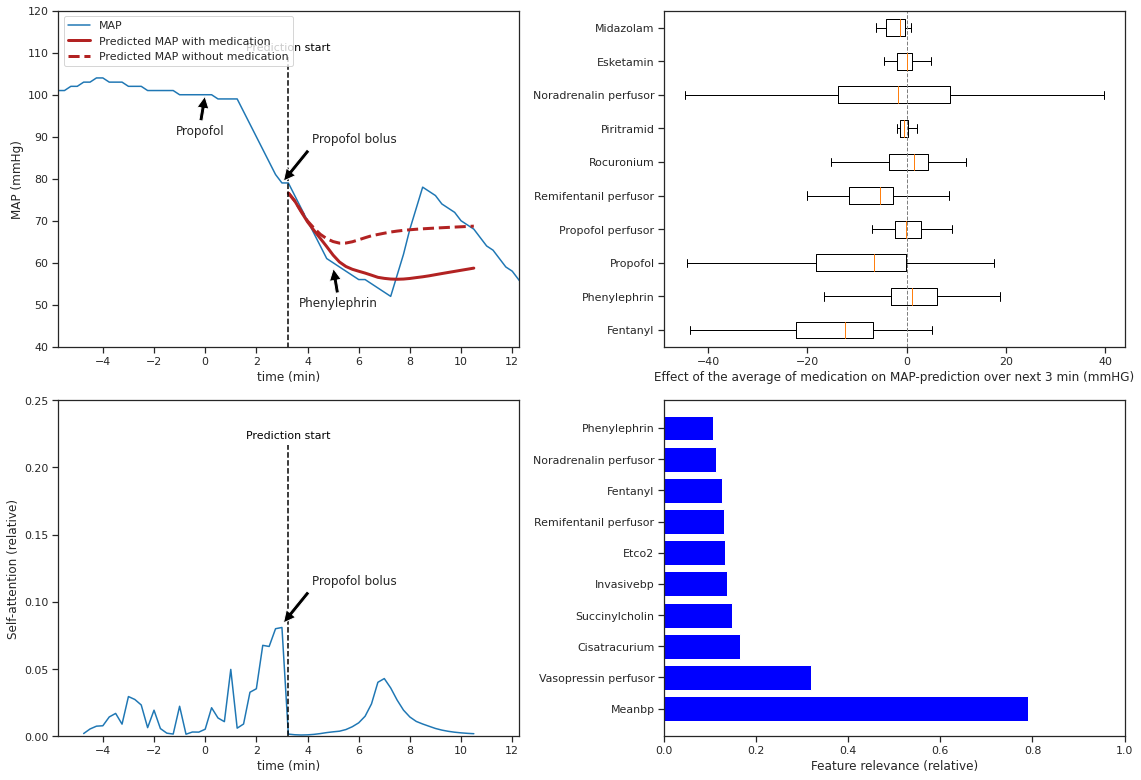

In [173]:
#%matplotlib widget
import seaborn as sns
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import data_formatters.base
from sklearn.metrics import mean_squared_error
# Default input types.

all_meds = ['berodual', 'cisatracurium', 'esketamin', 'etomidat',
       'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
       'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
       'sufentanil','dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
       'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
       'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor']

sns.set_style("ticks")
    
# Smallest context:
sns.set_context("notebook")

patient_nr = 52



model = model
column = 'meanbp'
data_formatter = data_formatter
window_length = 30
hist_length = 32
from IPython.display import clear_output

pred_col_names = []
for i in range(window_length):
    pred_col_names.append('t+'+str(i))

    
fig = figure(figsize=(16, 11))
((graph1, graph2), (graph5, graph4)) = fig.subplots(nrows=2, ncols=2)


InputTypes = data_formatters.base.InputTypes
observed_list = []
static_list = []
for ele in model.column_definition:
    if(ele[2]==InputTypes.OBSERVED_INPUT):
        observed_list.append(ele[0])
    if(ele[2]==InputTypes.STATIC_INPUT):
        static_list.append(ele[0])

for ele in model.column_definition:
    if(ele[2]==InputTypes.KNOWN_INPUT):
        observed_list.append(ele[0])
        
for ele in model.column_definition:
    if(ele[2]==InputTypes.TARGET):
        observed_list.append(ele[0])


indices = df['rand_id'].unique()
pat_id = indices[patient_nr]

df_pat = df[df['rand_id']==pat_id]
raw_pat = raw_data[raw_data['rand_id']==pat_id]






df_no_meds = df_pat.copy()
list_meds = []


for med in all_meds:

    # Step 1: Get the index of the first occurrence where raw_pat['med'] is 0.
    first_zero_index = raw_pat[med].eq(0).idxmax()

    # Verify that a zero was actually found; if no zero is found, idxmax() would still return an index.
    if raw_pat[med][first_zero_index] == 0:
        # Step 2: Get the value from df_no_meds['med'] at this index.
        value_to_set = df_no_meds[med][first_zero_index]
        # Step 3: Set the entire df_no_meds['med'] column to this value.
        df_no_meds[med] = value_to_set
    else:
        print("No zero value found in raw_pat['med']")



output_map_all = model.predict(df_pat)
attention_all = model.get_attention(df_pat)

predict_p10_meds = data_formatter.format_predictions(output_map_all["p10"])
predict_p50_meds = data_formatter.format_predictions(output_map_all["p50"])
predict_p90_meds = data_formatter.format_predictions(output_map_all["p90"])

output_map_no_meds = model.predict(df_no_meds)
attention_no_meds = model.get_attention(df_no_meds)

predict_p10_no_meds = data_formatter.format_predictions(output_map_no_meds["p10"])
predict_p50_no_meds = data_formatter.format_predictions(output_map_no_meds["p50"])
predict_p90_no_meds = data_formatter.format_predictions(output_map_no_meds["p90"])


df_reset = raw_pat.reset_index()

df_meds_all = df_reset
input_interact = []
for i, col in enumerate(df_meds_all.columns):
    
    input_interact.append((col, i))
    try:
        df_meds_all.loc[:,col] = df_meds_all[col].where(df_meds_all[col]>0)
    except:
        pass


df_reset = raw_pat.reset_index()
df_meds_no_meds = df_reset.copy()
df_meds_no_meds[all_meds] = 0
input_interact = []
for i, col in enumerate(df_meds_no_meds.columns):
    
    input_interact.append((col, i))
    try:
        df_meds_no_meds.loc[:,col] = df_meds_no_meds[col].where(df_meds_no_meds[col]>0)
    except:
        pass

predict_p10_meds = predict_p10_meds[pred_col_names]
predict_p50_meds = predict_p50_meds[pred_col_names]
predict_p90_meds = predict_p90_meds[pred_col_names]

predict_p10_no_meds = predict_p10_no_meds[pred_col_names]
predict_p50_no_meds = predict_p50_no_meds[pred_col_names]
predict_p90_no_meds = predict_p90_no_meds[pred_col_names]

targets = raw_pat['meanbp']

x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)
x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

len_pred = len(predict_p10_meds.iloc[0])

x_axis_pred = np.arange(0, len_pred)
plot_error = []

for x in range(len(raw_pat)-(window_length+hist_length)):
    plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50_meds.iloc[x]))


def update_pred(time, variable_int, meds_bool):
    time = int(time*4.)
    graph1.clear()
    graph2.clear()
    graph5.clear()
    graph4.clear()




    predict_p10 = predict_p10_meds
    predict_p50 = predict_p50_meds
    predict_p90 = predict_p90_meds  
    df_meds = df_meds_all
    attention = attention_all
    output_map = output_map_all


    # predict_p10 = predict_p10_no_meds
    # predict_p50 = predict_p50_no_meds
    # predict_p90 = predict_p90_no_meds
    # df_meds = df_meds_no_meds
    # attention = attention_no_meds
    # output_map = output_map_no_meds

    graph1.plot(x_axis/4., targets, label='MAP')

    x_axis_pred = np.arange(time, time + len_pred)
    x_axis_attention = np.arange(time-hist_length, time)
    x_axis_self_attention = np.arange(time-hist_length, time+window_length)
    

    graph1.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', linewidth=3.)
    graph1.plot(x_axis_pred/4., predict_p50_no_meds.iloc[time], color='firebrick', linestyle='dashed', linewidth=3.)   

    mean_p10 = np.min(predict_p10.loc[time, predict_p10.columns])
    mean_p50 = np.min(predict_p50.loc[time, predict_p50.columns])
    mean_p90 = np.min(predict_p90.loc[time, predict_p90.columns])

    TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
    TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
    TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
    
    proba = estimate_probability(predict_p10.loc[time, predict_p10_meds.columns], predict_p50_meds.loc[time, predict_p50.columns], predict_p90_meds.loc[time, predict_p90.columns], 65. )
    
    #print(np.max(proba), 15*(np.argmax(proba))/60)
    
    #graph1.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center', transform=graph1.transAxes)
    
    fig.canvas.draw_idle()
    observered_var = df_meds.columns[variable_int]
    index_observed = -1
    index_static = -1
    try:
        index_observed = observed_list.index(observered_var)
    except:
        pass
    
     
    try:
        index_static = static_list.index(observered_var)
    except:
        pass

    
    graph5.plot(x_axis_self_attention/4., attention['decoder_self_attn'][:,time,hist_length+window_length-1,:].mean(axis = 0))

    graph5.set_ylim([0,0.25])

    

    #graph5.axvline(x = (time-31+attention_time)/4., color = 'red', linestyle=":")
    
    plt.setp(graph1, ylabel='MAP (mmHg)', xlabel='time (min)')
    plt.setp(graph5, ylabel='Self-attention (relative)', xlabel='time (min)')   
    plt.setp(graph4, xlabel='Feature relevance (relative)')   
    

    
    graph1.vlines(x = time/4., color = 'black', ymin=0, ymax= 109, linestyle="dashed")
    graph1.text(time/4., 110, 'Prediction start',
            verticalalignment='bottom',
            horizontalalignment='center',
            color='black', fontsize=11)
    
    
        
    graph5.vlines(x = time/4., color = 'black', ymin=0, ymax= 0.217, linestyle="dashed")
    graph5.text(time/4., 0.22, 'Prediction start',
            verticalalignment='bottom',
            horizontalalignment='center',
            color='black', fontsize=11)

    

    # graph2.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
    # graph1.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])
    # graph5.set_xlim([-hist_length/4.,(len(raw_pat)-hist_length)/4.])

    graph1.set_xlim([time/4 - 9. ,time/4 +9])

    graph5.set_xlim([time/4 - 9. ,time/4 +9])    


    graph1.legend(['MAP','Predicted MAP with medication', 'Predicted MAP without medication'], loc = 'upper left')            

    


    # Step 4: Plot the horizontal bar chart
    graph4.barh(range(len(top_labels)), top_scores, color="b", align="center")

    # Set the y-axis labels to the generated labels with scores
    graph4.set_yticks(range(len(top_labels)), top_labels)
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.


    graph4.set_xlim([0,1])
    
    graph1.set_xlim([time/4 - 9. ,time/4 +9])
    graph1.set_ylim([40. ,120])
 
    
    graph5.set_xlim([time/4 - 9. ,time/4 +9])
    
    graph1.annotate('Propofol',
            xy=(420/60-7, 100), xycoords='data',
            xytext=(-5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')#
    
    graph1.annotate('Phenylephrin',
            xy=(720/60-7, 59), xycoords='data',
            xytext=(5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

    graph1.annotate('Propofol bolus',
                xy=(600/60-7, 79), xycoords='data',
                xytext=(30, 50), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top')
    
    graph5.annotate('Propofol bolus',
                xy=(600/60-7, 0.083), xycoords='data',
                xytext=(30, 50), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top')

    
    graph2.boxplot(adjusted_effects, vert=False, labels=[med.replace("_", " ").capitalize() for med, _ in top_10_medications], showfliers=False)

    graph2.set_xlabel('Effect of the average of medication on MAP-prediction over next 3 min (mmHG)')
    graph2.axvline(0,0,11, linewidth = 1, color = 'grey', linestyle= 'dashed' )

    
    fig.tight_layout()
    
    plt.savefig('TFT_Medication_'+str(kor)+'.tif')#
    plt.savefig('TFT_Medication_'+str(kor)+'.pdf', format='pdf')



#interact(update_pred, time = (0, (len(raw_pat)-(hist_length+window_length))/4., 0.05), variable_int = input_interact, meds_bool = [True, False])
update_pred(time = 3.25, variable_int = 4, meds_bool = True)

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'medication_influence' is a dictionary with medication names as keys and lists of effects as values.
# Replace 'medication_influence' and 'raw_data' with your actual data variables.

#used_meds = ['fentanyl', 'phenylephrin', 'propofol', 'propofol_perfusor', 'remifentanil_perfusor', 'rocuronium', 'vasopressin_perfusor', 'cisatracurium', 'succinylcholin', 'noradrenalin_perfusor']

# Sort the medications by the length of their effects list.
sorted_medications = sorted(medication_influence.items(), key=lambda item: len(item[1]), reverse=True)

# Pick the top 10 medications with the longest lists.
top_10_medications = sorted_medications[:10]

# Calculate the multiplier for each medication based on non-zero mean values from 'raw_data'.
multipliers = {}
for med, _ in top_10_medications:
    print(med)
    df_no_zeros = raw_data[med].replace(0, pd.NA)  # assuming raw_data[med] is a Series
    multipliers[med] = df_no_zeros.mean()
    print(raw_data[med].value_counts())

# Adjust the effects data for each medication by the multiplier.
adjusted_effects = []
for med,_ in top_10_medications:
    effects = medication_influence[med]
    adjusted_effect_count = [effect_count * multipliers[med]*12 for effect_count in effects]
    adjusted_effects.append(adjusted_effect_count)




fentanyl
fentanyl
0.0      40409894
100.0       66465
50.0        65621
200.0       16425
250.0       14649
           ...   
3.0             1
110.0           1
18.0            1
220.0           1
14.0            1
Name: count, Length: 67, dtype: int64
phenylephrin
phenylephrin
0.000    40460355
0.100       38069
0.060       37976
0.040       36512
0.080       12892
           ...   
0.069           1
1.050           1
0.520           1
0.650           1
1.160           1
Name: count, Length: 90, dtype: int64
propofol
propofol
0.0      40484990
200.0       23753
50.0        22085
20.0        13524
30.0        11341
           ...   
850.0           1
215.0           1
265.0           1
185.0           1
150.1           1
Name: count, Length: 85, dtype: int64
propofol_perfusor
propofol_perfusor
0.0000       29282245
400.0000      1747260
300.0000      1264433
360.0000      1007690
320.0000       617756
               ...   
515.1515            4
1932.0000           4
1090.0000         

In [144]:
df['succinylcholin'].value_counts()

succinylcholin
-0.003025      4065833
 340.641945         16
 272.512951         10
 170.319460          2
 238.448454          1
 204.383957          1
 68.125969           1
Name: count, dtype: int64

In [146]:
medication_influence['cisatracurium']

[0.09930780741075673]

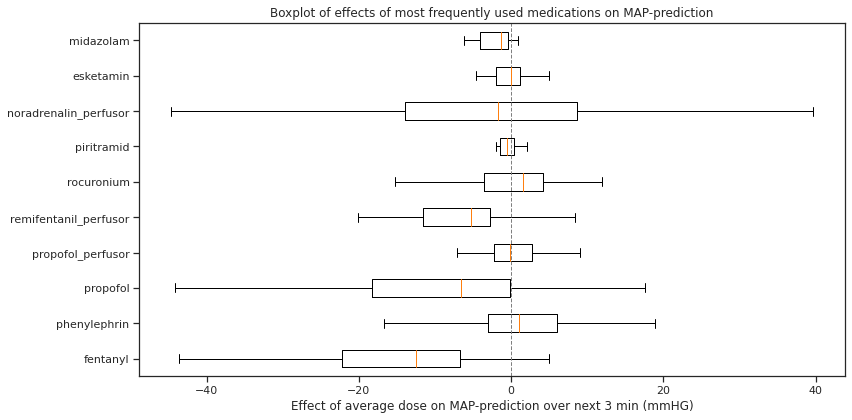

In [151]:
# Create the boxplot with the adjusted data.
plt.figure(figsize=(12, 6))
plt.boxplot(adjusted_effects, vert=False, labels=[med for med,_ in top_10_medications], showfliers=False)

plt.xlabel('Effect of average dose on MAP-prediction over next 3 min (mmHG)')
plt.title('Boxplot of effects of most frequently used medications on MAP-prediction')
plt.axvline(0,0,11, linewidth = 1, color = 'grey', linestyle= 'dashed' )
plt.tight_layout()
plt.show()


In [63]:
df['fentanyl']

36537446   -0.056649
36537447   -0.056649
36537448   -0.056649
36537449   -0.056649
36537450   -0.056649
              ...   
40603305   -0.056649
40603306   -0.056649
40603307   -0.056649
40603308   -0.056649
40603309   -0.056649
Name: fentanyl, Length: 4065864, dtype: float64

In [33]:
df

rand_id  case_time       age  gender  asa_score  urgency  \
36537446  25057716  -0.910030 -1.343508       0          0        2   
36537447  25057716  -0.907819 -1.343508       0          0        2   
36537448  25057716  -0.905608 -1.343508       0          0        2   
36537449  25057716  -0.903398 -1.343508       0          0        2   
36537450  25057716  -0.901187 -1.343508       0          0        2   
...            ...        ...       ...     ...        ...      ...   
40603305  36912118   0.122343  1.135875       1          1        1   
40603306  36912118   0.124554  1.135875       1          1        1   
40603307  36912118   0.126764  1.135875       1          1        1   
40603308  36912118   0.128975  1.135875       1          1        1   
40603309  36912118   0.131186  1.135875       1          1        1   

          surgery_type        hf     pulse      spo2     etco2  systolicbp  \
36537446             5  1.540916  1.798436 -0.854011 -1.634380    1.361101   
36537447             5  1.069552  1.269484 -0.854011 -1.634380    1.405224   
36537448             5  2.071200  2.393506 -0.854011 -1.634380    1.449347   
36537449             5  2.071200  2.393506 -0.854011 -1.634380    1.493470   
36537450             5  2.071200  2.393506 -0.854011 -1.634380    1.493470   
...                ...       ...       ...       ...       ...         ...   
40603305            10 -0.874825 -0.912442  0.203666  0.725362    1.802333   
40603306            10  0.185744 -0.912442  0.732505  0.785868    1.758210   
40603307            10 -1.051586 -0.846323  0.732505  1.451437    1.714087   
40603308            10 -0.285620 -0.912442  0.732505  1.027893    1.714087   
40603309            10 -0.521302 -0.912442  0.203666  0.664856    1.669963   

          diastolicbp    meanbp  invasivebp   insevo    exsevo     indes  \
36537446     0.926169  1.587389           0 -0.95183 -0.975074 -0.126543   
36537447     0.926169  1.587389           0 -0.95183 -0.975074 -0.126543   
36537448     0.926169  1.529200           0 -0.95183 -0.975074 -0.126543   
36537449     0.926169  1.529200           0 -0.95183 -0.975074 -0.126543   
36537450     0.859193  1.471011           0 -0.95183 -0.975074 -0.126543   
...               ...       ...         ...      ...       ...       ...   
40603305    -0.212424  0.947308           0 -0.95183 -0.855959 -0.126543   
40603306    -0.346376  0.889119           0 -0.95183 -0.855959 -0.126543   
40603307    -0.413352  0.772741           0 -0.95183 -0.736844 -0.126543   
40603308    -0.547304  0.714552           0 -0.95183 -0.736844 -0.126543   
40603309    -0.614280  0.598173           0 -0.95183 -0.855959 -0.126543   

             exdes  berodual  cisatracurium  esketamin  etomidat  fentanyl  \
36537446 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
36537447 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
36537448 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
36537449 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
36537450 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
...            ...       ...            ...        ...       ...       ...   
40603305 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
40603306 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
40603307 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
40603308 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   
40603309 -0.127662 -0.007504      -0.002755   -0.01151 -0.005974 -0.056649   

          midazolam  noradrenalin  phenylephrin  piritramid  propofol  \
36537446  -0.004448     -0.001985     -0.032751    -0.01477 -0.042724   
36537447  -0.004448     -0.001985     -0.032751    -0.01477 -0.042724   
36537448  -0.004448     -0.001985     -0.032751    -0.01477 -0.042724   
36537449  -0.004448     -0.001985     -0.032751    -0.01477 -0.042724   
365374

In [37]:
# import seaborn as sns
# from ipywidgets import *
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.colors as mcolors
# import data_formatters.base
# from sklearn.metrics import mean_squared_error
# from tqdm import tqdm
# from sklearn.preprocessing import normalize
# import pickle



# # Default input types.

# all_meds = ['berodual', 'cisatracurium', 'esketamin', 'etomidat',
#        'fentanyl', 'midazolam', 'noradrenalin', 'phenylephrin', 'piritramid',
#        'propofol', 'remifentanil', 'rocuronium', 'succinylcholin',
#        'sufentanil','dobutamin_perfusor', 'epinephrin_perfusor', 'levosimendan_perfusor',
#        'noradrenalin_perfusor', 'phenylephrin_perfusor', 'propofol_perfusor',
#        'remifentanil_perfusor', 'sufentanil_perfusor', 'vasopressin_perfusor']

# window_length = 30
# hist_length = 32
# pred_col_names = []

# score_dict = {}
# attention_scores = np.array([])
# for i in range(2, window_length-14):
#     pred_col_names.append('t+'+str(i))
# column = 'meanbp'
# ls = []
# InputTypes = data_formatters.base.InputTypes
# observed_list = []
# static_list = []
# for ele in model.column_definition:
#     if(ele[2]==InputTypes.OBSERVED_INPUT):
#         observed_list.append(ele[0])
#     if(ele[2]==InputTypes.STATIC_INPUT):
#         static_list.append(ele[0])

# for ele in model.column_definition:
#     if(ele[2]==InputTypes.KNOWN_INPUT):
#         observed_list.append(ele[0])

# for ele in model.column_definition:
#     if(ele[2]==InputTypes.TARGET):
#         observed_list.append(ele[0])
# medication_influence = {med: [] for med in all_meds}
# for patient_nr in tqdm(range(8000)):


#     indices = df['rand_id'].unique()
#     pat_id = indices[patient_nr]
 
#     df_pat = df[df['rand_id']==pat_id]
#     raw_pat = raw_data[raw_data['rand_id']==pat_id]
    


#     output_map_all = model.predict(df_pat)
#     attention = model.get_attention(df_pat)


#     predict_p50_meds = data_formatter.format_predictions(output_map_all["p50"])


#     time_matched_indices = df_pat['case_time'].isin(predict_p50_meds['forecast_time'])
#     predict_p50_meds = predict_p50_meds[pred_col_names]

#     # Filter both the predictions and df_pat by these matched times

#     matched_df_pat = raw_pat[time_matched_indices].reset_index(drop=True)

#     for med in all_meds:
        
#         df_no_meds = df_pat.copy()
#         # Identify where the medication is actually given

#         # Step 1: Get the index of the first occurrence where raw_pat['med'] is 0.
#         first_zero_index = raw_pat[med].eq(0).idxmax()

#         # Verify that a zero was actually found; if no zero is found, idxmax() would still return an index.
#         if raw_pat[med][first_zero_index] == 0:
#             # Step 2: Get the value from df_no_meds['med'] at this index.
#             value_to_set = df_no_meds[med][first_zero_index]


#             # Step 3: Set the entire df_no_meds['med'] column to this value.
#             df_no_meds[med] = value_to_set
#         else:
#             print("No zero value found in raw_pat['med']")
        


#         med_given_indices = matched_df_pat[med] > 0
    
#         # Extend the influence of the medication 16 indices beyond the administration point
#         extended_med_given_indices = med_given_indices.copy()
#         for i in range(len(med_given_indices)):
#             if med_given_indices[i]:
#                 # Set the next 16 indices to True, being careful not to go out of bounds
#                 extended_med_given_indices[i:min(i+12, len(med_given_indices))] = True
        
        
#         if(any(extended_med_given_indices)):
            
#             extended_med_amounts = np.zeros_like(matched_df_pat[med], dtype=float)

#             # Apply the amount of medication given at the initial index to all extended indices
#             for i, is_med_given in enumerate(med_given_indices):
#                 if is_med_given:
#                     extend_up_to = min(i+12, len(extended_med_given_indices))
#                     # Use the actual medication amount given at index 'i' and broadcast it up to 'extend_up_to'
#                     extended_med_amounts[i:extend_up_to] = matched_df_pat[med][i]

            
#             output_map_no_meds = model.predict(df_no_meds)
#             predict_p50_no_meds = data_formatter.format_predictions(output_map_no_meds["p50"])

#             predict_p50_no_meds = predict_p50_no_meds[pred_col_names]
#             # Calculate the difference in predictions when the medication is administered vs. not
#             med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
#             print(med_influence.shape)
#             print(extended_med_amounts[extended_med_given_indices].shape)
#             # Consider the amount of medication given by multiplying the influence by the medication amount
#             if med_influence.shape == extended_med_amounts[extended_med_given_indices].shape:
#                 med_influence /= extended_med_amounts[extended_med_given_indices]
#                 # Append the influence for this patient to our medication_influence dictionary
#                 medication_influence[med].append(med_influence.mean(axis=0))
#             else:
#                 # Handle the error appropriately - maybe log it or adjust the arrays to match
#                 print(f"Mismatched shapes: {med_influence.shape} vs {extended_med_amounts[extended_med_given_indices].shape}")


    
#         targets = raw_pat['meanbp']
    
#         if(attention_scores.size == 0):    
#             attention_scores = attention['historical_flags'][:,:,:].mean(axis=0).max(axis=0)
#         else:
#             attention_scores += attention['historical_flags'][:,:,:].mean(axis=0).max(axis=0)   
    
          
    
    
    
#     if((patient_nr & 10)==0 and patient_nr != 0 ):
        


#         for i, label in enumerate(observed_list):
#             label = label.replace("_", " ").capitalize()  # Format the label
#             if label in score_dict:
#                 score_dict[label] += attention_scores[i]
#             else:
#                 score_dict[label] = attention_scores[i]

#         # Create new lists for labels and their summed scores
#         labels = list(score_dict.keys())
        
#         summed_scores = np.array(list(score_dict.values()))

#         # Step 2: Normalize the summed scores
#         normalized_summed_scores = summed_scores / np.linalg.norm(summed_scores)

#         # Step 3: Sort the summed scores
#         sorted_indices = normalized_summed_scores.argsort()[::-1]
#         sorted_labels = [labels[i] for i in sorted_indices]
#         sorted_summed_scores = normalized_summed_scores[sorted_indices]
        
#         # Select the top 10 arguments (if you have at least 10)
#         top_labels = sorted_labels[:10]
#         top_scores = sorted_summed_scores[:10]

#         # Saving the dictionary to a pickle file
#         with open('medication_influence.pkl', 'wb') as pickle_file:
#             pickle.dump(medication_influence, pickle_file)

#         with open('top_labels.pkl', 'wb') as pickle_file:
#             pickle.dump(top_labels, pickle_file)
#         with open('top_scores.pkl', 'wb') as pickle_file:
#             pickle.dump(top_scores, pickle_file)
  

  0%|          | 1/8000 [00:02<4:46:18,  2.15s/it]

(48,)
(48,)
(48,)
(48,)


  0%|          | 2/8000 [00:07<8:30:55,  3.83s/it]

(12,)
(12,)
(36,)
(36,)
(24,)
(24,)
(12,)
(12,)
(12,)
(12,)


  0%|          | 3/8000 [00:11<9:18:44,  4.19s/it]

(355,)
(355,)
(12,)
(12,)


  0%|          | 4/8000 [00:14<8:10:16,  3.68s/it]

(120,)
(120,)
(12,)
(12,)
(12,)
(12,)


  0%|          | 5/8000 [00:17<7:29:35,  3.37s/it]

(221,)
(221,)
(221,)
(221,)


  0%|          | 6/8000 [00:20<7:07:51,  3.21s/it]

(24,)
(24,)
(24,)
(24,)
(120,)
(120,)


  0%|          | 7/8000 [00:24<7:37:35,  3.43s/it]

(36,)
(36,)
(12,)
(12,)
(12,)
(12,)


  0%|          | 8/8000 [00:27<7:31:01,  3.39s/it]

(12,)
(12,)


  0%|          | 10/8000 [00:32<6:11:20,  2.79s/it]

(12,)
(12,)
(36,)
(36,)
(12,)
(12,)
(241,)
(241,)


  0%|          | 11/8000 [00:34<6:10:40,  2.78s/it]

(241,)
(241,)
(12,)
(12,)


  0%|          | 12/8000 [00:37<6:17:23,  2.83s/it]

(12,)
(12,)


  0%|          | 14/8000 [00:42<5:31:40,  2.49s/it]

(12,)
(12,)


  0%|          | 15/8000 [00:45<5:57:30,  2.69s/it]

(36,)
(36,)


  0%|          | 16/8000 [00:47<5:38:08,  2.54s/it]

(12,)
(12,)
(116,)
(116,)
(12,)
(12,)
(60,)
(60,)


  0%|          | 17/8000 [00:53<8:09:37,  3.68s/it]

(43,)
(43,)
(108,)
(108,)
(12,)
(12,)
(867,)
(867,)


  0%|          | 18/8000 [00:59<9:40:51,  4.37s/it]

(891,)
(891,)
(48,)
(48,)
(48,)
(48,)
(12,)
(12,)


  0%|          | 19/8000 [01:04<10:06:45,  4.56s/it]

(668,)
(668,)
(72,)
(72,)


  0%|          | 20/8000 [01:09<10:17:32,  4.64s/it]

(36,)
(36,)


  0%|          | 21/8000 [01:12<8:59:05,  4.05s/it] 

(12,)
(12,)


  0%|          | 22/8000 [01:14<7:35:14,  3.42s/it]

(24,)
(24,)


  0%|          | 23/8000 [01:16<6:52:03,  3.10s/it]

(36,)
(36,)
(12,)
(12,)


  0%|          | 24/8000 [01:19<6:34:56,  2.97s/it]

(12,)
(12,)
(12,)
(12,)
(315,)
(315,)


  0%|          | 25/8000 [01:22<6:39:22,  3.00s/it]

(319,)
(319,)
(36,)
(36,)
(80,)
(80,)
(12,)
(12,)
(12,)
(12,)


  0%|          | 26/8000 [01:28<8:24:35,  3.80s/it]

(299,)
(299,)


  0%|          | 27/8000 [01:30<7:21:41,  3.32s/it]

(12,)
(12,)
(12,)
(12,)
(24,)
(24,)
(1459,)
(1459,)


  0%|          | 28/8000 [01:37<10:11:30,  4.60s/it]

(1459,)
(1459,)
(60,)
(60,)
(24,)
(24,)


  0%|          | 29/8000 [01:41<9:45:14,  4.41s/it] 

(576,)
(576,)


  0%|          | 30/8000 [01:43<8:13:04,  3.71s/it]

(24,)
(24,)
(12,)
(12,)
(120,)
(120,)
(36,)
(36,)
(12,)
(12,)
(36,)
(36,)
(1692,)
(1692,)


  0%|          | 31/8000 [01:55<13:15:44,  5.99s/it]

(51,)
(51,)
(48,)
(48,)
(12,)
(12,)
(26,)
(26,)
(839,)
(839,)
(989,)
(989,)


  0%|          | 32/8000 [02:02<13:55:28,  6.29s/it]

(978,)
(978,)


  0%|          | 33/8000 [02:04<11:11:14,  5.06s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


  0%|          | 34/8000 [02:06<9:27:11,  4.27s/it] 

(113,)
(113,)


  0%|          | 35/8000 [02:09<8:10:10,  3.69s/it]

(133,)
(133,)
(133,)
(133,)


  0%|          | 36/8000 [02:11<7:08:34,  3.23s/it]

(68,)
(68,)
(68,)
(68,)
(24,)
(24,)
(84,)
(84,)


  0%|          | 37/8000 [02:14<7:22:46,  3.34s/it]

(48,)
(48,)
(132,)
(132,)
(184,)
(184,)


  0%|          | 38/8000 [02:21<9:36:40,  4.35s/it]

(36,)
(36,)


  0%|          | 39/8000 [02:24<8:22:42,  3.79s/it]

(132,)
(132,)
(132,)
(132,)
(12,)
(12,)
(24,)
(24,)


  0%|          | 40/8000 [02:28<8:32:14,  3.86s/it]

(230,)
(230,)
No zero value found in raw_pat['med']
(309,)
(309,)
No zero value found in raw_pat['med']


  1%|          | 41/8000 [02:31<8:00:36,  3.62s/it]

(309,)
(309,)


  1%|          | 42/8000 [02:33<7:27:49,  3.38s/it]

(24,)
(24,)


  1%|          | 43/8000 [02:36<6:51:39,  3.10s/it]

(12,)
(12,)


  1%|          | 44/8000 [02:39<6:48:44,  3.08s/it]

(48,)
(48,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(24,)
(24,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(36,)
(36,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(12,)
(12,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(36,)
(36,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(659,)
(660,)
Mismatched shapes: (659,) vs (660,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(949,)
(950,)
Mismatched shapes: (949,) vs (950,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
  1%|          | 45/8000 [02:46<9:43:51,  4.40s/it]

(949,)
(950,)
Mismatched shapes: (949,) vs (950,)
(12,)
(12,)
(24,)
(24,)
(36,)
(36,)


  1%|          | 46/8000 [02:50<9:17:31,  4.21s/it]

(24,)
(24,)
(36,)
(36,)
(36,)
(36,)


  1%|          | 47/8000 [02:54<8:50:54,  4.01s/it]

(84,)
(84,)


  1%|          | 48/8000 [02:56<7:37:20,  3.45s/it]

(20,)
(20,)
(12,)
(12,)


  1%|          | 49/8000 [02:58<7:03:44,  3.20s/it]

(1,)
(1,)
(36,)
(36,)
(124,)
(124,)
(24,)
(24,)


  1%|          | 50/8000 [03:03<8:02:39,  3.64s/it]

(252,)
(252,)


  1%|          | 52/8000 [03:08<6:34:07,  2.98s/it]

(24,)
(24,)
(60,)
(60,)
(12,)
(12,)
(12,)
(12,)
(24,)
(24,)
(541,)
(541,)


  1%|          | 53/8000 [03:13<7:54:13,  3.58s/it]

(541,)
(541,)
(12,)
(12,)
(60,)
(60,)


  1%|          | 54/8000 [03:17<8:36:18,  3.90s/it]

(12,)
(12,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(24,)
(24,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(60,)
(60,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(300,)
(300,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(24,)
(24,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(36,)
(36,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(1165,)
(1165,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(1093,)
(1093,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
  1%|          | 55/8000 [03:27<12:13:23,  5.54s/it]

(675,)
(675,)
(12,)
(12,)
(110,)
(110,)


  1%|          | 56/8000 [03:29<10:20:45,  4.69s/it]

(110,)
(110,)
(52,)
(52,)
(12,)
(12,)
(414,)
(414,)


  1%|          | 57/8000 [03:33<9:39:27,  4.38s/it] 

(414,)
(414,)
(12,)
(12,)
(24,)
(24,)
(108,)
(108,)


  1%|          | 58/8000 [03:38<10:13:21,  4.63s/it]

(723,)
(723,)
(12,)
(12,)
(64,)
(64,)


  1%|          | 59/8000 [03:41<9:02:51,  4.10s/it] 

(12,)
(12,)
(48,)
(48,)
(12,)
(12,)
(45,)
(45,)
(24,)
(24,)


  1%|          | 60/8000 [03:45<8:38:24,  3.92s/it]

(36,)
(36,)


  1%|          | 61/8000 [03:47<7:38:59,  3.47s/it]

(12,)
(12,)


  1%|          | 62/8000 [03:49<6:41:25,  3.03s/it]

(60,)
(60,)
(24,)
(24,)
(36,)
(36,)
(24,)
(24,)


  1%|          | 63/8000 [03:53<7:24:03,  3.36s/it]

(24,)
(24,)
(12,)
(12,)
(48,)
(48,)
(12,)
(12,)
(12,)
(12,)
(1025,)
(1025,)


  1%|          | 64/8000 [04:01<10:07:19,  4.59s/it]

(1034,)
(1034,)


  1%|          | 65/8000 [04:03<8:51:25,  4.02s/it] 

(24,)
(24,)


  1%|          | 66/8000 [04:06<7:42:00,  3.49s/it]

(110,)
(110,)
(110,)
(110,)


  1%|          | 67/8000 [04:08<6:37:59,  3.01s/it]

(36,)
(36,)
(20,)
(20,)


  1%|          | 68/8000 [04:13<8:30:48,  3.86s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(383,)
(383,)


  1%|          | 69/8000 [04:17<8:38:34,  3.92s/it]

(413,)
(413,)
(12,)
(12,)
(84,)
(84,)
(12,)
(12,)
(36,)
(36,)


  1%|          | 70/8000 [04:25<10:48:35,  4.91s/it]

(1033,)
(1033,)
(48,)
(48,)
(104,)
(104,)
(12,)
(12,)


  1%|          | 71/8000 [04:29<10:12:38,  4.64s/it]

(24,)
(24,)
(12,)
(12,)
(91,)
(91,)
(48,)
(48,)
(12,)
(12,)
(36,)
(36,)
(513,)
(513,)


  1%|          | 72/8000 [04:34<10:25:52,  4.74s/it]

(55,)
(55,)


  1%|          | 74/8000 [04:38<7:28:44,  3.40s/it] 

(12,)
(12,)
(108,)
(108,)
(12,)
(12,)
(922,)
(922,)
(1264,)
(1264,)


  1%|          | 75/8000 [04:45<10:07:24,  4.60s/it]

(1264,)
(1264,)
(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(24,)
(24,)
(1251,)
(1251,)


  1%|          | 76/8000 [04:54<12:33:21,  5.70s/it]

(1251,)
(1251,)
(108,)
(108,)
(24,)
(24,)


  1%|          | 77/8000 [04:59<12:23:41,  5.63s/it]

(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(520,)
(520,)


  1%|          | 78/8000 [05:04<11:49:48,  5.38s/it]

(544,)
(544,)


  1%|          | 81/8000 [05:10<7:01:27,  3.19s/it] 

(24,)
(24,)
(12,)
(12,)


  1%|          | 82/8000 [05:12<6:28:53,  2.95s/it]

(12,)
(12,)
(84,)
(84,)
(84,)
(84,)


  1%|          | 83/8000 [05:18<7:54:54,  3.60s/it]

(12,)
(12,)


  1%|          | 84/8000 [05:20<6:54:05,  3.14s/it]

(24,)
(24,)


  1%|          | 85/8000 [05:23<6:46:11,  3.08s/it]

(379,)
(379,)
(36,)
(36,)
(24,)
(24,)
(36,)
(36,)
(655,)
(655,)


  1%|          | 86/8000 [05:28<8:11:09,  3.72s/it]

(671,)
(671,)


  1%|          | 87/8000 [05:30<7:19:28,  3.33s/it]

(12,)
(12,)
(12,)
(12,)
(358,)
(358,)


  1%|          | 88/8000 [05:33<7:11:26,  3.27s/it]

(358,)
(358,)


  1%|          | 89/8000 [05:35<6:27:08,  2.94s/it]

(48,)
(48,)


  1%|          | 90/8000 [05:39<6:43:54,  3.06s/it]

(12,)
(12,)


  1%|          | 91/8000 [05:41<6:15:32,  2.85s/it]

(24,)
(24,)
(12,)
(12,)
(829,)
(829,)
(846,)
(846,)


  1%|          | 92/8000 [05:47<8:09:41,  3.72s/it]

(846,)
(846,)
(36,)
(36,)
(196,)
(196,)
(12,)
(12,)
(12,)
(12,)


  1%|          | 93/8000 [05:53<9:48:14,  4.46s/it]

(131,)
(131,)
(24,)
(24,)
(12,)
(12,)
(349,)
(349,)


  1%|          | 94/8000 [05:57<9:11:05,  4.18s/it]

(349,)
(349,)


  1%|          | 95/8000 [05:59<7:58:04,  3.63s/it]

(116,)
(116,)
(116,)
(116,)


  1%|          | 96/8000 [06:01<6:48:26,  3.10s/it]

(36,)
(36,)


  1%|          | 97/8000 [06:03<6:29:43,  2.96s/it]

(325,)
(325,)
(132,)
(132,)
(12,)
(12,)
(12,)
(12,)


  1%|          | 98/8000 [06:08<7:22:16,  3.36s/it]

(566,)
(566,)


  1%|          | 99/8000 [06:10<6:53:03,  3.14s/it]

(36,)
(36,)
(36,)
(36,)
(12,)
(12,)
(12,)
(12,)


  1%|▏         | 100/8000 [06:15<7:32:25,  3.44s/it]

(417,)
(417,)


  1%|▏         | 101/8000 [06:17<6:47:57,  3.10s/it]

(12,)
(12,)
(48,)
(48,)


  1%|▏         | 102/8000 [06:19<6:25:12,  2.93s/it]

(12,)
(12,)


  1%|▏         | 103/8000 [06:21<5:53:44,  2.69s/it]

(12,)
(12,)
(24,)
(24,)
(12,)
(12,)


  1%|▏         | 104/8000 [06:25<6:32:10,  2.98s/it]

(489,)
(489,)
(60,)
(60,)


  1%|▏         | 105/8000 [06:29<6:51:27,  3.13s/it]

(60,)
(60,)


  1%|▏         | 106/8000 [06:31<6:25:15,  2.93s/it]

(12,)
(12,)


  1%|▏         | 107/8000 [06:33<5:48:05,  2.65s/it]

(12,)
(12,)
(36,)
(36,)


  1%|▏         | 108/8000 [06:35<5:26:53,  2.49s/it]

(48,)
(48,)
(125,)
(125,)
(125,)
(125,)
(24,)
(24,)
(179,)
(179,)


  1%|▏         | 109/8000 [06:38<5:24:24,  2.47s/it]

(179,)
(179,)


  1%|▏         | 110/8000 [06:39<5:01:25,  2.29s/it]

(12,)
(12,)
(24,)
(24,)
(12,)
(12,)


  1%|▏         | 111/8000 [06:42<5:21:50,  2.45s/it]

(12,)
(12,)
(24,)
(24,)


  1%|▏         | 112/8000 [06:46<5:52:03,  2.68s/it]

(36,)
(36,)
(84,)
(84,)
(12,)
(12,)


  1%|▏         | 113/8000 [06:49<6:38:44,  3.03s/it]

(36,)
(36,)
(24,)
(24,)
(12,)
(12,)


  1%|▏         | 114/8000 [06:52<6:39:51,  3.04s/it]

(192,)
(192,)
(196,)
(196,)
(24,)
(24,)
(36,)
(36,)
(12,)
(12,)


  1%|▏         | 115/8000 [06:56<6:45:25,  3.09s/it]

(12,)
(12,)
(24,)
(24,)
(24,)
(24,)
(542,)
(542,)
(632,)
(632,)


  1%|▏         | 116/8000 [07:02<8:51:28,  4.04s/it]

(636,)
(636,)


  1%|▏         | 117/8000 [07:04<7:40:46,  3.51s/it]

(12,)
(12,)
(78,)
(78,)


  1%|▏         | 118/8000 [07:06<6:53:53,  3.15s/it]

(12,)
(12,)
(195,)
(195,)
(48,)
(48,)


  1%|▏         | 119/8000 [07:09<6:44:37,  3.08s/it]

(317,)
(317,)
(12,)
(12,)


  2%|▏         | 120/8000 [07:12<6:29:48,  2.97s/it]

(36,)
(36,)


  2%|▏         | 121/8000 [07:14<6:05:27,  2.78s/it]

(12,)
(12,)


  2%|▏         | 122/8000 [07:16<5:31:13,  2.52s/it]

(24,)
(24,)
(12,)
(12,)
(56,)
(56,)


  2%|▏         | 123/8000 [07:19<5:41:31,  2.60s/it]

(199,)
(199,)


  2%|▏         | 124/8000 [07:22<5:39:04,  2.58s/it]

(12,)
(12,)
(47,)
(47,)


  2%|▏         | 125/8000 [07:25<5:59:24,  2.74s/it]

(51,)
(51,)
(24,)
(24,)
(12,)
(12,)
(24,)
(24,)


  2%|▏         | 126/8000 [07:29<6:40:58,  3.06s/it]

(12,)
(12,)
(36,)
(36,)
(12,)
(12,)
(12,)
(12,)
(898,)
(898,)


  2%|▏         | 127/8000 [07:35<8:51:56,  4.05s/it]

(898,)
(898,)


  2%|▏         | 128/8000 [07:37<7:45:33,  3.55s/it]

(12,)
(12,)
(96,)
(96,)
(108,)
(108,)
(72,)
(72,)


  2%|▏         | 129/8000 [07:42<8:09:11,  3.73s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(243,)
(243,)


  2%|▏         | 130/8000 [07:45<8:04:14,  3.69s/it]

(243,)
(243,)
(28,)
(28,)
(12,)
(12,)
(16,)
(16,)
(565,)
(565,)


  2%|▏         | 131/8000 [07:50<8:42:36,  3.98s/it]

(565,)
(565,)
(52,)
(52,)
(26,)
(26,)


  2%|▏         | 132/8000 [07:53<8:12:29,  3.76s/it]

(24,)
(24,)


  2%|▏         | 133/8000 [07:56<7:58:58,  3.65s/it]

(24,)
(24,)
(36,)
(36,)


  2%|▏         | 134/8000 [07:59<7:23:46,  3.38s/it]

(12,)
(12,)


  2%|▏         | 135/8000 [08:01<6:32:43,  3.00s/it]

(12,)
(12,)
(12,)
(12,)
(28,)
(28,)
(10,)
(10,)
(342,)
(342,)
(342,)
(342,)


  2%|▏         | 136/8000 [08:05<7:17:52,  3.34s/it]

(342,)
(342,)
(24,)
(24,)
(12,)
(12,)
(312,)
(312,)


  2%|▏         | 137/8000 [08:09<7:21:49,  3.37s/it]

(312,)
(312,)
(36,)
(36,)


  2%|▏         | 138/8000 [08:12<7:27:47,  3.42s/it]

(12,)
(12,)
(12,)
(12,)
(613,)
(613,)


  2%|▏         | 139/8000 [08:16<7:50:17,  3.59s/it]

(613,)
(613,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(466,)
(466,)


  2%|▏         | 140/8000 [08:23<9:35:37,  4.39s/it]

(455,)
(455,)


  2%|▏         | 141/8000 [08:25<8:26:49,  3.87s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(799,)
(799,)
(893,)
(893,)


  2%|▏         | 142/8000 [08:31<9:40:17,  4.43s/it]

(893,)
(893,)


  2%|▏         | 143/8000 [08:33<8:21:33,  3.83s/it]

(24,)
(24,)
(12,)
(12,)


  2%|▏         | 144/8000 [08:37<8:13:51,  3.77s/it]

(28,)
(28,)


  2%|▏         | 145/8000 [08:40<7:28:33,  3.43s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(483,)
(483,)


  2%|▏         | 146/8000 [08:44<7:54:09,  3.62s/it]

(479,)
(479,)


  2%|▏         | 147/8000 [08:46<7:11:41,  3.30s/it]

(7,)
(7,)
(36,)
(36,)


  2%|▏         | 148/8000 [08:49<6:50:24,  3.14s/it]

(12,)
(12,)
(36,)
(36,)


  2%|▏         | 149/8000 [08:52<6:48:42,  3.12s/it]

(48,)
(48,)


  2%|▏         | 150/8000 [08:54<6:08:29,  2.82s/it]

(12,)
(12,)
(12,)
(12,)
(48,)
(48,)
(36,)
(36,)
(24,)
(24,)


  2%|▏         | 151/8000 [08:58<6:47:20,  3.11s/it]

(12,)
(12,)


  2%|▏         | 152/8000 [09:03<7:44:14,  3.55s/it]

(84,)
(84,)
(369,)
(369,)


  2%|▏         | 153/8000 [09:06<7:17:23,  3.34s/it]

(369,)
(369,)


  2%|▏         | 154/8000 [09:08<6:30:09,  2.98s/it]

(12,)
(12,)
(438,)
(438,)


  2%|▏         | 155/8000 [09:11<6:40:27,  3.06s/it]

(438,)
(438,)
(24,)
(24,)
(12,)
(12,)


  2%|▏         | 156/8000 [09:14<6:32:14,  3.00s/it]

(12,)
(12,)


  2%|▏         | 157/8000 [09:16<6:01:29,  2.77s/it]

(12,)
(12,)
(70,)
(70,)
(24,)
(24,)
(22,)
(22,)


  2%|▏         | 158/8000 [09:18<5:51:04,  2.69s/it]

(12,)
(12,)
(12,)
(12,)
(36,)
(36,)
(24,)
(24,)
(104,)
(104,)
(48,)
(48,)
(108,)
(108,)
(364,)
(364,)


  2%|▏         | 159/8000 [09:36<15:38:18,  7.18s/it]

(2505,)
(2505,)
(24,)
(24,)
(12,)
(12,)


  2%|▏         | 160/8000 [09:40<13:45:54,  6.32s/it]

(12,)
(12,)
(12,)
(12,)


  2%|▏         | 161/8000 [09:43<11:34:09,  5.31s/it]

(24,)
(24,)
(96,)
(96,)
(30,)
(30,)


  2%|▏         | 162/8000 [09:48<11:10:53,  5.14s/it]

(12,)
(12,)
(24,)
(24,)


  2%|▏         | 163/8000 [09:51<9:52:06,  4.53s/it] 

(104,)
(104,)


  2%|▏         | 164/8000 [09:54<8:32:39,  3.93s/it]

(12,)
(12,)
(12,)
(12,)
(32,)
(32,)
(60,)
(60,)


  2%|▏         | 165/8000 [09:57<7:53:13,  3.62s/it]

(24,)
(24,)
(16,)
(16,)
(12,)
(12,)
(255,)
(255,)


  2%|▏         | 166/8000 [10:00<7:47:39,  3.58s/it]

(255,)
(255,)
(24,)
(24,)


  2%|▏         | 167/8000 [10:03<7:31:39,  3.46s/it]

(12,)
(12,)
(36,)
(36,)


  2%|▏         | 168/8000 [10:07<7:22:18,  3.39s/it]

(92,)
(92,)
(24,)
(24,)
(120,)
(120,)


  2%|▏         | 169/8000 [10:10<7:08:19,  3.28s/it]

(12,)
(12,)
(12,)
(12,)
(120,)
(120,)
(28,)
(28,)


  2%|▏         | 170/8000 [10:14<7:51:39,  3.61s/it]

(12,)
(12,)


  2%|▏         | 172/8000 [10:18<6:04:30,  2.79s/it]

(12,)
(12,)
(676,)
(676,)


  2%|▏         | 173/8000 [10:22<6:55:41,  3.19s/it]

(676,)
(676,)


  2%|▏         | 174/8000 [10:25<6:27:31,  2.97s/it]

(198,)
(198,)
(198,)
(198,)
(12,)
(12,)
(12,)
(12,)
(180,)
(180,)
(268,)
(268,)
(72,)
(72,)


  2%|▏         | 175/8000 [10:36<11:38:08,  5.35s/it]

(1635,)
(1635,)


  2%|▏         | 176/8000 [10:38<9:58:47,  4.59s/it] 

(12,)
(12,)
(48,)
(48,)


  2%|▏         | 177/8000 [10:41<8:57:18,  4.12s/it]

(12,)
(12,)
(12,)
(12,)
(132,)
(132,)
(84,)
(84,)
(36,)
(36,)


  2%|▏         | 178/8000 [10:49<11:15:52,  5.18s/it]

(1136,)
(1136,)
(12,)
(12,)
(12,)
(12,)


  2%|▏         | 179/8000 [10:52<9:38:07,  4.44s/it] 

(59,)
(59,)
(60,)
(60,)
(587,)
(587,)


  2%|▏         | 180/8000 [10:56<9:24:00,  4.33s/it]

(587,)
(587,)
(36,)
(36,)
(48,)
(48,)
(12,)
(12,)


  2%|▏         | 181/8000 [10:59<8:37:19,  3.97s/it]

(12,)
(12,)


  2%|▏         | 182/8000 [11:02<7:48:43,  3.60s/it]

(12,)
(12,)
(24,)
(24,)
(72,)
(72,)


  2%|▏         | 183/8000 [11:05<7:34:11,  3.49s/it]

(24,)
(24,)


  2%|▏         | 185/8000 [11:09<5:57:53,  2.75s/it]

(24,)
(24,)
(12,)
(12,)
(1243,)
(1243,)
(1243,)
(1243,)


  2%|▏         | 186/8000 [11:17<9:09:24,  4.22s/it]

(1243,)
(1243,)
(24,)
(24,)
(12,)
(12,)
(96,)
(96,)
(12,)
(12,)
(96,)
(96,)


  2%|▏         | 187/8000 [11:27<13:05:38,  6.03s/it]

(1546,)
(1546,)


  2%|▏         | 188/8000 [11:29<10:38:27,  4.90s/it]

(12,)
(12,)
(12,)
(12,)
(24,)
(24,)
(12,)
(12,)
(288,)
(288,)


  2%|▏         | 189/8000 [11:33<9:39:47,  4.45s/it] 

(288,)
(288,)


  2%|▏         | 190/8000 [11:35<8:29:26,  3.91s/it]

(273,)
(273,)
(362,)
(362,)


  2%|▏         | 191/8000 [11:38<8:02:20,  3.71s/it]

(362,)
(362,)
(24,)
(24,)
(48,)
(48,)
(16,)
(16,)


  2%|▏         | 192/8000 [11:42<8:05:19,  3.73s/it]

(36,)
(36,)
(195,)
(195,)


  2%|▏         | 193/8000 [11:45<7:28:52,  3.45s/it]

(260,)
(260,)


  2%|▏         | 194/8000 [11:47<6:46:34,  3.13s/it]

(12,)
(12,)
(87,)
(87,)
(12,)
(12,)
(60,)
(60,)
(96,)
(96,)
(48,)
(48,)
(12,)
(12,)


  2%|▏         | 195/8000 [11:53<8:40:44,  4.00s/it]

(714,)
(714,)
(24,)
(24,)
(24,)
(24,)
(12,)
(12,)
(605,)
(605,)


  2%|▏         | 196/8000 [11:58<9:10:11,  4.23s/it]

(605,)
(605,)


  2%|▏         | 197/8000 [12:01<8:21:20,  3.85s/it]

(70,)
(70,)


  2%|▏         | 198/8000 [12:03<7:07:22,  3.29s/it]

(12,)
(12,)
(25,)
(25,)


  2%|▏         | 199/8000 [12:05<6:19:02,  2.92s/it]

(12,)
(12,)
(96,)
(96,)
(68,)
(68,)
(24,)
(24,)


  2%|▎         | 200/8000 [12:13<9:12:50,  4.25s/it]

(1456,)
(1456,)
(72,)
(72,)
(12,)
(12,)
(388,)
(388,)


  3%|▎         | 201/8000 [12:16<8:57:15,  4.13s/it]

(388,)
(388,)
(2,)
(2,)
(120,)
(120,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(315,)
(315,)


  3%|▎         | 202/8000 [12:21<8:59:56,  4.15s/it]

(315,)
(315,)
(12,)
(12,)
(1079,)
(1079,)
(1353,)
(1353,)


  3%|▎         | 203/8000 [12:28<11:12:07,  5.17s/it]

(1353,)
(1353,)
(12,)
(12,)
(12,)
(12,)
(60,)
(60,)
(12,)
(12,)
(879,)
(879,)


  3%|▎         | 204/8000 [12:35<12:17:11,  5.67s/it]

(975,)
(975,)
(24,)
(24,)
(24,)
(24,)


  3%|▎         | 205/8000 [12:38<10:24:25,  4.81s/it]

(12,)
(12,)
(12,)
(12,)


  3%|▎         | 206/8000 [12:41<9:14:35,  4.27s/it] 

(12,)
(12,)
(48,)
(48,)
(36,)
(36,)
(60,)
(60,)
(1239,)
(1239,)
(744,)
(744,)


  3%|▎         | 207/8000 [12:50<12:23:53,  5.73s/it]

(1048,)
(1048,)


  3%|▎         | 208/8000 [12:52<10:05:07,  4.66s/it]

(36,)
(36,)
(12,)
(12,)
(714,)
(714,)
(760,)
(760,)


  3%|▎         | 209/8000 [12:57<10:25:47,  4.82s/it]

(760,)
(760,)


  3%|▎         | 210/8000 [13:00<9:11:12,  4.25s/it] 

(24,)
(24,)


  3%|▎         | 211/8000 [13:02<7:54:57,  3.66s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(261,)
(261,)


  3%|▎         | 212/8000 [13:06<7:30:05,  3.47s/it]

(261,)
(261,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(441,)
(441,)


  3%|▎         | 213/8000 [13:10<7:51:03,  3.63s/it]

(441,)
(441,)
(1037,)
(1037,)


  3%|▎         | 214/8000 [13:14<8:37:21,  3.99s/it]

(1037,)
(1037,)
(24,)
(24,)
(12,)
(12,)


  3%|▎         | 215/8000 [13:17<7:44:21,  3.58s/it]

(12,)
(12,)
(24,)
(24,)
(48,)
(48,)


  3%|▎         | 216/8000 [13:20<7:16:38,  3.37s/it]

(17,)
(17,)


  3%|▎         | 217/8000 [13:22<6:22:29,  2.95s/it]

(12,)
(12,)
(63,)
(63,)


  3%|▎         | 218/8000 [13:25<6:19:30,  2.93s/it]

(36,)
(36,)


  3%|▎         | 219/8000 [13:27<5:47:34,  2.68s/it]

(4,)
(4,)
(72,)
(72,)
(36,)
(36,)
(36,)
(36,)


  3%|▎         | 220/8000 [13:33<7:46:00,  3.59s/it]

(775,)
(775,)
(20,)
(20,)
(12,)
(12,)
(97,)
(97,)


  3%|▎         | 221/8000 [13:35<7:03:22,  3.27s/it]

(97,)
(97,)


  3%|▎         | 222/8000 [13:37<6:12:35,  2.87s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(48,)
(48,)
(84,)
(84,)


  3%|▎         | 223/8000 [13:42<7:36:45,  3.52s/it]

(12,)
(12,)


  3%|▎         | 224/8000 [13:44<6:55:23,  3.21s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(208,)
(208,)


  3%|▎         | 225/8000 [13:47<6:26:16,  2.98s/it]

(208,)
(208,)


  3%|▎         | 226/8000 [13:50<6:18:23,  2.92s/it]

(12,)
(12,)


  3%|▎         | 227/8000 [13:52<6:13:07,  2.88s/it]

(12,)
(12,)
(24,)
(24,)
(120,)
(120,)
(12,)
(12,)
(24,)
(24,)
(563,)
(563,)


  3%|▎         | 228/8000 [13:58<8:13:40,  3.81s/it]

(599,)
(599,)


  3%|▎         | 229/8000 [14:01<7:32:29,  3.49s/it]

(12,)
(12,)
(24,)
(24,)


  3%|▎         | 230/8000 [14:04<7:19:11,  3.39s/it]

(12,)
(12,)


  3%|▎         | 231/8000 [14:08<7:16:47,  3.37s/it]

(36,)
(36,)


  3%|▎         | 232/8000 [14:10<6:33:03,  3.04s/it]

(12,)
(12,)
(28,)
(28,)
(116,)
(116,)


  3%|▎         | 233/8000 [14:15<7:53:05,  3.65s/it]

(48,)
(48,)


  3%|▎         | 234/8000 [14:18<7:21:24,  3.41s/it]

(48,)
(48,)


  3%|▎         | 235/8000 [14:20<6:25:18,  2.98s/it]

(12,)
(12,)


  3%|▎         | 236/8000 [14:22<5:50:53,  2.71s/it]

(12,)
(12,)
(81,)
(81,)
(81,)
(81,)


  3%|▎         | 238/8000 [14:26<5:18:50,  2.46s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(73,)
(73,)


  3%|▎         | 239/8000 [14:28<5:03:06,  2.34s/it]

(73,)
(73,)
(12,)
(12,)
(24,)
(24,)


  3%|▎         | 241/8000 [14:33<4:57:00,  2.30s/it]

(12,)
(12,)
(22,)
(22,)
(48,)
(48,)
(12,)
(12,)
(12,)
(12,)


  3%|▎         | 242/8000 [14:36<5:35:17,  2.59s/it]

(230,)
(230,)
(290,)
(290,)


  3%|▎         | 243/8000 [14:39<5:43:19,  2.66s/it]

(290,)
(290,)
(12,)
(12,)
(125,)
(125,)


  3%|▎         | 244/8000 [14:41<5:35:13,  2.59s/it]

(125,)
(125,)


  3%|▎         | 245/8000 [14:44<5:21:31,  2.49s/it]

(6,)
(6,)
(5,)
(5,)
(611,)
(611,)


  3%|▎         | 246/8000 [14:47<5:51:11,  2.72s/it]

(611,)
(611,)
(24,)
(24,)
(36,)
(36,)


  3%|▎         | 247/8000 [14:50<6:15:33,  2.91s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


  3%|▎         | 248/8000 [14:53<6:04:55,  2.82s/it]

(12,)
(12,)
(115,)
(115,)


  3%|▎         | 249/8000 [14:55<5:52:19,  2.73s/it]

(12,)
(12,)
(148,)
(148,)
(313,)
(313,)


  3%|▎         | 250/8000 [14:58<5:54:21,  2.74s/it]

(313,)
(313,)
(24,)
(24,)
(12,)
(12,)
(17,)
(17,)


  3%|▎         | 251/8000 [15:02<6:40:19,  3.10s/it]

(12,)
(12,)
(12,)
(12,)
(224,)
(224,)


  3%|▎         | 252/8000 [15:05<6:23:51,  2.97s/it]

(224,)
(224,)


  3%|▎         | 253/8000 [15:07<6:09:22,  2.86s/it]

(12,)
(12,)


  3%|▎         | 254/8000 [15:10<5:58:51,  2.78s/it]

(213,)
(213,)
(221,)
(221,)
(24,)
(24,)


  3%|▎         | 255/8000 [15:13<6:18:40,  2.93s/it]

(68,)
(68,)
(12,)
(12,)
(12,)
(12,)


  3%|▎         | 256/8000 [15:16<6:01:36,  2.80s/it]

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(1289,)
(1289,)


  3%|▎         | 257/8000 [15:27<11:10:57,  5.20s/it]

(1321,)
(1321,)
(12,)
(12,)
(335,)
(335,)


  3%|▎         | 258/8000 [15:30<9:51:10,  4.58s/it] 

(339,)
(339,)


  3%|▎         | 259/8000 [15:32<8:31:44,  3.97s/it]

(12,)
(12,)
(12,)
(12,)


  3%|▎         | 260/8000 [15:35<7:32:44,  3.51s/it]

(24,)
(24,)


  3%|▎         | 261/8000 [15:37<6:59:13,  3.25s/it]

(12,)
(12,)


  3%|▎         | 262/8000 [15:40<6:49:21,  3.17s/it]

(36,)
(36,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(48,)
(48,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)


(24,)
(24,)


/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
/tmp/ipykernel_571418/923503192.py:123: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  med_influence = (predict_p50_meds[extended_med_given_indices] - predict_p50_no_meds[extended_med_given_indices]).mean(axis=1)
  3%|▎         | 263/8000 [15:44<7:18:05,  3.40s/it]

(12,)
(12,)
(168,)
(168,)
(88,)
(88,)


  3%|▎         | 264/8000 [15:52<10:05:25,  4.70s/it]

(78,)
(78,)
(36,)
(36,)
(12,)
(12,)


  3%|▎         | 265/8000 [15:55<8:54:09,  4.14s/it] 

(24,)
(24,)
(12,)
(12,)


  3%|▎         | 266/8000 [15:57<7:42:23,  3.59s/it]

(12,)
(12,)


  3%|▎         | 267/8000 [15:59<6:40:04,  3.10s/it]

(2,)
(2,)
(6,)
(6,)


  3%|▎         | 268/8000 [16:01<6:05:36,  2.84s/it]

(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(251,)
(251,)


  3%|▎         | 269/8000 [16:04<6:04:10,  2.83s/it]

(251,)
(251,)


  3%|▎         | 270/8000 [16:07<5:50:07,  2.72s/it]

(126,)
(126,)
(126,)
(126,)


  3%|▎         | 271/8000 [16:09<5:43:06,  2.66s/it]

(24,)
(24,)
(12,)
(12,)
(24,)
(24,)
(12,)
(12,)


  3%|▎         | 272/8000 [16:11<5:21:52,  2.50s/it]

(386,)
(386,)


  3%|▎         | 273/8000 [16:14<5:49:03,  2.71s/it]

(386,)
(386,)
(24,)
(24,)


  3%|▎         | 274/8000 [16:18<6:05:29,  2.84s/it]

(12,)
(12,)


  3%|▎         | 275/8000 [16:20<5:42:29,  2.66s/it]

(32,)
(32,)


  3%|▎         | 276/8000 [16:22<5:24:21,  2.52s/it]

(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(316,)
(316,)


  3%|▎         | 277/8000 [16:25<5:45:24,  2.68s/it]

(318,)
(318,)
(12,)
(12,)
(815,)
(815,)
(1175,)
(1175,)


  3%|▎         | 278/8000 [16:32<8:15:26,  3.85s/it]

(1175,)
(1175,)
(12,)
(12,)
(363,)
(363,)


  3%|▎         | 279/8000 [16:35<7:54:20,  3.69s/it]

(363,)
(363,)


  4%|▎         | 280/8000 [16:37<6:55:27,  3.23s/it]

(12,)
(12,)


  4%|▎         | 281/8000 [16:39<6:10:49,  2.88s/it]

(12,)
(12,)
(57,)
(57,)
(57,)
(57,)
(12,)
(12,)
(60,)
(60,)
(391,)
(391,)


  4%|▎         | 282/8000 [16:43<6:39:03,  3.10s/it]

(391,)
(391,)
(12,)
(12,)
(523,)
(523,)


  4%|▎         | 283/8000 [16:47<7:10:10,  3.34s/it]

(523,)
(523,)


  4%|▎         | 284/8000 [16:49<6:25:55,  3.00s/it]

(12,)
(12,)
(12,)
(12,)


  4%|▎         | 285/8000 [16:52<6:24:18,  2.99s/it]

(12,)
(12,)
(36,)
(36,)
(24,)
(24,)


  4%|▎         | 286/8000 [16:56<7:17:33,  3.40s/it]

(575,)
(575,)


  4%|▎         | 287/8000 [16:58<6:33:18,  3.06s/it]

(12,)
(12,)
(60,)
(60,)
(60,)
(60,)
(12,)
(12,)


  4%|▎         | 288/8000 [17:03<7:19:23,  3.42s/it]

(12,)
(12,)


  4%|▎         | 289/8000 [17:05<6:41:42,  3.13s/it]

(12,)
(12,)
(36,)
(36,)


  4%|▎         | 290/8000 [17:10<7:28:37,  3.49s/it]

(787,)
(787,)
(108,)
(108,)
(60,)
(60,)
(12,)
(12,)
(12,)
(12,)


  4%|▎         | 291/8000 [17:17<9:56:21,  4.64s/it]

(307,)
(307,)


  4%|▎         | 292/8000 [17:20<8:41:14,  4.06s/it]

(12,)
(12,)


  4%|▎         | 293/8000 [17:22<7:46:57,  3.64s/it]

(48,)
(48,)


  4%|▎         | 294/8000 [17:24<6:52:09,  3.21s/it]

(9,)
(9,)
(84,)
(84,)


  4%|▎         | 295/8000 [17:29<7:38:54,  3.57s/it]

(12,)
(12,)
(72,)
(72,)
(60,)
(60,)
(12,)
(12,)


  4%|▎         | 296/8000 [17:33<8:16:45,  3.87s/it]

(12,)
(12,)


  4%|▎         | 297/8000 [17:35<7:02:08,  3.29s/it]

(24,)
(24,)
(96,)
(96,)
(24,)
(24,)


  4%|▎         | 298/8000 [17:39<7:08:28,  3.34s/it]

(12,)
(12,)


  4%|▎         | 299/8000 [17:41<6:18:56,  2.95s/it]

(12,)
(12,)


  4%|▍         | 300/8000 [17:43<5:38:55,  2.64s/it]

(12,)
(12,)


  4%|▍         | 301/8000 [17:45<5:22:01,  2.51s/it]

(12,)
(12,)
(36,)
(36,)


  4%|▍         | 302/8000 [17:47<5:17:53,  2.48s/it]

(36,)
(36,)
(36,)
(36,)
(12,)
(12,)
(24,)
(24,)


  4%|▍         | 303/8000 [17:51<6:12:20,  2.90s/it]

(24,)
(24,)


  4%|▍         | 304/8000 [17:53<5:34:29,  2.61s/it]

(32,)
(32,)
(24,)
(24,)


  4%|▍         | 305/8000 [17:56<5:50:01,  2.73s/it]

(24,)
(24,)
(24,)
(24,)
(24,)
(24,)
(36,)
(36,)
(722,)
(722,)
(642,)
(642,)
(723,)
(723,)


  4%|▍         | 306/8000 [18:02<7:50:15,  3.67s/it]

(718,)
(718,)
(12,)
(12,)
(56,)
(56,)
(36,)
(36,)


  4%|▍         | 307/8000 [18:06<8:10:23,  3.82s/it]

(12,)
(12,)


  4%|▍         | 309/8000 [18:11<6:31:23,  3.05s/it]

(12,)
(12,)
(118,)
(118,)


  4%|▍         | 310/8000 [18:13<5:51:44,  2.74s/it]

(12,)
(12,)
(24,)
(24,)
(24,)
(24,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(502,)
(502,)


  4%|▍         | 311/8000 [18:17<6:58:16,  3.26s/it]

(502,)
(502,)
(12,)
(12,)
(211,)
(211,)


  4%|▍         | 312/8000 [18:20<6:38:48,  3.11s/it]

(211,)
(211,)
(36,)
(36,)
(332,)
(332,)


  4%|▍         | 313/8000 [18:23<6:40:02,  3.12s/it]

(332,)
(332,)
(24,)
(24,)
(12,)
(12,)


  4%|▍         | 314/8000 [18:28<7:27:23,  3.49s/it]

(12,)
(12,)
(24,)
(24,)
(12,)
(12,)


  4%|▍         | 314/8000 [18:34<7:34:29,  3.55s/it]


KeyboardInterrupt: 

In [145]:

import pickle

# Load the medication_influence dictionary from the pickle file
with open('medication_influence.pkl', 'rb') as pickle_file:
    medication_influence = pickle.load(pickle_file)

# Load the top_labels list from the pickle file
with open('top_labels.pkl', 'rb') as pickle_file:
    top_labels = pickle.load(pickle_file)

# Load the top_scores list from the pickle file
with open('top_scores.pkl', 'rb') as pickle_file:
    top_scores = pickle.load(pickle_file)

In [39]:
    for med, influence in medication_influence.items():
            print(f"Medication: {med}, Influence: {influence}")
            

Medication: berodual, Influence: [-0.05511813055879126, 0.11368151080872242, -0.20254263281822205, -0.043476138496771455]
Medication: cisatracurium, Influence: [0.09930780741075673]
Medication: esketamin, Influence: [-0.0005393755408780028, 0.0029500699825196837, 0.00014145261763284583, -0.05210752010345459, -0.041976260828475165, 0.016533420516384973, 0.00633409051845471, -0.021928189606923196, 0.0030692218740781146, 0.005140121400149332, -0.005419100054617351, -0.005832323301583527, -0.0560391209522883, -0.013028753471250336, 0.01284223089615504, 0.002897020963331064, -0.0016462076198270857, 0.023411518925180036, 0.00537130086372296, -0.011423646965219329, 0.012703286897805, -0.009466637681341834, 0.0015023528913124687, -0.0008877496131592327, 0.00413488890044391]
Medication: etomidat, Influence: [-0.04072197191417217, -0.09139669090509417]
Medication: fentanyl, Influence: [-0.004016206698676494, -0.0481023700721562, -0.013458084190885226, -0.0012674197725330788, -0.0096315767414247,

[0.78935176 0.3198266  0.16583715 0.14692412 0.13763541 0.132813
 0.12978458 0.12614892 0.11288819 0.1064659 ]


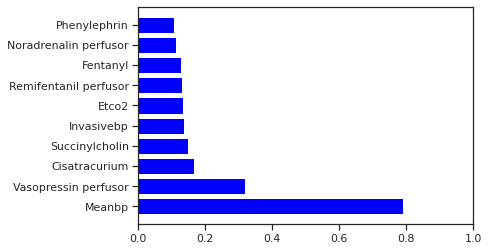

In [40]:
print(top_scores)

# Step 4: Plot the horizontal bar chart
plt.barh(range(len(top_labels)), top_scores, color="b", align="center")

# Set the y-axis labels to the generated labels with scores
plt.yticks(range(len(top_labels)), top_labels)

# Set the x-axis limits if necessary (depending on your data)
plt.xlim([0, 1])

# Display the plot
plt.show()

In [ ]:
raw_pat.columns


In [97]:
raw_data['phenylephrin'].value_counts()

phenylephrin
0.000    40460355
0.100       38069
0.060       37976
0.040       36512
0.080       12892
           ...   
0.069           1
1.050           1
0.520           1
0.650           1
1.160           1
Name: count, Length: 90, dtype: int64

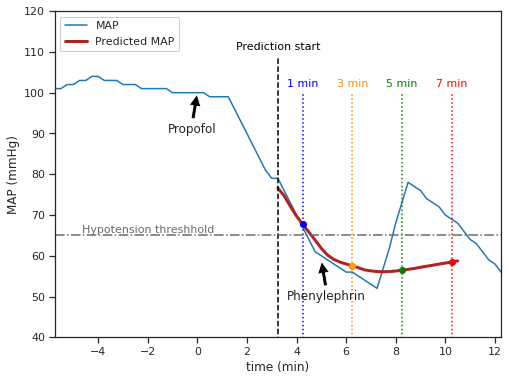

In [41]:
import seaborn as sns
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import data_formatters.base
from sklearn.metrics import mean_squared_error
# Default input types.

sns.set_style("ticks")
    
# Smallest context:
sns.set_context("notebook")
patient_nr = 52
time = int(3.25*4)

model = model
column = 'meanbp'
data_formatter = data_formatter
window_length = 30
hist_length = 32
from IPython.display import clear_output

pred_col_names = []
for i in range(window_length):
    print()
    pred_col_names.append('t+'+str(i))

    
fig = figure(figsize=(8, 6))




InputTypes = data_formatters.base.InputTypes
observed_list = []
static_list = []
for ele in model.column_definition:
    if(ele[2]==InputTypes.OBSERVED_INPUT):
        observed_list.append(ele[0])
    if(ele[2]==InputTypes.STATIC_INPUT):
        static_list.append(ele[0])

for ele in model.column_definition:
    if(ele[2]==InputTypes.KNOWN_INPUT):
        observed_list.append(ele[0])
        
for ele in model.column_definition:
    if(ele[2]==InputTypes.TARGET):
        observed_list.append(ele[0])



    

indices = df['rand_id'].unique()
pat_id = indices[patient_nr]

df_pat = df[df['rand_id']==pat_id]
raw_pat = raw_data[raw_data['rand_id']==pat_id]

output_map = model.predict(df_pat)
attention = model.get_attention(df_pat)


predict_p10 = data_formatter.format_predictions(output_map["p10"])
predict_p50 = data_formatter.format_predictions(output_map["p50"])
predict_p90 = data_formatter.format_predictions(output_map["p90"])

df_reset = raw_pat.reset_index()

df_meds = df_reset
input_interact = []
for i, col in enumerate(df_meds.columns):
    
    input_interact.append((col, i))
    try:
        df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
    except:
        pass

predict_p10 = predict_p10[pred_col_names]
predict_p50 = predict_p50[pred_col_names]
predict_p90 = predict_p90[pred_col_names]
targets = raw_pat['meanbp']

x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)
x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

len_pred = len(predict_p10.iloc[0])


plot_error = []

for x in range(len(raw_pat)-(window_length+hist_length)):
    plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))

x_axis_pred = np.arange(time, time + len_pred)
x_axis_attention = np.arange(time-hist_length, time)
x_axis_self_attention = np.arange(time-hist_length, time+window_length)

TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
plt.plot(x_axis/4., targets, label='MAP')

plt.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', label='Predicted MAP', linewidth=3.0)

#fig.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center')


plt.ylabel('MAP (mmHg)')
plt.xlabel('time (min)')

plt.vlines(x = time/4., color = 'black', ymin=0, ymax= 109, linestyle="dashed")
plt.vlines(x = time/4.+ 1, color = 'blue', ymin=0, ymax= 100, linestyle=":")
plt.vlines(x = time/4.+ 3, color = 'darkorange', ymin=0, ymax=100 , linestyle=":")
plt.vlines(x = time/4.+ 5, color = 'green', ymin= 0, ymax=100 , linestyle=":")
plt.vlines(x = time/4.+ 7, color = 'red', ymin= 0, ymax=100 , linestyle=":")



plt.plot(time/4. +1 , predict_p50['t+4'][time], marker="o", markersize=6, markeredgecolor="blue", markerfacecolor="blue")
plt.plot(time/4. +3 , predict_p50['t+12'][time], marker="o", markersize=6, markeredgecolor="darkorange", markerfacecolor="orange")
plt.plot(time/4. +5 , predict_p50['t+20'][time], marker="o", markersize=6, markeredgecolor="green", markerfacecolor="green")
plt.plot(time/4. +7 , predict_p50['t+28'][time], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")


plt.text(time/4., 110, 'Prediction start',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='black', fontsize=11)


plt.text(time/4.+ 1, 101, '1 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='blue', fontsize=11)

plt.text(time/4.+ 3, 101, '3 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='darkorange', fontsize=11)

plt.text(time/4.+ 5, 101, '5 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='green', fontsize=11)

plt.text(time/4.+ 7, 101, '7 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='red', fontsize=11)

plt.text(-2, 65, 'Hypotension threshhold',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='dimgray', fontsize=11)

plt.annotate('Propofol',
            xy=(420/60-7, 100), xycoords='data',
            xytext=(-5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.annotate('Phenylephrin',
            xy=(720/60-7, 59), xycoords='data',
            xytext=(5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')



plt.axhline(y = 65., color = 'dimgray', linestyle="dashdot")


plt.xlim([time/4 - 9. ,time/4 +9])
plt.ylim([40. ,120])

plt.legend(framealpha=1, loc= 'upper left')     
plt.savefig('TFT_1357_isextern_'+str(kor)+'.pdf')
#plt.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='g', alpha=0.2) 































58
58.466606
58


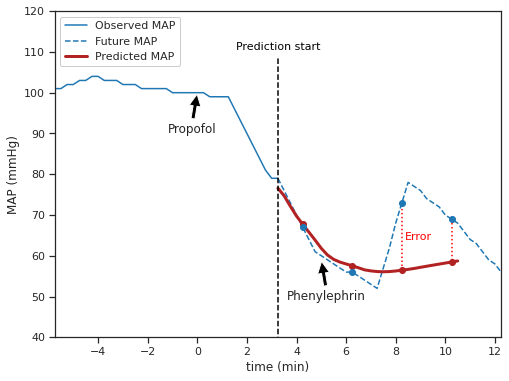

In [39]:
import seaborn as sns
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import data_formatters.base
from sklearn.metrics import mean_squared_error
# Default input types.

sns.set_style("ticks")
    
# Smallest context:
sns.set_context("notebook")
patient_nr = 52
time = int(3.25*4)

model = model
column = 'meanbp'
data_formatter = data_formatter
window_length = 30
hist_length = 32
from IPython.display import clear_output

pred_col_names = []
for i in range(window_length):
    pred_col_names.append('t+'+str(i))

    
fig = figure(figsize=(8, 6))




InputTypes = data_formatters.base.InputTypes
observed_list = []
static_list = []
for ele in model.column_definition:
    if(ele[2]==InputTypes.OBSERVED_INPUT):
        observed_list.append(ele[0])
    if(ele[2]==InputTypes.STATIC_INPUT):
        static_list.append(ele[0])

for ele in model.column_definition:
    if(ele[2]==InputTypes.KNOWN_INPUT):
        observed_list.append(ele[0])
        
for ele in model.column_definition:
    if(ele[2]==InputTypes.TARGET):
        observed_list.append(ele[0])



    

indices = df['rand_id'].unique()
pat_id = indices[patient_nr]

df_pat = df[df['rand_id']==pat_id]
raw_pat = raw_data[raw_data['rand_id']==pat_id]

output_map = model.predict(df_pat)
attention = model.get_attention(df_pat)


predict_p10 = data_formatter.format_predictions(output_map["p10"])
predict_p50 = data_formatter.format_predictions(output_map["p50"])
predict_p90 = data_formatter.format_predictions(output_map["p90"])

df_reset = raw_pat.reset_index()

df_meds = df_reset
input_interact = []
for i, col in enumerate(df_meds.columns):
    
    input_interact.append((col, i))
    try:
        df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
    except:
        pass


  
    
    
predict_p10 = predict_p10[pred_col_names]
predict_p50 = predict_p50[pred_col_names]
predict_p90 = predict_p90[pred_col_names]
targets = raw_pat['meanbp']

x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)


x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

len_pred = len(predict_p10.iloc[0])

x_axis_pred = np.arange(0, len_pred)
plot_error = []

for x in range(len(raw_pat)-(window_length+hist_length)):
    plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))

x_axis_pred = np.arange(time, time + len_pred)
x_axis_attention = np.arange(time-hist_length, time)
x_axis_self_attention = np.arange(time-hist_length, time+window_length)

TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
plt.plot(x_axis[:time+window_length+3]/4., targets[:time+window_length+3], label='Observed MAP', color='C0')
plt.plot(x_axis[time+window_length+2:]/4., targets[time+window_length+2:],  label='Future MAP', color='C0', linestyle='dashed')

plt.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', label='Predicted MAP', linewidth=3.0)


#fig.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center')

plt.ylabel('MAP (mmHg)')
plt.xlabel('time (min)')


plt.vlines(x = time/4., color = 'black', ymin=0, ymax= 109, linestyle="dashed")
plt.vlines(x = time/4.+ 1, color = 'red', ymin=min(predict_p50['t+4'][time], targets.iloc[time+4+window_length+2] ), ymax=max(predict_p50['t+4'][time], targets.iloc[time+4+window_length+2] ), linestyle=":")
plt.vlines(x = time/4.+ 3, color = 'red', ymin=min(predict_p50['t+12'][time], targets.iloc[time+12+window_length+2] ), ymax=max(predict_p50['t+12'][time], targets.iloc[time+12+window_length+2] ), linestyle=":")
plt.vlines(x = time/4.+ 5, color = 'red', ymin=min(predict_p50['t+20'][time], targets.iloc[time+20+window_length+2] ), ymax=max(predict_p50['t+20'][time], targets.iloc[time+20+window_length+2] ), linestyle=":")
plt.vlines(x = time/4.+ 7, color = 'red', ymin=max(predict_p50['t+28'][time], targets.iloc[time+28+window_length+2] ), ymax=min(predict_p50['t+28'][time], targets.iloc[time+28+window_length+2] ), linestyle=":")

print(min(predict_p50['t+28'][time], targets.iloc[time+len_pred+window_length-1+28] ))
print(predict_p50['t+28'][time])
print(targets.iloc[time+len_pred+window_length-1+28])

plt.text(time/4., 110, 'Prediction start',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='black', fontsize=11)

plt.text(time/4.+ 5.1, 63.5, 'Error',
        verticalalignment='bottom',
        horizontalalignment='left',
        color='red', fontsize=11)

plt.plot(time/4. +1 , predict_p50['t+4'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +3 , predict_p50['t+12'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +5 , predict_p50['t+20'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +7 , predict_p50['t+28'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")

plt.plot(time/4. +1 , targets.iloc[time+4+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
plt.plot(time/4. +3 , targets.iloc[time+12+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
plt.plot(time/4. +5 , targets.iloc[time+20+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
plt.plot(time/4. +7 , targets.iloc[time+28+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")

plt.annotate('Propofol',
            xy=(420/60-7, 100), xycoords='data',
            xytext=(-5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.annotate('Phenylephrin',
            xy=(720/60-7, 59), xycoords='data',
            xytext=(5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.xlim([time/4 - 9. ,time/4 +9])
plt.ylim([40. ,120])

plt.legend(loc='upper left', fancybox=True, framealpha=1)   
plt.savefig('TFT_Explain_isextern_'+str(kor)+'.tif')
#plt.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='g', alpha=0.2) 

In [40]:
# import seaborn as sns
# from ipywidgets import *
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.colors as mcolors
# import data_formatters.base
# from sklearn.metrics import mean_squared_error
# # Default input types.

# sns.set_style("ticks")
    
# # Smallest context:
# sns.set_context("notebook")
# patient_nr = 52
# time = int(4*4)
# for time in range(220):
#     model = model
#     column = 'meanbp'
#     data_formatter = data_formatter
#     window_length = 30
#     hist_length = 32
#     from IPython.display import clear_output

#     pred_col_names = []
#     for i in range(window_length):
#         print()
#         pred_col_names.append('t+'+str(i))


#     fig = figure(figsize=(26,6))




#     InputTypes = data_formatters.base.InputTypes
#     observed_list = []
#     static_list = []
#     for ele in model.column_definition:
#         if(ele[2]==InputTypes.OBSERVED_INPUT):
#             observed_list.append(ele[0])
#         if(ele[2]==InputTypes.STATIC_INPUT):
#             static_list.append(ele[0])

#     for ele in model.column_definition:
#         if(ele[2]==InputTypes.KNOWN_INPUT):
#             observed_list.append(ele[0])

#     for ele in model.column_definition:
#         if(ele[2]==InputTypes.TARGET):
#             observed_list.append(ele[0])





#     indices = df['rand_id'].unique()
#     pat_id = indices[patient_nr]

#     df_pat = df[df['rand_id']==pat_id]
#     raw_pat = raw_data[raw_data['rand_id']==pat_id]

#     output_map = model.predict(df_pat)
#     attention = model.get_attention(df_pat)


#     predict_p10 = data_formatter.format_predictions(output_map["p10"])
#     predict_p50 = data_formatter.format_predictions(output_map["p50"])
#     predict_p90 = data_formatter.format_predictions(output_map["p90"])

#     df_reset = raw_pat.reset_index()

#     df_meds = df_reset
#     input_interact = []
#     for i, col in enumerate(df_meds.columns):

#         input_interact.append((col, i))
#         try:
#             df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
#         except:
#             pass





#     predict_p10 = predict_p10[pred_col_names]
#     predict_p50 = predict_p50[pred_col_names]
#     predict_p90 = predict_p90[pred_col_names]
#     targets = raw_pat['meanbp']

#     x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)


#     x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

#     len_pred = len(predict_p10.iloc[0])

#     x_axis_pred = np.arange(0, len_pred)
#     plot_error = []

#     for x in range(len(raw_pat)-(window_length+hist_length)):
#         plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))

#     x_axis_pred = np.arange(time, time + len_pred)
#     x_axis_attention = np.arange(time-hist_length, time)
#     x_axis_self_attention = np.arange(time-hist_length, time+window_length)

#     TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
#     TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
#     TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
#     plt.plot(x_axis[:time+window_length+3]/4., targets[:time+window_length+3], label='Observed MAP', color='C0')
#     plt.plot(x_axis[time+window_length+2:]/4., targets[time+window_length+2:],  label='Future MAP', color='C0', linestyle='dashed')

#     plt.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', label='Predicted MAP', linewidth=3.0)


#     #fig.text(0.98 , 0.68, "P(H): {:,.2f} [{:,.2f}, {:,.2f}]".format(TWA_p50, TWA_p90, TWA_p10) ,  horizontalalignment='right', verticalalignment='center')

#     plt.ylabel('MAP (mmHg)')
#     plt.xlabel('time (min)')


#     plt.vlines(x = time/4., color = 'black', ymin=0, ymax= 109, linestyle="dashed")
#     plt.vlines(x = time/4.+ 1, color = 'red', ymin=min(predict_p50['t+4'][time], targets.iloc[time+4+window_length+2] ), ymax=max(predict_p50['t+4'][time], targets.iloc[time+4+window_length+2] ), linestyle=":")
#     plt.vlines(x = time/4.+ 3, color = 'red', ymin=min(predict_p50['t+12'][time], targets.iloc[time+12+window_length+2] ), ymax=max(predict_p50['t+12'][time], targets.iloc[time+12+window_length+2] ), linestyle=":")
#     plt.vlines(x = time/4.+ 5, color = 'red', ymin=min(predict_p50['t+20'][time], targets.iloc[time+20+window_length+2] ), ymax=max(predict_p50['t+20'][time], targets.iloc[time+20+window_length+2] ), linestyle=":")
#     plt.vlines(x = time/4.+ 7, color = 'red', ymin=max(predict_p50['t+28'][time], targets.iloc[time+28+window_length+2] ), ymax=min(predict_p50['t+28'][time], targets.iloc[time+28+window_length+2] ), linestyle=":")

#     print(min(predict_p50['t+28'][time], targets.iloc[time+len_pred+window_length-1+28] ))
#     print(predict_p50['t+28'][time])
#     print(targets.iloc[time+len_pred+window_length-1+28])

#     plt.text(time/4., 110, 'Prediction start',
#             verticalalignment='bottom',
#             horizontalalignment='center',
#             color='black', fontsize=11)


#     plt.plot(time/4. +1 , predict_p50['t+4'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
#     plt.plot(time/4. +3 , predict_p50['t+12'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
#     plt.plot(time/4. +5 , predict_p50['t+20'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
#     plt.plot(time/4. +7 , predict_p50['t+28'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")

#     plt.plot(time/4. +1 , targets.iloc[time+4+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
#     plt.plot(time/4. +3 , targets.iloc[time+12+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
#     plt.plot(time/4. +5 , targets.iloc[time+20+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")
#     plt.plot(time/4. +7 , targets.iloc[time+28+window_length+2] , marker="o", markersize=6, markeredgecolor="C0", markerfacecolor="C0")



#     plt.ylim([40. ,120])
#     plt.xlim([-8 ,60])

#     plt.legend(loc='upper left', fancybox=True, framealpha=1)   
#     plt.savefig('Gif/TFT_Explain_isextern_'+str(time)+'_'+str(kor)+'.png')
#     plt.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='g', alpha=0.2) 































58
58.466606
58


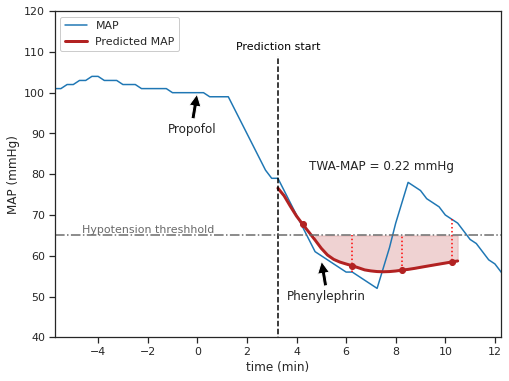

In [41]:
import seaborn as sns
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors
import data_formatters.base
from sklearn.metrics import mean_squared_error
# Default input types.

sns.set_style("ticks")
    
# Smallest context:
sns.set_context("notebook")
patient_nr = 52
time = int(3.25*4)

model = model
column = 'meanbp'
data_formatter = data_formatter
window_length = 30
hist_length = 32
from IPython.display import clear_output

pred_col_names = []
for i in range(window_length):
    print()
    pred_col_names.append('t+'+str(i))

    
fig = figure(figsize=(8, 6))




InputTypes = data_formatters.base.InputTypes
observed_list = []
static_list = []
for ele in model.column_definition:
    if(ele[2]==InputTypes.OBSERVED_INPUT):
        observed_list.append(ele[0])
    if(ele[2]==InputTypes.STATIC_INPUT):
        static_list.append(ele[0])

for ele in model.column_definition:
    if(ele[2]==InputTypes.KNOWN_INPUT):
        observed_list.append(ele[0])
        
for ele in model.column_definition:
    if(ele[2]==InputTypes.TARGET):
        observed_list.append(ele[0])



    

indices = df['rand_id'].unique()
pat_id = indices[patient_nr]

df_pat = df[df['rand_id']==pat_id]
raw_pat = raw_data[raw_data['rand_id']==pat_id]

output_map = model.predict(df_pat)
attention = model.get_attention(df_pat)


predict_p10 = data_formatter.format_predictions(output_map["p10"])
predict_p50 = data_formatter.format_predictions(output_map["p50"])
predict_p90 = data_formatter.format_predictions(output_map["p90"])

df_reset = raw_pat.reset_index()

df_meds = df_reset
input_interact = []
for i, col in enumerate(df_meds.columns):
    
    input_interact.append((col, i))
    try:
        df_meds.loc[:,col] = df_meds[col].where(df_meds[col]>0)
    except:
        pass


  
    
    
predict_p10 = predict_p10[pred_col_names]
predict_p50 = predict_p50[pred_col_names]
predict_p90 = predict_p90[pred_col_names]
targets = raw_pat['meanbp']

x_axis = np.arange(-hist_length,len(raw_pat)-hist_length)


x_axis_error = np.arange(0,len(raw_pat)-(hist_length+window_length))

len_pred = len(predict_p10.iloc[0])

x_axis_pred = np.arange(0, len_pred)
plot_error = []

for x in range(len(raw_pat)-(window_length+hist_length)):
    plot_error.append(mean_squared_error(targets[x+window_length-1:(x+len_pred+window_length-1)],predict_p50.iloc[x]))

x_axis_pred = np.arange(time, time + len_pred)
x_axis_attention = np.arange(time-hist_length, time)
x_axis_self_attention = np.arange(time-hist_length, time+window_length)

TWA_p10, max_loc = calc_TWA(predict_p10.iloc[time], 65.)
TWA_p50, max_loc = calc_TWA(predict_p50.iloc[time], 65.)
TWA_p90, max_loc = calc_TWA(predict_p90.iloc[time], 65.)
plt.plot(x_axis/4., targets, label='MAP')

plt.plot(x_axis_pred/4., predict_p50.iloc[time], color='firebrick', label='Predicted MAP', linewidth=3.0)


plt.ylabel('MAP (mmHg)')
plt.xlabel('time (min)')


plt.vlines(x = time/4., color = 'black', ymin=0, ymax= 109, linestyle="dashed")
plt.vlines(x = time/4.+ 1, color = 'red', ymin=min(predict_p50['t+4'][time], targets.iloc[time+4+window_length+2] ), ymax=max(predict_p50['t+4'][time],65.), linestyle=":")
plt.vlines(x = time/4.+ 3, color = 'red', ymin=min(predict_p50['t+12'][time], targets.iloc[time+12+window_length+2] ), ymax=max(predict_p50['t+12'][time], 65.), linestyle=":")
plt.vlines(x = time/4.+ 5, color = 'red', ymin=min(predict_p50['t+20'][time], targets.iloc[time+20+window_length+2] ), ymax=max(predict_p50['t+20'][time],65. ), linestyle=":")
plt.vlines(x = time/4.+ 7, color = 'red', ymin=max(predict_p50['t+28'][time], targets.iloc[time+28+window_length+2] ), ymax=min(predict_p50['t+28'][time],65. ), linestyle=":")

print(min(predict_p50['t+28'][time], targets.iloc[time+len_pred+window_length-1+28] ))
print(predict_p50['t+28'][time])
print(targets.iloc[time+len_pred+window_length-1+28])


plt.text(4.5 , 82., "TWA-MAP = {:,.2f} mmHg".format(TWA_p50) ,  horizontalalignment='left', verticalalignment='center')

plt.text(time/4., 110, 'Prediction start',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='black', fontsize=11)


plt.plot(time/4. +1 , predict_p50['t+4'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +3 , predict_p50['t+12'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +5 , predict_p50['t+20'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")
plt.plot(time/4. +7 , predict_p50['t+28'][time], marker="o", markersize=6, markeredgecolor="firebrick", markerfacecolor="firebrick")

plt.text(-2, 65, 'Hypotension threshhold',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='dimgray', fontsize=11)


plt.annotate('Propofol',
            xy=(420/60-7, 100), xycoords='data',
            xytext=(-5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.annotate('Phenylephrin',
            xy=(720/60-7, 59), xycoords='data',
            xytext=(5, -30), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.axhline(y = 65., color = 'dimgray', linestyle="dashdot")

plt.fill_between(x_axis_pred/4., predict_p50.iloc[time], 65., color='firebrick', where=(predict_p50.iloc[time] <= 65.), alpha=0.2) 



plt.xlim([time/4 - 9. ,time/4 +9])
plt.ylim([40. ,120])

plt.legend(loc='upper left', fancybox=True, framealpha=1) 
plt.savefig('TFT_TWA_isextern_'+str(kor)+'.tif')
#plt.fill_between(x_axis_pred/4., predict_p10.iloc[time], predict_p90.iloc[time], color='g', alpha=0.2)

In [42]:
def shift_index(df, columns, periods):
    group = df.groupby('rand_id')     
    df[columns] = group[columns].shift(periods=periods, fill_value=0)
    #df.loc[:, columns] = group[columns].shift(periods=periods, fill_value=0)
    return df

In [43]:
def remove_rows(group, front, end):
    return group.iloc[front:-end]

In [44]:
def get_test(df, ids, front, end):
    filtered_df = df[df['rand_id'].isin(ids)]
    grouped = filtered_df.groupby('rand_id')
    
    df_new = grouped.apply(remove_rows, front, end).reset_index(drop=True)
        
    return df_new


In [73]:
prediction_time = 20
label_time = 't+'+str(prediction_time)

In [74]:


ids = df['rand_id'].unique()
ids = ids[:1000]

df_pat = df[df['rand_id'].isin(ids)]
raw_pat = get_test(raw_data, ids, window_length, hist_length-1)
raw_pat.loc[:,['hypotension65']] = raw_pat.loc[:,['hypotension65']].replace(False, 0, regex=True)
raw_pat.loc[:,['hypotension65']] = raw_pat.loc[:,['hypotension65']].replace(True, 1, regex=True)
shift = shift_index(raw_pat, 'hypotension65', -prediction_time )
y_test = shift['hypotension65']

In [75]:
output_map = model.predict(df_pat)



predict_p10 = data_formatter.format_predictions(output_map["p10"])
predict_p50 = data_formatter.format_predictions(output_map["p50"])
predict_p90 = data_formatter.format_predictions(output_map["p90"])

In [76]:
y_pred = predict_p50[label_time]<65.

In [77]:
prob_pos = estimate_probability_timestep(predict_p10, predict_p50, predict_p90, 65., prediction_time)

In [78]:
y_pred

0         False
1         False
2         False
3         False
4         False
          ...  
429819    False
429820    False
429821    False
429822    False
429823    False
Name: t+20, Length: 429824, dtype: bool

In [79]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# compute sensitivity and specificity'
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Sensitivity: 0.4632228459413704
Specificity: 0.9607359221888542


In [80]:
# Sensitivity: 0.35799462928405623
# Specificity: 0.9650022545752328

In [81]:
from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=20)

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, prob_pos)

# Calculate the AUROC score
auroc = roc_auc_score(y_test, prob_pos)

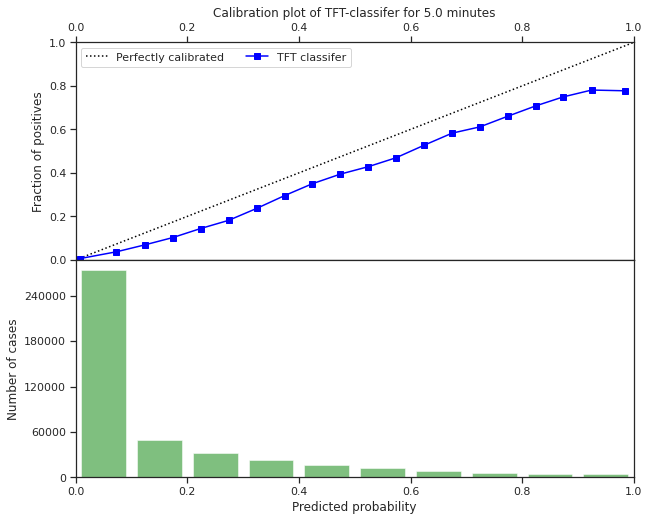

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

# Figure 1 for Calibration curve and Histogram
fig1 = plt.figure(figsize=(10, 8)) # Set the overall figure size

gs1 = plt.GridSpec(2, 1, height_ratios=[1, 1]) # Set height ratios to 1:1 for equal vertical size

# Calibration curve
ax1 = plt.subplot(gs1[0])
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")  
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % 'TFT classifer', color='blue')
ax1.set_xlim([0, 1]) # Set x range to 0 to 1
ax1.set_ylim([0, 1]) # Set y range to 0 to 1
ax1.set_ylabel("Fraction of positives")
ax1.set_title('Calibration plot of TFT-classifer for '+str(prediction_time/4.)+' minutes')
ax1.legend(loc="upper left")
ax1.xaxis.tick_top() # Move x-axis labels to top
ax1.xaxis.set_label_position('top') # Move x-axis label to top

# Position legend of plot 1 on x-axis
handles, labels_plot = ax1.get_legend_handles_labels()
ax1.legend(handles, labels_plot,  ncol=2)

# Histogram as an "inset" plot
ax2 = plt.subplot(gs1[1], sharex=ax1) # Sharing x-axis with first plot
hist, bins = np.histogram(prob_pos, bins=10, range=(0, 1))
width = (bins[1] - bins[0]) * 0.8
centers = (bins[:-1] + bins[1:]) / 2
ax2.bar(centers, hist, align='center', width=width, alpha=0.5, color='green', label='Histogram')
ax2.set_xlabel("Predicted probability") # Add x-axis label
ax2.set_ylabel("Number of cases")



ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.subplots_adjust(hspace=0)  



plt.savefig('TFT_preformance_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

In [84]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_tprs = []
bootstrapped_auc = []

base_fpr = np.linspace(0, 1, 101)  # Fix the FPR values for interpolation

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(prob_pos), len(prob_pos))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    fpr_boot, tpr_boot, _ = roc_curve(y_test[indices], prob_pos[indices])
    bootstrapped_auc.append(auc(fpr_boot, tpr_boot))

    # Interpolate TPR for the fixed FPR value
    tpr_boot_interp = interp(base_fpr, fpr_boot, tpr_boot)
    bootstrapped_tprs.append(tpr_boot_interp)

# Convert list to a 2D array
bootstrapped_tprs = np.array(bootstrapped_tprs)

# Compute the lower and upper bound of the ROC curve
tprs_lower = np.percentile(bootstrapped_tprs, 2.5, axis=0)
tprs_upper = np.percentile(bootstrapped_tprs, 97.5, axis=0)

# Compute the lower and upper bound of the ROC AUC
auc_lower = np.percentile(bootstrapped_auc, 2.5)
auc_upper = np.percentile(bootstrapped_auc, 97.5)



In [85]:
base_path = '/home/fs71801/lkapral66/Transformer/tft_tf2'
# Construct the full path to the .npz file
identifier = f"TFT_{prediction_time/4}_{kor}"

file_path = os.path.join(base_path, identifier + '.npz')

np.savez(file_path,
         bootstrapped_tprs=bootstrapped_tprs,
         tprs_lower=tprs_lower,
         tprs_upper=tprs_upper,
         auc_lower=auc_lower,
         auc_upper=auc_upper,
         base_fpr=base_fpr,
         prob_pos=prob_pos,
         y_test=y_test,
         y_pred=y_pred
        )


print("Confidence interval for the ROC curve: [{:0.3f} - {:0.3}]".format(auc_lower, auc_upper))

Confidence interval for the ROC curve: [0.908 - 0.911]


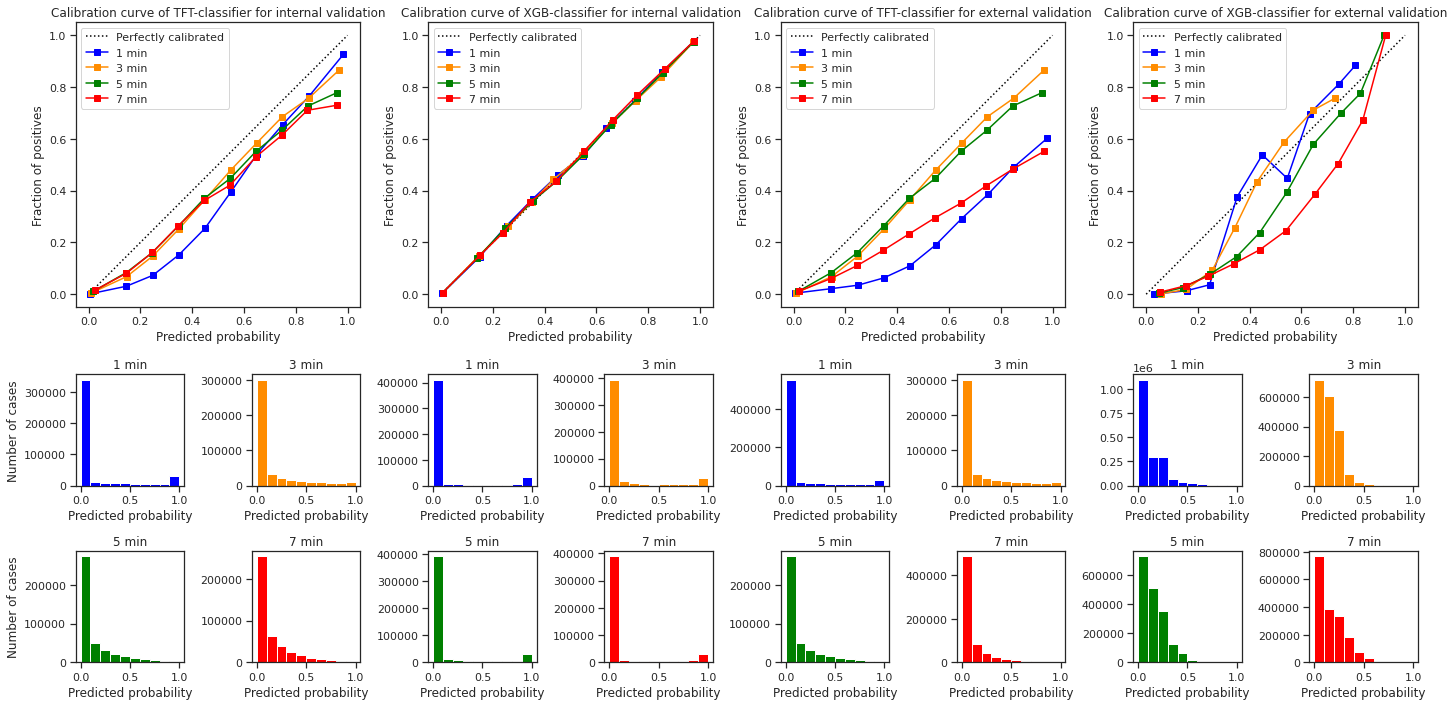

In [145]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import os
from sklearn.calibration import CalibrationDisplay

# Assuming you have the same setup as before:
classifiers = ['TFT', 'XGB']
prediction_times = [4, 12, 20, 28]
kor_values = [False, True]
colors = ['blue', 'darkorange', 'green', 'red']
base_path = '/home/fs71801/lkapral66/Transformer/tft_tf2'

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 8)

# Create the main calibration curve plots
for col, clf in enumerate(classifiers):
    for row, kor in enumerate(kor_values):
        ax_calibration_curve = fig.add_subplot(gs[:2, 2*(col)+4*row:2*(col)+2+4*row:])
        for pred_time, color in zip(prediction_times, colors):
            identifier = f"{clf}_{pred_time/4}_{kor}"
            file_path = os.path.join(base_path, identifier + '.npz')
            data = np.load(file_path)
            y_test = data['y_test']
            prob_pos = data['prob_pos']
            CalibrationDisplay.from_predictions(y_test, prob_pos, n_bins=10, ax=ax_calibration_curve, color=color)
        ax_calibration_curve.set_aspect('equal')
        ax_calibration_curve.set_title(f"Calibration curve of {clf}-classifier for {'external validation' if kor else 'internal validation'}")
        ax_calibration_curve.set_xlabel("Predicted probability")
        ax_calibration_curve.set_ylabel("Fraction of positives")
        ax_calibration_curve.legend(['Perfectly calibrated','1 min','3 min','5 min','7 min'])
        
# Create the histogram plots
for col, clf in enumerate(classifiers):
    for row, kor in enumerate(kor_values):
        for i, pred_time in enumerate(prediction_times):
            ax = fig.add_subplot(gs[2 + i//2, 2*(col)+4*row + i%2])
            identifier = f"{clf}_{pred_time/4}_{kor}"
            file_path = os.path.join(base_path, identifier + '.npz')
            data = np.load(file_path)
            prob_pos = data['prob_pos']
            ax.hist(prob_pos, range=(0, 1), bins=10, color=colors[i])
            ax.set_title(f"{round(pred_time/4)} min")
            ax.set_xlabel("Predicted probability")
            if(row==0 and col==0 and (pred_time==4 or pred_time==20 )):
                ax.set_ylabel("Number of cases")

plt.tight_layout()
fig.savefig('Performance.pdf', format='pdf')


plt.show()



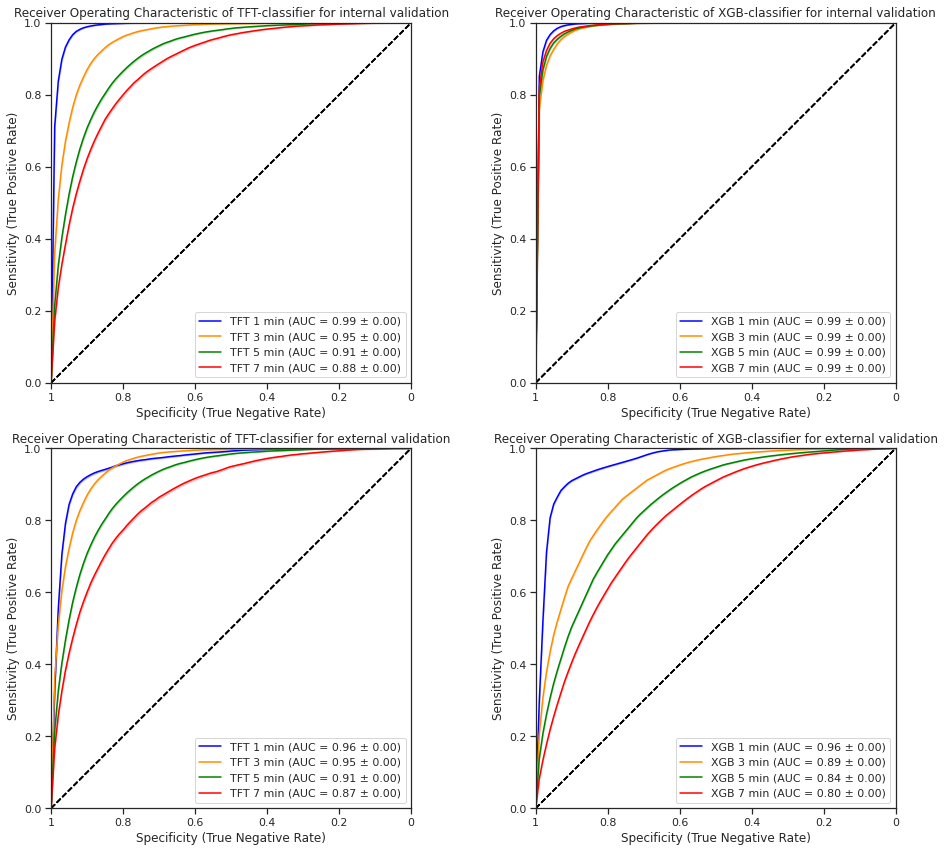

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

sns.set_style("ticks")
sns.set_context("notebook")

base_path = '/home/fs71801/lkapral66/Transformer/tft_tf2'

classifiers = ['TFT', 'XGB']
prediction_times = [4, 12, 20, 28]
kors = [False, True]
colors = ['blue', 'darkorange', 'green', 'red']  # Colors for the respective prediction times

fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Create a 2x2 grid of subplots

for i, kor in enumerate(kors):
    for j, clf in enumerate(classifiers):
        ax = axes[i, j]
        ax.set_aspect('equal')
        for pred_time, color in zip(prediction_times, colors):
            identifier = f"{clf}_{pred_time/4}_{kor}"
            file_path = os.path.join(base_path, identifier + '.npz')
            data = np.load(file_path)
            bootstrapped_tprs = data['bootstrapped_tprs']
            tprs_lower = data['tprs_lower']
            tprs_upper = data['tprs_upper']
            auc_lower = data['auc_lower']
            auc_upper = data['auc_upper']
            y_test = data['y_test']
            y_pred = data['y_pred']
            prob_pos=  data['prob_pos']
        
            auroc = np.mean([auc_lower, auc_upper])
            specificity = 1 - data['base_fpr']  # Assuming base_fpr is saved in the .npz
            
            ax.plot([1, 0], [0, 1], 'k--')  # Invert x-axis
            ax.plot(specificity, np.median(bootstrapped_tprs, axis=0), label=f'{clf} {round(pred_time/4)} min (AUC = {auroc:.2f} ± {(auc_upper-auc_lower)/2:.2f})', color=color)
            ax.fill_between(specificity, tprs_lower, tprs_upper, color=color, alpha=0.2)
            
            ax.set_xlabel('Specificity (True Negative Rate)')
            ax.set_ylabel('Sensitivity (True Positive Rate)')
            ax.set_title(f"Receiver Operating Characteristic of {clf}-classifier for {'external validation' if kor else 'internal validation'}")
            ax.legend(loc='lower right')
            ax.set_xlim([1, 0])  # Invert x-axis limits
            ax.set_ylim([0, 1])
            ax.set_xticks([1,0.8,0.6,0.4,0.2,0])  # Set x-axis tick locations
            ax.set_xticklabels([1,0.8,0.6,0.4,0.2,0])  # Set x-axis tick labels

# Adjust the layout
plt.tight_layout()


fig.savefig('ROC.pdf', format='pdf')
# Display the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm
from joblib import Parallel, delayed

def compute_metrics(indices):
    bootstrap_y_test = y_test[indices]
    bootstrap_y_pred = y_pred[indices]
    bootstrap_prob_pos = prob_pos[indices]

    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)
    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)
    npv = precision_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    auroc = roc_auc_score(bootstrap_y_test, bootstrap_prob_pos)
    accuracy = accuracy_score(bootstrap_y_test, bootstrap_y_pred)
    
    return sensitivity, specificity, ppv, npv, auroc, accuracy

# Parallel processing
n_jobs = -1  # this will use all the available cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_metrics)(resample(range(len(y_pred)), replace=True)) for i in range(2000))

sensitivity_values, specificity_values, ppv_values, npv_values, auroc_values, accuracy_values = zip(*results)

# Calculate confidence intervals
confidence_interval = 0.95
alpha = (1 - confidence_interval) / 2
lower_percentile = alpha * 100
upper_percentile = (1 - alpha) * 100

# Calculate confidence intervals for each metric
sensitivity_ci = np.percentile(sensitivity_values, [lower_percentile, upper_percentile])
specificity_ci = np.percentile(specificity_values, [lower_percentile, upper_percentile])
ppv_ci = np.percentile(ppv_values, [lower_percentile, upper_percentile])
npv_ci = np.percentile(npv_values, [lower_percentile, upper_percentile])
auroc_ci = np.percentile(auroc_values, [lower_percentile, upper_percentile])
accuracy_ci = np.percentile(accuracy_values, [lower_percentile, upper_percentile])


with open("metrics_TFT_"+str(prediction_time/4.)+'_isextern_'+str(kor)+".txt", "w") as file:
    file.write("Accuracy: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(accuracy_values), accuracy_ci[0], accuracy_ci[1]))
    file.write("Sensitivity: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(sensitivity_values), sensitivity_ci[0], sensitivity_ci[1]))
    file.write("Specificity: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(specificity_values), specificity_ci[0], specificity_ci[1]))
    file.write("Positive Predictive Value (PPV): {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(ppv_values), ppv_ci[0], ppv_ci[1]))
    file.write("Negative Predictive Value (NPV): {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(npv_values), npv_ci[0], npv_ci[1]))
    file.write("Area Under the ROC Curve (AUROC): {:.3f} ({:.3f}-{:.3f})".format(np.mean(auroc_values), auroc_ci[0], auroc_ci[1]))

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score



ids = df['rand_id'].unique()
ids = ids[:1000]

# Initialize a list to store the AUROC scores


# Filter df for the current set of ids
df_pat = df[df['rand_id'].isin(ids)]

# Get the test data for the current set of ids
raw_pat = get_test(raw_data, ids, window_length, hist_length-1)
raw_pat.loc[:,['hypotension65']] = raw_pat.loc[:,['hypotension65']].replace(False, 0, regex=True)
raw_pat.loc[:,['hypotension65']] = raw_pat.loc[:,['hypotension65']].replace(True, 1, regex=True)

output_map = model.predict(df_pat)
# Adjust the prediction formatting based on the current prediction_time
predict_p10 = data_formatter.format_predictions(output_map["p10"])
predict_p50 = data_formatter.format_predictions(output_map["p50"])
predict_p90 = data_formatter.format_predictions(output_map["p90"])
y_pred = predict_p50[label_time] < 65.



t+0
t+1
t+2
t+3
t+4
t+5
t+6
t+7
t+8
t+9
t+10
t+11
t+12
t+13
t+14
t+15
t+16
t+17
t+18
t+19
t+20
t+21
t+22
t+23
t+24
t+25
t+26
t+27
t+28


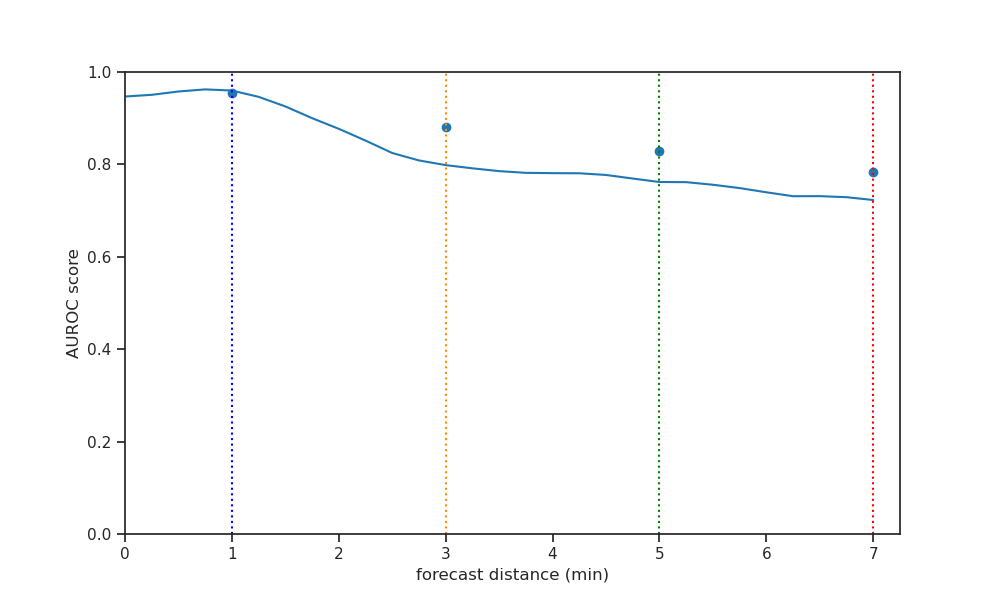

In [57]:
# Loop over prediction times from 0 to 28


sns.set_style("ticks")
    
# Smallest context:
sns.set_context("notebook")
# Get the unique id





plt.figure(figsize=(10, 6))
auroc_scores = []

for prediction_time in range(29):
    label_time = 't+' + str(prediction_time)
    
    print(label_time)
    


    # Adjust the shifting based on the current prediction_time
    shift = shift_index(raw_pat, 'hypotension65', -prediction_time)
    y_test = shift['hypotension65']

    prob_pos = estimate_probability_timestep(predict_p10, predict_p50, predict_p90, 65., prediction_time)

    # Calculate the AUROC score and append to the list
    auroc = roc_auc_score(y_test, prob_pos)
    auroc_scores.append(auroc)

# Plotting the AUROC scores
plt.plot(np.arange(0, 7.25 , 0.25), auroc_scores)

if(kor):
    xgb_roc = [0.954, 0.882, 0.830, 0.784]
else:
    xgb_roc = [0.994, 0.987, 0.989 , 0.991]

plt.axvline(x=1, color='blue', linestyle=":", label='1 min')
plt.axvline(x=3, color='darkorange', linestyle=":", label='3 min')
plt.axvline(x=5, color='green', linestyle=":", label='5 min')
plt.axvline(x=7, color='red', linestyle=":", label='7 min')

plt.scatter([1,3,5,7], xgb_roc)

plt.xlabel('forecast distance (min)')
plt.ylabel('AUROC score')
plt.xlim([0,7.25])
plt.ylim([0,1])

plt.grid(False)
plt.show()

In [58]:
auroc_scores

[0.9468998480289319,
 0.9506177284075612,
 0.957803512933381,
 0.9623688459689536,
 0.9598466686541081,
 0.9462151410620605,
 0.9254886549553063,
 0.900117780585053,
 0.8770125352528786,
 0.8515426850049665,
 0.8246516965809555,
 0.8085948448443805,
 0.7984407687667321,
 0.7915034926463747,
 0.7854422906905952,
 0.7817386026980042,
 0.7810618238344471,
 0.7807869259708182,
 0.7771408618803863,
 0.7693814061668673,
 0.7619236342068512,
 0.7615659286012221,
 0.7559505250680134,
 0.748722519022173,
 0.739646713659567,
 0.7311513931753342,
 0.7312717349969848,
 0.7290374479953452,
 0.722882644805105]

In [59]:
'''
import numpy as np
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
from sklearn.utils import resample
from tqdm import tqdm
# Define the number of bootstrap samples
n_bootstrap = 2000

# Create empty lists to store bootstrapped metrics
sensitivity_values = []
specificity_values = []
ppv_values = []
npv_values = []
auroc_values = []
accuracy_values = []



# Perform bootstrap resampling
for i in tqdm(range(n_bootstrap)):
    print()
    # Sample with replacement from the predictions
    indices = resample(range(len(y_pred)), replace=True)
    bootstrap_y_test = y_test[indices]
    bootstrap_y_pred = y_pred[indices]
    bootstrap_prob_pos = prob_pos[indices]

    # Calculate metrics for the bootstrap sample
    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)
    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)
    npv = precision_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)
    auroc = roc_auc_score(bootstrap_y_test, bootstrap_prob_pos)
    accuracy = accuracy_score(bootstrap_y_test, bootstrap_y_pred)

    # Append the metric values to the lists
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)
    ppv_values.append(ppv)
    npv_values.append(npv)
    auroc_values.append(auroc)
    accuracy_values.append(accuracy)

# Calculate confidence intervals
confidence_interval = 0.95
alpha = (1 - confidence_interval) / 2
lower_percentile = alpha * 100
upper_percentile = (1 - alpha) * 100

# Calculate confidence intervals for each metric
sensitivity_ci = np.percentile(sensitivity_values, [lower_percentile, upper_percentile])
specificity_ci = np.percentile(specificity_values, [lower_percentile, upper_percentile])
ppv_ci = np.percentile(ppv_values, [lower_percentile, upper_percentile])
npv_ci = np.percentile(npv_values, [lower_percentile, upper_percentile])
auroc_ci = np.percentile(auroc_values, [lower_percentile, upper_percentile])
accuracy_ci = np.percentile(accuracy_values, [lower_percentile, upper_percentile])


with open("metrics_TFT_"+str(prediction_time/4.)+'_isextern_'+str(kor)+".txt", "w") as file:
    file.write("Accuracy: {:.3f} ({:.3f}-{:.3f})\n".format(np.mean(accuracy_values), accuracy_ci[0], accuracy_ci[1]))
    file.write("Sensitivity: {:.3f} ({:.3f}-{:.3f})\n".format(sensitivity, sensitivity_ci[0], sensitivity_ci[1]))
    file.write("Specificity: {:.3f} ({:.3f}-{:.3f})\n".format(specificity, specificity_ci[0], specificity_ci[1]))
    file.write("Positive Predictive Value (PPV): {:.3f} ({:.3f}-{:.3f})\n".format(ppv, ppv_ci[0], ppv_ci[1]))
    file.write("Negative Predictive Value (NPV): {:.3f} ({:.3f}-{:.3f})\n".format(npv, npv_ci[0], npv_ci[1]))
    file.write("Area Under the ROC Curve (AUROC): {:.3f} ({:.3f}-{:.3f})".format(auroc, auroc_ci[0], auroc_ci[1]))

'''

'\nimport numpy as np\nfrom sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score\nfrom sklearn.utils import resample\nfrom tqdm import tqdm\n# Define the number of bootstrap samples\nn_bootstrap = 2000\n\n# Create empty lists to store bootstrapped metrics\nsensitivity_values = []\nspecificity_values = []\nppv_values = []\nnpv_values = []\nauroc_values = []\naccuracy_values = []\n\n\n\n# Perform bootstrap resampling\nfor i in tqdm(range(n_bootstrap)):\n    print()\n    # Sample with replacement from the predictions\n    indices = resample(range(len(y_pred)), replace=True)\n    bootstrap_y_test = y_test[indices]\n    bootstrap_y_pred = y_pred[indices]\n    bootstrap_prob_pos = prob_pos[indices]\n\n    # Calculate metrics for the bootstrap sample\n    sensitivity = recall_score(bootstrap_y_test, bootstrap_y_pred)\n    specificity = recall_score(bootstrap_y_test, bootstrap_y_pred, pos_label=0)\n    ppv = precision_score(bootstrap_y_test, bootstrap_y_pred)\n  

In [122]:
t_ls = ['t+0', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       't+24', 't+25', 't+26', 't+27', 't+28', 't+29']

In [123]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Group by 'rand_id' for faster access
grouped = df.groupby('rand_id')

# Initialize difference lists
difference_lists = {f'error_{col}': [] for col in t_ls}

valid_patients = 0
for pat_id, df_pat in tqdm(grouped):
    if df_pat.shape[0] < 64:
        continue

    valid_patients += 1
    output_map = model.predict(df_pat)
    predict_p50 = data_formatter.format_predictions(output_map["p50"])
    predict_p50_values = predict_p50[t_ls].copy()

    for i, col in enumerate(t_ls):
        error_col = f'error_{col}'
        difference = abs(predict_p50_values['t+0'].shift(-i) - predict_p50_values[col])
        difference_value = np.nanmean(difference.values, axis=0)
        if not np.isnan(difference_value):
            difference_lists[error_col].append(difference_value)

# Calculate the mean and standard deviation for each list
mae_values_mean = {col: np.mean(differences) for col, differences in difference_lists.items()}
mae_values_std = {col: np.std(differences) for col, differences in difference_lists.items()}

print(mae_values_mean)
print(mae_values_std)

mean_value = sum(mae_values_mean.values()) / len(mae_values_mean)
print(mean_value)

  0%|          | 7/8113 [00:03<44:19,  3.05it/s]  /tmp/ipykernel_1188044/3087327464.py:24: RuntimeWarning: Mean of empty slice
  difference_value = np.nanmean(difference.values, axis=0)
  1%|          | 43/8113 [00:16<55:37,  2.42it/s]  /tmp/ipykernel_1188044/3087327464.py:24: RuntimeWarning: Mean of empty slice
  difference_value = np.nanmean(difference.values, axis=0)
  1%|          | 58/8113 [00:21<50:07,  2.68it/s]/tmp/ipykernel_1188044/3087327464.py:24: RuntimeWarning: Mean of empty slice
  difference_value = np.nanmean(difference.values, axis=0)
  1%|          | 97/8113 [00:34<41:16,  3.24it/s]  /tmp/ipykernel_1188044/3087327464.py:24: RuntimeWarning: Mean of empty slice
  difference_value = np.nanmean(difference.values, axis=0)
  2%|▏         | 158/8113 [00:53<40:32,  3.27it/s]  /tmp/ipykernel_1188044/3087327464.py:24: RuntimeWarning: Mean of empty slice
  difference_value = np.nanmean(difference.values, axis=0)
  3%|▎         | 257/8113 [01:23<27:49,  4.71it/s]  /tmp/ipykernel_

{'error_t+0': 0.0, 'error_t+1': 0.71792775, 'error_t+2': 1.0472739, 'error_t+3': 1.3609337, 'error_t+4': 1.6763549, 'error_t+5': 1.9983277, 'error_t+6': 2.320307, 'error_t+7': 2.6431909, 'error_t+8': 2.9686358, 'error_t+9': 3.296847, 'error_t+10': 3.6180892, 'error_t+11': 3.930322, 'error_t+12': 4.2271595, 'error_t+13': 4.50244, 'error_t+14': 4.7574434, 'error_t+15': 4.9937773, 'error_t+16': 5.2103915, 'error_t+17': 5.4104185, 'error_t+18': 5.592726, 'error_t+19': 5.761153, 'error_t+20': 5.906553, 'error_t+21': 6.0399795, 'error_t+22': 6.1672354, 'error_t+23': 6.2855477, 'error_t+24': 6.3945746, 'error_t+25': 6.498969, 'error_t+26': 6.5950823, 'error_t+27': 6.688734, 'error_t+28': 6.7752504, 'error_t+29': 6.856976}
{'error_t+0': 0.0, 'error_t+1': 0.8346762, 'error_t+2': 1.12824, 'error_t+3': 1.3473468, 'error_t+4': 1.529218, 'error_t+5': 1.6861075, 'error_t+6': 1.8211851, 'error_t+7': 1.9452547, 'error_t+8': 2.0652702, 'error_t+9': 2.1809657, 'error_t+10': 2.2945485, 'error_t+11': 2.40

In [135]:
# mae_values_mean = {'error_t+0': 0.0,
#  'error_t+1': 1.318585,
#  'error_t+2': 1.9291351,
#  'error_t+3': 2.5389037,
#  'error_t+4': 3.121905,
#  'error_t+5': 3.7068,
#  'error_t+6': 4.2610307,
#  'error_t+7': 4.7915306,
#  'error_t+8': 5.2927637,
#  'error_t+9': 5.7740397,
#  'error_t+10': 6.221502,
#  'error_t+11': 6.6464834,
#  'error_t+12': 7.036655,
#  'error_t+13': 7.399653,
#  'error_t+14': 7.73042,
#  'error_t+15': 8.035705,
#  'error_t+16': 8.3127775,
#  'error_t+17': 8.569899,
#  'error_t+18': 8.804555,
#  'error_t+19': 9.022309,
#  'error_t+20': 9.22257,
#  'error_t+21': 9.413742,
#  'error_t+22': 9.590067,
#  'error_t+23': 9.753796,
#  'error_t+24': 9.903499,
#  'error_t+25': 10.043792,
#  'error_t+26': 10.172164,
#  'error_t+27': 10.291298,
#  'error_t+28': 10.400299,
#  'error_t+29': 10.502324}

In [136]:
# mae_values_std = {'error_t+0': 0.0,
#  'error_t+1': 0.71438754,
#  'error_t+2': 0.93471473,
#  'error_t+3': 1.1285805,
#  'error_t+4': 1.3106022,
#  'error_t+5': 1.492441,
#  'error_t+6': 1.6636953,
#  'error_t+7': 1.8332499,
#  'error_t+8': 2.0000374,
#  'error_t+9': 2.1592603,
#  'error_t+10': 2.3124452,
#  'error_t+11': 2.4609246,
#  'error_t+12': 2.600521,
#  'error_t+13': 2.7296462,
#  'error_t+14': 2.8516066,
#  'error_t+15': 2.965349,
#  'error_t+16': 3.0692053,
#  'error_t+17': 3.1657279,
#  'error_t+18': 3.2546804,
#  'error_t+19': 3.3372884,
#  'error_t+20': 3.4139247,
#  'error_t+21': 3.483747,
#  'error_t+22': 3.5474296,
#  'error_t+23': 3.6049697,
#  'error_t+24': 3.6598148,
#  'error_t+25': 3.7105973,
#  'error_t+26': 3.758359,
#  'error_t+27': 3.8023238,
#  'error_t+28': 3.843682,
#  'error_t+29': 3.8806057}

In [139]:
# mae_values_mean = {'error_t+0': 0.0,
#  'error_t+1': 0.71792775,
#  'error_t+2': 1.0472739,
#  'error_t+3': 1.3609337,
#  'error_t+4': 1.6763549,
#  'error_t+5': 1.9983277,
#  'error_t+6': 2.320307,
#  'error_t+7': 2.6431909,
#  'error_t+8': 2.9686358,
#  'error_t+9': 3.296847,
#  'error_t+10': 3.6180892,
#  'error_t+11': 3.930322,
#  'error_t+12': 4.2271595,
#  'error_t+13': 4.50244,
#  'error_t+14': 4.7574434,
#  'error_t+15': 4.9937773,
#  'error_t+16': 5.2103915,
#  'error_t+17': 5.4104185,
#  'error_t+18': 5.592726,
#  'error_t+19': 5.761153,
#  'error_t+20': 5.906553,
#  'error_t+21': 6.0399795,
#  'error_t+22': 6.1672354,
#  'error_t+23': 6.2855477,
#  'error_t+24': 6.3945746,
#  'error_t+25': 6.498969,
#  'error_t+26': 6.5950823,
#  'error_t+27': 6.688734,
#  'error_t+28': 6.7752504,
#  'error_t+29': 6.856976}

In [140]:
# mae_values_std = {'error_t+0': 0.0,
#  'error_t+1': 0.8346762,
#  'error_t+2': 1.12824,
#  'error_t+3': 1.3473468,
#  'error_t+4': 1.529218,
#  'error_t+5': 1.6861075,
#  'error_t+6': 1.8211851,
#  'error_t+7': 1.9452547,
#  'error_t+8': 2.0652702,
#  'error_t+9': 2.1809657,
#  'error_t+10': 2.2945485,
#  'error_t+11': 2.4049428,
#  'error_t+12': 2.5138497,
#  'error_t+13': 2.6173873,
#  'error_t+14': 2.7172785,
#  'error_t+15': 2.8113444,
#  'error_t+16': 2.8981848,
#  'error_t+17': 2.9826298,
#  'error_t+18': 3.0615292,
#  'error_t+19': 3.1418445,
#  'error_t+20': 3.1787903,
#  'error_t+21': 3.231008,
#  'error_t+22': 3.2890775,
#  'error_t+23': 3.3453388,
#  'error_t+24': 3.3993387,
#  'error_t+25': 3.4503613,
#  'error_t+26': 3.5003135,
#  'error_t+27': 3.547356,
#  'error_t+28': 3.5961998,
#  'error_t+29': 3.6432967}

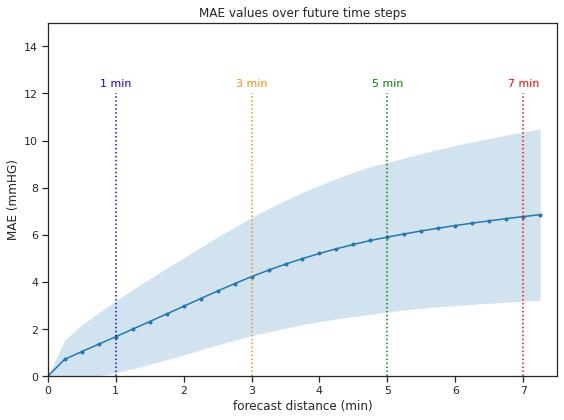

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting time steps and corresponding MAE values
time_steps = list(mae_values_mean.keys())
mae_values = list(mae_values_mean.values())
std_values = list(mae_values_std.values())

# Transforming time steps to minutes
minutes = [int(step.split('+')[-1]) / 4 for step in time_steps]

# Plotting
plt.figure(figsize=(8, 6))

plt.plot(minutes, mae_values, marker='.', linestyle='-')

lower_bound = [mae - std for mae, std in zip(mae_values, std_values)]
upper_bound = [mae + std for mae, std in zip(mae_values, std_values)]


plt.vlines(x = 1, color = 'blue', ymin=0, ymax= 12, linestyle=":")
plt.vlines(x = 3, color = 'darkorange', ymin=0, ymax=12 , linestyle=":")
plt.vlines(x = 5, color = 'green', ymin= 0, ymax=12 , linestyle=":")
plt.vlines(x = 7, color = 'red', ymin= 0, ymax=12 , linestyle=":")

plt.text(1, 12.2, '1 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='blue', fontsize=11)

plt.text(3, 12.2, '3 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='darkorange', fontsize=11)

plt.text(5, 12.2, '5 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='green', fontsize=11)

plt.text(7, 12.2, '7 min',
        verticalalignment='bottom',
        horizontalalignment='center',
        color='red', fontsize=11)

plt.fill_between(minutes, lower_bound, upper_bound, alpha=0.2)

plt.title("MAE values over future time steps")
plt.xlabel("forecast distance (min)")
plt.ylabel("MAE (mmHG)")
plt.ylim([0, 15])
plt.xlim([0, 7.5])
plt.grid(False)

plt.tight_layout()
plt.savefig('MAE_over_future' + '_isextern_' + 'False' + '.pdf', format='pdf' )
plt.show()


In [66]:
from tqdm import tqdm
import numpy as np

indices = df['rand_id'].unique()

average = np.zeros((1500, 5))
count = np.zeros((1500, 5))

average_hypotension = np.zeros((1500, 5))
count_hypotension = np.zeros((1500, 5))

average_hypertension = np.zeros((1500, 5))
count_hypertension = np.zeros((1500, 5))

means = np.zeros((len(indices), 4))
stds = np.zeros((len(indices), 4))
hypotension = np.zeros((len(indices), 1))
hypertension = np.zeros((len(indices), 1))

for i, pat_id in tqdm(enumerate(indices)):
    
    df_pat = df[df['rand_id']==pat_id]
    if(df_pat.shape[0]<62):
        continue
    output_map = model.predict(df_pat)
    predict_p50 = data_formatter.format_predictions(output_map["p50"])
    #hypotension[i, :]  = df_pat.lt(65.).any().any()
    #label[i, :]  = df.sum().sum() > 1
    
    # Convert DataFrame to Numpy array for faster calculations
    predict_p50_values = predict_p50[['t+0', 't+4', 't+12', 't+20', 't+28']].values
    hypotension[i, :] = (predict_p50_values[:, 0] < 65.).any()
    hypertension[i, :] = (predict_p50_values[:, 0] > 140.).any()

    # Modified loop to shift each column by its own shift value
    diffs = np.zeros_like(predict_p50_values[:, 1:])
    for j, shift in enumerate([4, 12, 20, 28]):
        diffs[:, j] = predict_p50_values[:, 0] - np.roll(predict_p50_values[:, j+1], shift)

    means[i, :] = np.nanmean(abs(diffs), axis=0)
    stds[i, :] = np.nanstd(abs(diffs), axis=0)

    predict_p50_padded = np.zeros_like(average)
    counter_padded = np.zeros_like(average)
    counter_add = np.ones_like(predict_p50_values)
    
    predict_p50_padded[:predict_p50_values.shape[0], :] = predict_p50_values[:1500,:]
    counter_padded[:counter_add.shape[0], :] = counter_add[:1500,:]
    
    average += predict_p50_padded
    count += counter_padded

    if(hypotension[i, :]):
        average_hypotension  += predict_p50_padded
        count_hypotension += counter_padded

    if(hypertension[i, :]):
        average_hypertension += predict_p50_padded
        count_hypertension += counter_padded


5065it [27:53,  3.03it/s]


In [67]:
'''
import numpy as np

indices = df['rand_id'].unique()

average = np.zeros((1500, 5))
count = np.zeros((1500, 5))

average_hypotension = np.zeros((1500, 5))
count_hypotension = np.zeros((1500, 5))

average_hypertension = np.zeros((1500, 5))
count_hypertension = np.zeros((1500, 5))

means = np.zeros((len(indices), 4))
stds = np.zeros((len(indices), 4))
hypotension = np.zeros((len(indices), 1))
hypertension = np.zeros((len(indices), 1))

for i, pat_id in enumerate(indices):
    print(i)
    df_pat = df[df['rand_id'] == pat_id]
    output_map = model.predict(df_pat)
    predict_p50 = data_formatter.format_predictions(output_map["p50"])

    predict_p50_values = predict_p50[['t+0', 't+4', 't+12', 't+20', 't+26']].values

    is_hypotension = (predict_p50_values[:, 0] < 65.).any()
    is_hypertension = (predict_p50_values[:, 0] > 140.).any()

    hypotension[i] = is_hypotension
    hypertension[i] = is_hypertension

    diffs = np.zeros_like(predict_p50_values[:, 1:])
    for j, shift in enumerate([4, 12, 20, 26]):
        diffs[:, j] = predict_p50_values[:, 0] - np.roll(predict_p50_values[:, j+1], shift)

    means[i, :] = np.nanmean(abs(diffs), axis=0)
    stds[i, :] = np.nanstd(abs(diffs), axis=0)

    shape_0 = min(1500, predict_p50_values.shape[0])
    average[:shape_0] += predict_p50_values[:shape_0]
    count[:shape_0] += 1

    if is_hypotension:
        average_hypotension[:shape_0] += predict_p50_values[:shape_0]
        count_hypotension[:shape_0] += 1

    if is_hypertension:
        average_hypertension[:shape_0] += predict_p50_values[:shape_0]
        count_hypertension[:shape_0] += 1
'''

'\nimport numpy as np\n\nindices = df[\'rand_id\'].unique()\n\naverage = np.zeros((1500, 5))\ncount = np.zeros((1500, 5))\n\naverage_hypotension = np.zeros((1500, 5))\ncount_hypotension = np.zeros((1500, 5))\n\naverage_hypertension = np.zeros((1500, 5))\ncount_hypertension = np.zeros((1500, 5))\n\nmeans = np.zeros((len(indices), 4))\nstds = np.zeros((len(indices), 4))\nhypotension = np.zeros((len(indices), 1))\nhypertension = np.zeros((len(indices), 1))\n\nfor i, pat_id in enumerate(indices):\n    print(i)\n    df_pat = df[df[\'rand_id\'] == pat_id]\n    output_map = model.predict(df_pat)\n    predict_p50 = data_formatter.format_predictions(output_map["p50"])\n\n    predict_p50_values = predict_p50[[\'t+0\', \'t+4\', \'t+12\', \'t+20\', \'t+26\']].values\n\n    is_hypotension = (predict_p50_values[:, 0] < 65.).any()\n    is_hypertension = (predict_p50_values[:, 0] > 140.).any()\n\n    hypotension[i] = is_hypotension\n    hypertension[i] = is_hypertension\n\n    diffs = np.zeros_like(pr

In [68]:
raw_data['gender'].value_counts()

1    2051055
0    1733709
Name: gender, dtype: int64

In [69]:
male = np.zeros((len(indices), 1))
female = np.zeros((len(indices), 1))
print(df['gender'].value_counts())

for i, pat_id in enumerate(indices):

    df_pat = df[df['rand_id']==pat_id]
    female[i, :] = df_pat['gender'].iloc[0]==0
    male[i, :] = df_pat['gender'].iloc[0]==1    

    

1    2051055
0    1733709
Name: gender, dtype: int64


In [70]:
female, male

(array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]]),
 array([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]))

/tmp/ipykernel_1028369/36012153.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels / 4)


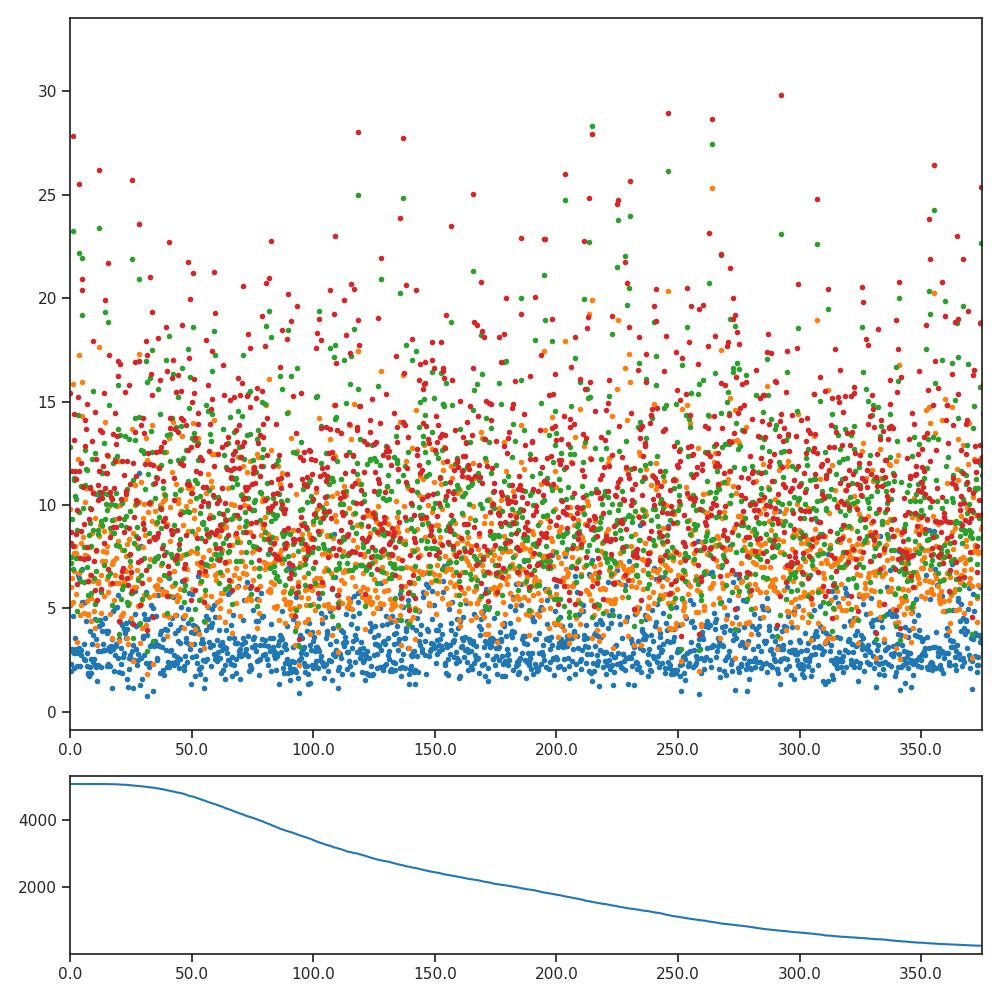

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



# convert numpy arrays to pandas dataframe
df_mean = pd.DataFrame(means, columns=[ 't+4', 't+12', 't+20', 't+28'])
df_std = pd.DataFrame(stds, columns=[ 't+4', 't+12', 't+20', 't+28'])

df_counts = pd.DataFrame(count, columns=['t+0', 't+4', 't+12', 't+20', 't+28'])



# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})


# Plot the average dataframe with error bars
# for column in df_mean.columns:
#     axs[0].errorbar(df_mean.index, df_mean[column], yerr=df_std[column], fmt='-o', label=column)
axs[0].scatter(df_mean.index,df_mean['t+4'], marker=".")
axs[0].scatter(df_mean.index,df_mean['t+12'], marker=".")
axs[0].scatter(df_mean.index,df_mean['t+20'], marker=".")
axs[0].scatter(df_mean.index,df_mean['t+28'], marker=".")

# Plot the counts dataframe as a bar chart
df_counts['t+0'].plot(ax=axs[1])

axs[0].set_xlim([0, 1500])
axs[1].set_xlim([0, 1500])

# Change x-axis labels for both subplots
for ax in axs:
    labels = ax.get_xticks()
    ax.set_xticklabels(labels / 4)

# Set tight layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_1028369/1668460199.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels / 4.)


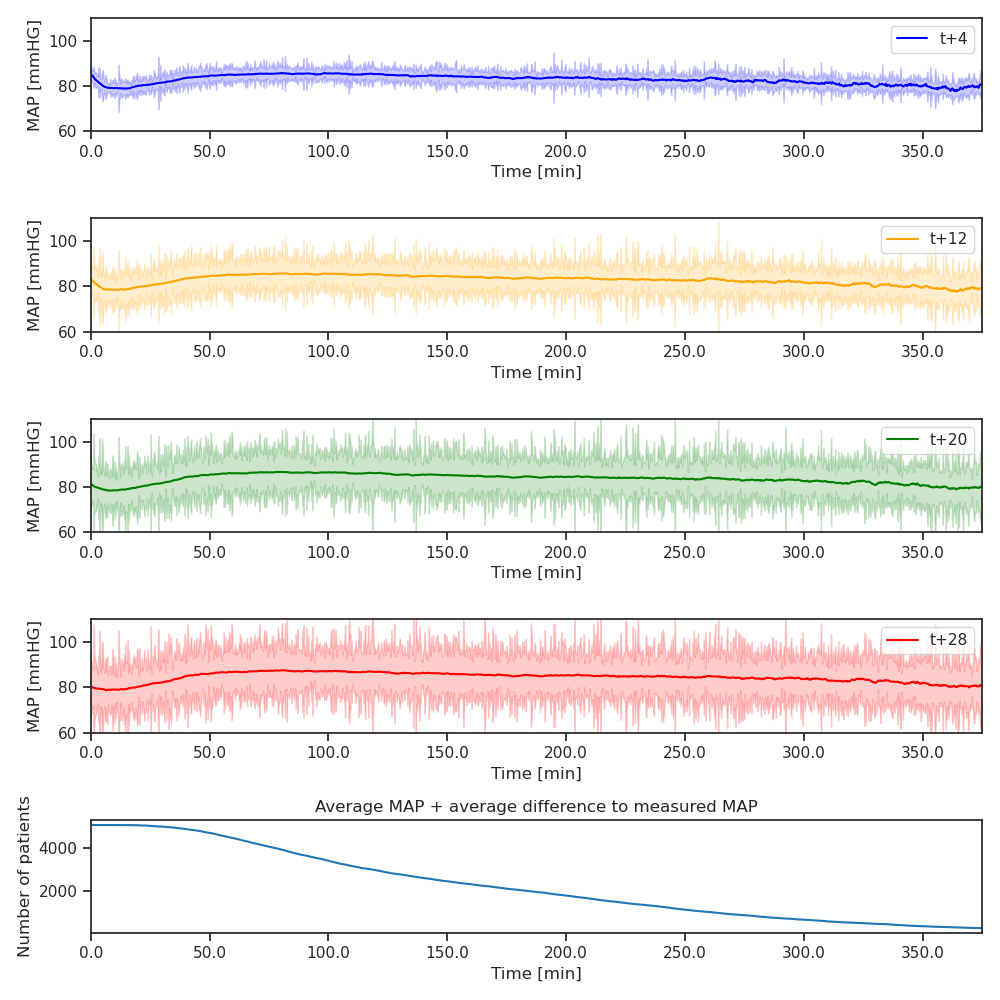

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np





# convert numpy arrays to pandas dataframe
df_mean = pd.DataFrame(means, columns=[ 't+4', 't+12', 't+20', 't+28'])
df_std = pd.DataFrame(stds, columns=[ 't+4', 't+12', 't+20', 't+28'])

df_counts = pd.DataFrame(count, columns=['t+0', 't+4', 't+12', 't+20', 't+28'])

colors = ['blue','orange','green','red']

average_mean = average/count


# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

# Calculate the rolling mean with a window of 10
df_mean_smoothed = df_mean.rolling(window=1).mean()
df_std_smoothed = df_std.rolling(window=1).mean()

plt.title('Average MAP + average difference to measured MAP')


# Plot the smoothed mean dataframe as lines
for i, column in enumerate(df_mean_smoothed.columns):
    axs[i].plot(range(average_mean.shape[0]), average_mean[:,i], label=column, color = colors[i])
    axs[i].fill_between(range(average_mean.shape[0]), average_mean[:,i] - df_mean_smoothed[column].iloc[:1500], average_mean[:,i] + df_mean_smoothed[column].iloc[:1500], color = colors[i],  alpha=0.2)
    axs[i].set_ylim([60, 110])    
    axs[i].set_xlim([0, 1500])
    axs[i].set_ylabel("MAP [mmHG]")
    axs[i].set_xlabel("Time [min]")# Plot the counts dataframe as a bar chart
    axs[i].legend()


df_counts['t+0'].plot(ax=axs[4])


axs[4].set_xlim([0, 1500])
axs[4].set_xlabel("Time [min]")
axs[4].set_ylabel("Number of patients")
# Change x-axis labels for both subplots
for ax in axs:
    labels = ax.get_xticks()
    ax.set_xticklabels(labels / 4.)

# Set tight layout

plt.tight_layout()
plt.savefig('Meanbp_all_patients_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

In [73]:
all

['rand_id',
 'case_time',
 'age',
 'gender',
 'asa_score',
 'urgency',
 'surgery_type',
 'hf',
 'pulse',
 'spo2',
 'etco2',
 'systolicbp',
 'diastolicbp',
 'meanbp',
 'invasivebp',
 'insevo',
 'exsevo',
 'indes',
 'exdes',
 'berodual',
 'cisatracurium',
 'esketamin',
 'etomidat',
 'fentanyl',
 'midazolam',
 'noradrenalin',
 'phenylephrin',
 'piritramid',
 'propofol',
 'remifentanil',
 'rocuronium',
 'succinylcholin',
 'sufentanil',
 'compliance',
 'fio2',
 'peep',
 'plateau',
 'pmax',
 'ppeak',
 'pmean',
 'resistance',
 'ventfreq',
 'ventmode',
 'vt',
 'dobutamin_perfusor',
 'epinephrin_perfusor',
 'levosimendan_perfusor',
 'noradrenalin_perfusor',
 'phenylephrin_perfusor',
 'propofol_perfusor',
 'remifentanil_perfusor',
 'sufentanil_perfusor',
 'vasopressin_perfusor',
 'phase',
 'hypotension60',
 'hypotension65',
 'hypoxemia']

/tmp/ipykernel_1028369/3321225336.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3321225336.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3321225336.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))


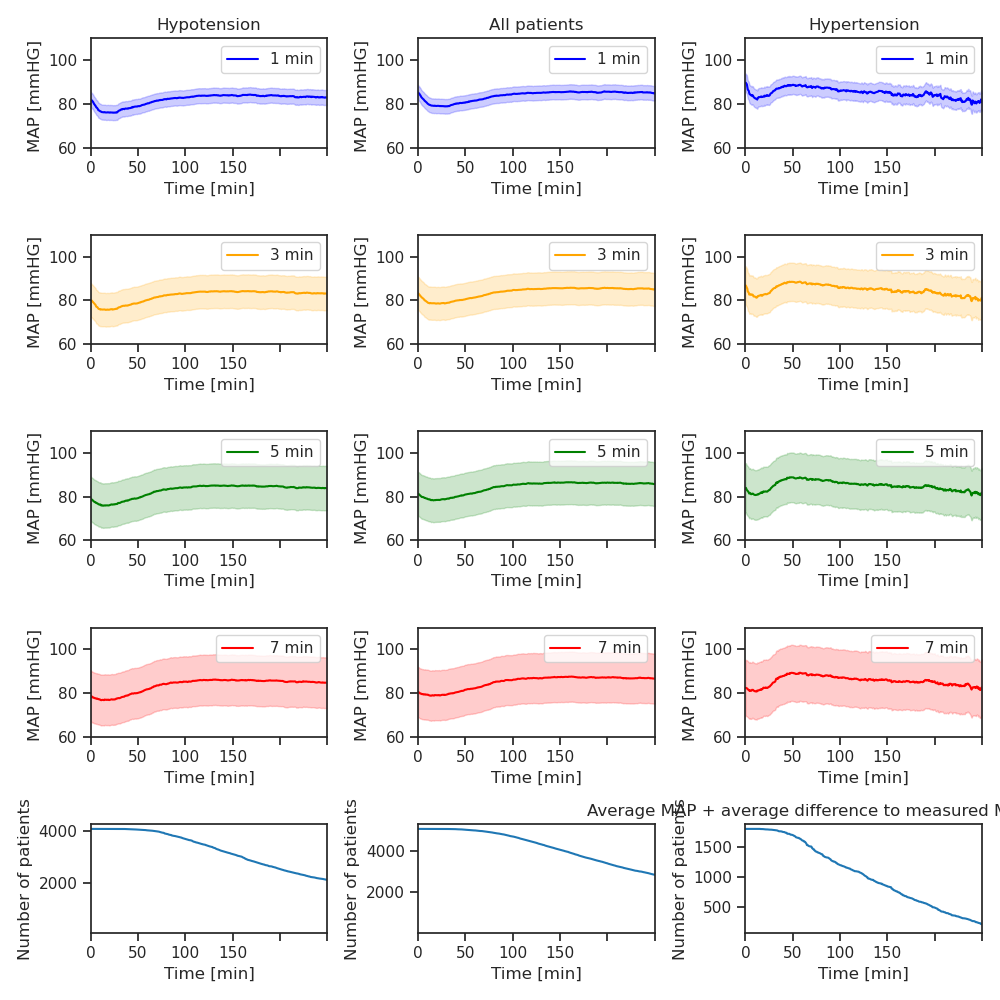

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


all = np.ones((len(indices), 1)) 
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
cohorts = [hypotension.flatten().astype(int).astype(bool), all.flatten().astype(int).astype(bool), hypertension.flatten().astype(int).astype(bool)]
cohorts_names = ['Hypotension', 'All patients', 'Hypertension']
average_cohort = [average_hypotension, average, average_hypertension]
counts_cohort = [count_hypotension, count, count_hypertension]

plt.title('Average MAP + average difference to measured MAP (all patients)')

for ind, cohort in enumerate(cohorts):

    #cohort = cohort[:6000]


    cohort_mean = means[cohort]

    cohort_std = stds[cohort]

    cohort_count = counts_cohort[ind][cohort[:1500]]
    average_co = average_cohort[ind][cohort[:1500]]
    
    # convert numpy arrays to pandas dataframe
    df_mean = pd.DataFrame(cohort_mean, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_std = pd.DataFrame(cohort_std, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_counts = pd.DataFrame(cohort_count, columns=['0 min', '1 min', '3 min', '5 min', ' 7 min'])
    
    colors = ['blue','orange','green','red']
    

    cohort_average_mean = average_co/cohort_count  
    
    
    # Calculate the rolling mean with a window of 10
    df_mean_smoothed = df_mean.mean(axis=0)
    df_std_smoothed = df_std.mean(axis=0)
    

    # Plot the smoothed mean dataframe as lines
    for i, column in enumerate(df_mean.columns):
        axs[i,ind].plot(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i], label=column, color = colors[i])
        axs[i,ind].fill_between(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i] - df_mean_smoothed[i], cohort_average_mean[:,i] + df_mean_smoothed[i], color = colors[i],  alpha=0.2)
        axs[i,ind].set_ylim([60, 110])    
        axs[i,ind].set_xlim([0, 500])
        axs[i,ind].set_ylabel("MAP [mmHG] ")
        axs[i,ind].set_xlabel("Time [min]")# Plot the counts dataframe as a bar chart
        axs[i,ind].legend()
    
    df_counts['0 min'].plot(ax=axs[4, ind])
    
    
    axs[4, ind].set_xlim([0, 500])
    axs[4, ind].set_xlabel("Time [min]")
    axs[4, ind].set_ylabel("Number of patients")


    axs[0, ind].set_title(cohorts_names[ind])

    # Change x-axis labels for both subplots
    for ax in axs:
        labels = ax[ind].get_xticks()
        ax[ind].set_xticklabels((labels / 4).astype(int))
    
    # Set tight layout

plt.tight_layout()
plt.savefig('Meanbp_all_patients_cohorts_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

/tmp/ipykernel_1028369/3196476117.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3196476117.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3196476117.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))


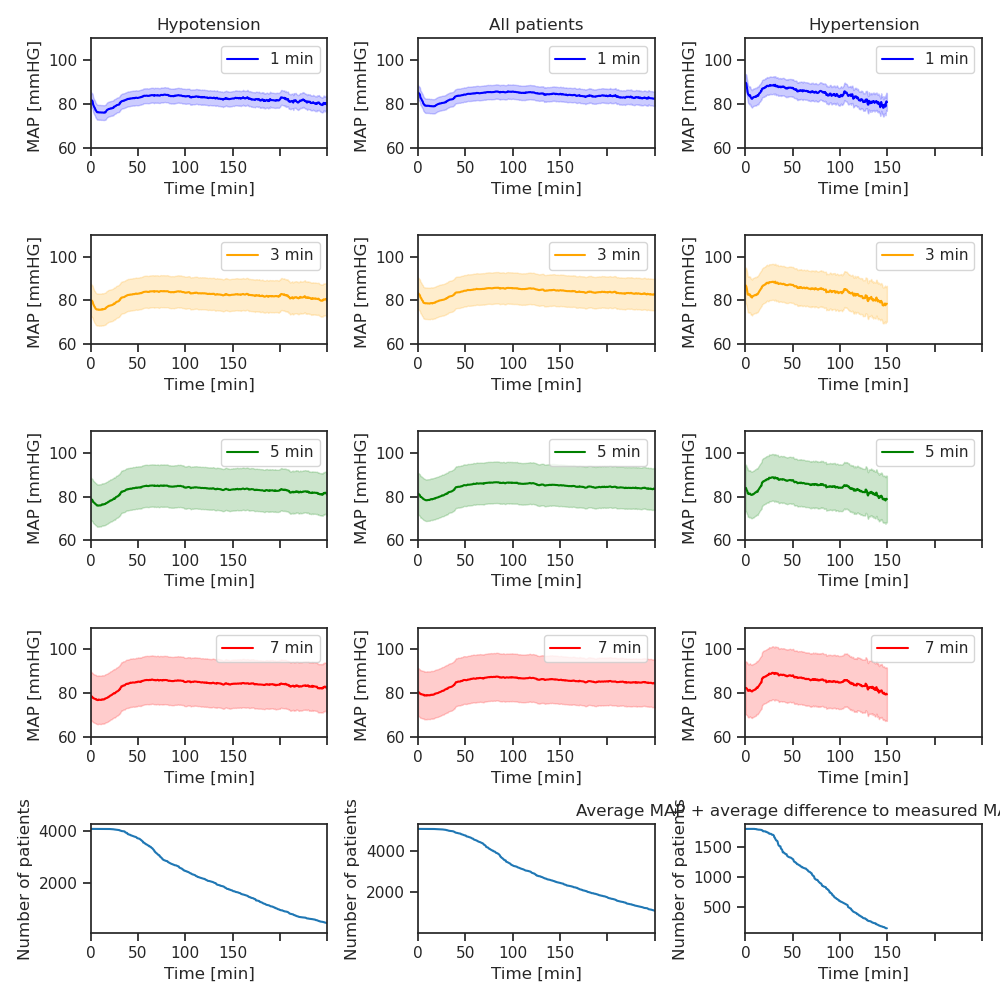

In [75]:

#MALE


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


all = np.ones((len(indices), 1)) 
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
cohorts = [hypotension.flatten().astype(int).astype(bool), all.flatten().astype(int).astype(bool), hypertension.flatten().astype(int).astype(bool)]
cohorts_names = ['Hypotension', 'All patients', 'Hypertension']
average_cohort = [average_hypotension, average, average_hypertension]
counts_cohort = [count_hypotension, count, count_hypertension]
plt.title('Average MAP + average difference to measured MAP (male patients)')

for ind, cohort in enumerate(cohorts):


    cohort = cohort & male.flatten().astype(int).astype(bool)




    cohort_mean = means[cohort]

    cohort_std = stds[cohort]

    cohort_count = counts_cohort[ind][cohort[:1500]]
    average_co = average_cohort[ind][cohort[:1500]]
    
    # convert numpy arrays to pandas dataframe
    df_mean = pd.DataFrame(cohort_mean, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_std = pd.DataFrame(cohort_std, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_counts = pd.DataFrame(cohort_count, columns=['0 min', '1 min', '3 min', '5 min', ' 7 min'])
    
    colors = ['blue','orange','green','red']
    

    cohort_average_mean = average_co/cohort_count  
    
    
    # Calculate the rolling mean with a window of 10
    df_mean_smoothed = df_mean.mean(axis=0)
    df_std_smoothed = df_std.mean(axis=0)
    

    # Plot the smoothed mean dataframe as lines
    for i, column in enumerate(df_mean.columns):
        axs[i,ind].plot(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i], label=column, color = colors[i])
        axs[i,ind].fill_between(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i] - df_mean_smoothed[i], cohort_average_mean[:,i] + df_mean_smoothed[i], color = colors[i],  alpha=0.2)
        axs[i,ind].set_ylim([60, 110])    
        axs[i,ind].set_xlim([0, 500])
        axs[i,ind].set_ylabel("MAP [mmHG] ")
        axs[i,ind].set_xlabel("Time [min]")# Plot the counts dataframe as a bar chart
        axs[i,ind].legend()
    
    df_counts['0 min'].plot(ax=axs[4, ind])
    
    
    axs[4, ind].set_xlim([0, 500])
    axs[4, ind].set_xlabel("Time [min]")
    axs[4, ind].set_ylabel("Number of patients")


    axs[0, ind].set_title(cohorts_names[ind])

    # Change x-axis labels for both subplots
    for ax in axs:
        labels = ax[ind].get_xticks()
        ax[ind].set_xticklabels((labels / 4).astype(int))
    
    # Set tight layout

plt.tight_layout()
plt.savefig('Meanbp_male_cohorts_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

/tmp/ipykernel_1028369/3798069765.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3798069765.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))
/tmp/ipykernel_1028369/3798069765.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels((labels / 4).astype(int))


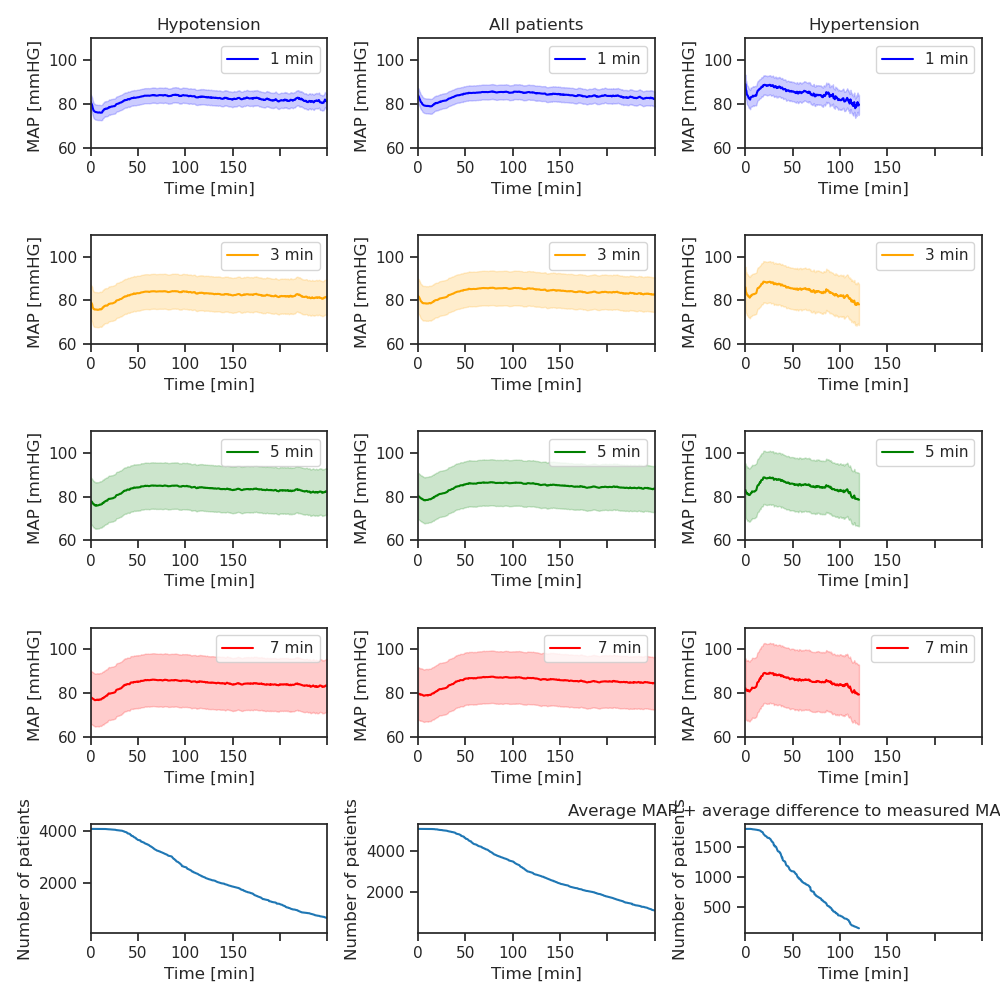

In [76]:

#FEMALE


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


all = np.ones((len(indices), 1)) 
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
cohorts = [hypotension.flatten().astype(int).astype(bool), all.flatten().astype(int).astype(bool), hypertension.flatten().astype(int).astype(bool)]
cohorts_names = ['Hypotension', 'All patients', 'Hypertension']
average_cohort = [average_hypotension, average, average_hypertension]
counts_cohort = [count_hypotension, count, count_hypertension]
plt.title('Average MAP + average difference to measured MAP (female patients)')

for ind, cohort in enumerate(cohorts):


    cohort = cohort & female.flatten().astype(int).astype(bool)

    cohort_mean = means[cohort]

    cohort_std = stds[cohort]

    cohort_count = counts_cohort[ind][cohort[:1500]]
    average_co = average_cohort[ind][cohort[:1500]]
    
    # convert numpy arrays to pandas dataframe
    df_mean = pd.DataFrame(cohort_mean, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_std = pd.DataFrame(cohort_std, columns=[ '1 min', '3 min', '5 min', ' 7 min'])
    df_counts = pd.DataFrame(cohort_count, columns=['0 min', '1 min', '3 min', '5 min', ' 7 min'])
    
    colors = ['blue','orange','green','red']
    

    cohort_average_mean = average_co/cohort_count  
    
    
    # Calculate the rolling mean with a window of 10
    df_mean_smoothed = df_mean.mean(axis=0)
    df_std_smoothed = df_std.mean(axis=0)
    

    # Plot the smoothed mean dataframe as lines
    for i, column in enumerate(df_mean.columns):
        axs[i,ind].plot(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i], label=column, color = colors[i])
        axs[i,ind].fill_between(range(cohort_average_mean.shape[0]), cohort_average_mean[:,i] - df_mean_smoothed[i], cohort_average_mean[:,i] + df_mean_smoothed[i], color = colors[i],  alpha=0.2)
        axs[i,ind].set_ylim([60, 110])    
        axs[i,ind].set_xlim([0, 500])
        axs[i,ind].set_ylabel("MAP [mmHG] ")
        axs[i,ind].set_xlabel("Time [min]")# Plot the counts dataframe as a bar chart
        axs[i,ind].legend()
    
    df_counts['0 min'].plot(ax=axs[4, ind])
    
    
    axs[4, ind].set_xlim([0, 500])
    axs[4, ind].set_xlabel("Time [min]")
    axs[4, ind].set_ylabel("Number of patients")


    axs[0, ind].set_title(cohorts_names[ind])

    # Change x-axis labels for both subplots
    for ax in axs:
        labels = ax[ind].get_xticks()
        ax[ind].set_xticklabels((labels / 4).astype(int))
    
    # Set tight layout

plt.tight_layout()
plt.savefig('Meanbp_female_cohorts_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

In [77]:
count_hypertension

array([[1790., 1790., 1790., 1790., 1790.],
       [1790., 1790., 1790., 1790., 1790.],
       [1790., 1790., 1790., 1790., 1790.],
       ...,
       [ 158.,  158.,  158.,  158.,  158.],
       [ 158.,  158.,  158.,  158.,  158.],
       [ 157.,  157.,  157.,  157.,  157.]])

/tmp/ipykernel_1028369/621889120.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels / 4)


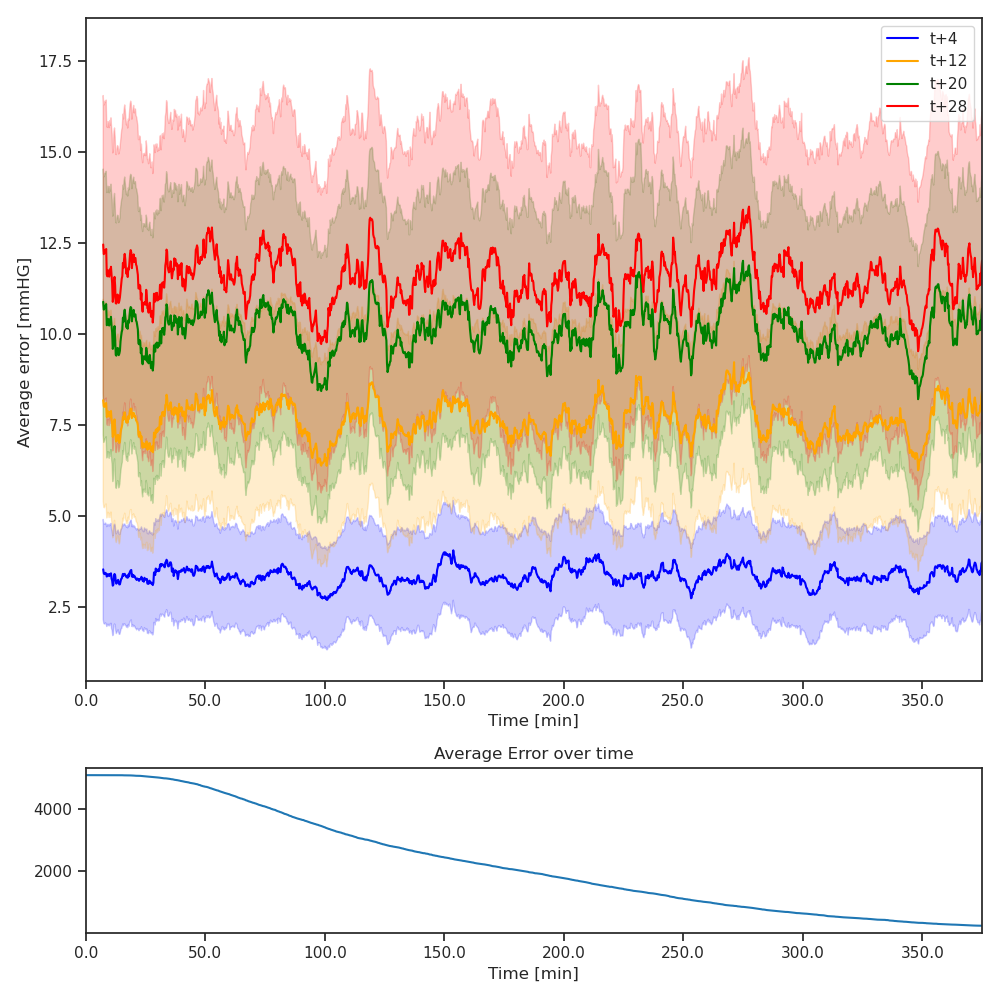

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

std_plot = np.std(means, axis=0)

# convert numpy arrays to pandas dataframe
df_mean = pd.DataFrame(means, columns=[ 't+4', 't+12', 't+20', 't+28'])
df_std = pd.DataFrame(stds, columns=[ 't+4', 't+12', 't+20', 't+28'])

df_counts = pd.DataFrame(count, columns=['t+0', 't+4', 't+12', 't+20', 't+28'])

colors = ['blue','orange','green','red']


# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})

# Calculate the rolling mean with a window of 10
df_mean_smoothed = df_mean.rolling(window=30).mean()
df_std_smoothed = df_std.rolling(window=30).mean()

plt.title('Average Error over time')


# Plot the smoothed mean dataframe as lines
for i, column in enumerate(df_mean_smoothed.columns):
    axs[0].plot(df_mean_smoothed.index, df_mean_smoothed[column], label=column, color = colors[i])
    axs[0].fill_between(df_std.index, df_mean_smoothed[column] - std_plot[i], df_mean_smoothed[column] + std_plot[i], color = colors[i],  alpha=0.2) 
    axs[0].legend()

axs[0].set_ylabel("Average error [mmHG] ")
axs[0].set_xlabel("Time [min]")
# Plot the counts dataframe as a bar chart
df_counts['t+0'].plot(ax=axs[1])

axs[0].set_xlim([0, 1500])
axs[1].set_xlim([0, 1500])
axs[1].set_xlabel("Time [min]")
# Change x-axis labels for both subplots
for ax in axs:
    labels = ax.get_xticks()
    ax.set_xticklabels(labels / 4)

# Set tight layout

plt.tight_layout()
plt.savefig('Average_error_'+str(prediction_time/4.)+'_isextern_'+str(kor)+'.png')
plt.show()

In [79]:
pred_col_names = []
for i in range(window_length):
    pred_col_names.append('t+'+str(i))

In [80]:
targets = raw_pat['meanbp']

In [81]:
targets

0          83
1          74
2          74
3          75
4          76
         ... 
676219    118
676220    117
676221    117
676222    116
676223    115
Name: meanbp, Length: 676224, dtype: int64

In [82]:
output_map = model.predict(df_pat)

In [83]:
predict_p50 = data_formatter.format_predictions(output_map["p50"])

In [84]:
predict_p50 = predict_p50[pred_col_names]

In [85]:
len_pred = len(predict_p50.iloc[0])

In [86]:
len_pred

30

In [87]:
predict_p50

t+0        t+1        t+2        t+3        t+4        t+5  \
0    86.636589  87.371758  87.846024  88.264046  88.392395  88.341721   
1    84.398224  86.872360  88.063263  88.648445  88.915123  89.059303   
2    86.887184  86.932991  87.185783  87.262825  87.429733  87.703377   
3    85.999481  86.439911  86.308868  86.294357  86.475975  86.838768   
4    88.494972  88.985207  89.590103  89.918671  90.195145  90.443619   
..         ...        ...        ...        ...        ...        ...   
580  96.026848  97.047653  97.679878  98.104958  98.470573  99.121788   
581  94.415977  95.031334  96.130547  96.833275  97.453918  98.087288   
582  93.186317  94.154434  95.070992  95.717590  96.430138  97.169876   
583  94.255264  94.850395  95.414841  95.735565  96.414276  97.208847   
584  92.189857  93.068909  93.897552  94.653931  95.422066  96.246239   

           t+6         t+7         t+8         t+9        t+10        t+11  \
0    88.233757   88.147926   88.072906   87.963516   87.849136   87.729424   
1    89.227188   89.436752   89.668900   89.947502   90.282143   90.609901   
2    88.083939   88.491631   88.902321   89.306305   89.699615   90.068176   
3    87.240135   87.598396   87.921448   88.225555   88.513000   88.781876   
4    90.682060   90.938133   91.217590   91.517891   91.815750   92.090492   
..         ...         ...         ...         ...         ...         ...   
580  99.881004  100.695816  101.538589  102.397400  103.233253  104.029602   
581  98.809311   99.609756  100.471634  101.387047  102.334473  103.300858   
582  98.008682   98.927971   99.910782  100.936478  102.002419  103.084221   
583  98.108871   99.090271  100.147499  101.265930  102.428780  103.568497   
584  97.164719   98.171120   99.233696  100.390999  101.660461  102.956116   

           t+12        t+13        t+14        t+15        t+16        t+17  \
0     87.616241   87.499779   87.381836   87.265129   87.160187   87.051491   
1     90.896324   91.126160   91.237259   91.304733   91.319870   91.287125   
2     90.380272   90.645142   90.867279   91.067780   91.254005   91.412666   
3     89.012108   89.217407   89.405525   89.629829   89.827087   90.018852   
4     92.352867   92.594315   92.891136   93.170410   93.441391   93.701546   
..          ...         ...         ...         ...         ...         ...   
580  104.780937  105.487564  106.183868  106.865852  107.523720  108.162163   
581  104.230759  105.056770  105.806633  106.544273  107.276024  107.991638   
582  104.119308  105.112869  106.081032  106.961357  107.769920  108.595551   
583  104.657425  105.725647  106.703194  107.626129  108.541763  109.410179   
584  104.204033  105.393707  106.531372  107.619682  108.606293  109.501884   

           t+18        t+19        t+20        t+21        t+22        t+23  \
0     86.883415   86.662697   86.414993   86.146263   85.861320   85.563385   
1     91.206367   91.087418   90.943466   90.772583   90.582794   90.371170   
2     91.556473   91.681732   91.779610   91.846138   91.879112   91.884789   
3     90.195908   90.353149   90.490784   90.604568   90.694031   90.758522   
4     93.949760   94.187889   94.413269   94.617073   94.797081   94.949570   
..          ...         ...         ...         ...         ...         ...   
580  108.783302  109.386223  109.969772  110.535217  111.084007  111.619316   
581  108.672852  109.301491  109.892357  110.484451  111.071411  111.646759   
582  109.417999  110.212906  110.967644  111.663574  112.281601  112.814522   
583  110.181053  110.882835  111.547165  112.168533  112.748192  113.278778   
584  110.371674  111.178940  111.917160  112.588623  113.195999  113.752808   

           t+24        t+25        t+26        t+27        t+28        t+29  
0     85.254715   84.939949   84.624535   84.309402   83.997719   83.693642  
1     90.143333   89.896790   89.639252   89.372200   89.091736   88.800552  
2     91.855057   91.800339   91.710411   91.594749   91.457893  

In [88]:
targets[len(raw_pat)+window_length-1:(len(raw_pat)+len_pred+window_length-1)]

Series([], Name: meanbp, dtype: int64)

In [89]:
raw_pat

rand_id  case_time  age  gender  asa_score  urgency  surgery_type  \
0             1        452   77       1          2        1             0   
1             1        467   77       1          2        1             0   
2             1        482   77       1          2        1             0   
3             1        497   77       1          2        1             0   
4             1        512   77       1          2        1             0   
...         ...        ...  ...     ...        ...      ...           ...   
676219     1252       6361   74       1          2        1             0   
676220     1252       6376   74       1          2        1             0   
676221     1252       6391   74       1          2        1             0   
676222     1252       6406   74       1          2        1             0   
676223     1252       6421   74       1          2        1             0   

          hf  pulse   spo2  etco2  systolicbp  diastolicbp  meanbp  \
0       73.0   74.0  100.0   11.0       172.0         85.0      83   
1       73.0   74.0  100.0    8.0       125.0         60.0      74   
2       73.0   73.0  100.0   28.0       125.0         60.0      74   
3       73.0   74.0  100.0   17.0       125.0         60.0      75   
4       74.0   74.0  100.0    5.0       125.0         60.0      76   
...      ...    ...    ...    ...         ...          ...     ...   
676219   0.0  186.0   88.0    0.0         0.0          0.0     118   
676220   0.0    0.0    0.0    0.0         0.0          0.0     117   
676221   0.0    0.0    0.0    0.0         0.0          0.0     117   
676222   0.0    0.0    0.0    0.0         0.0          0.0     116   
676223   0.0    0.0    0.0    0.0         0.0          0.0     115   

        invasivebp  insevo  exsevo  indes  exdes  berodual  cisatracurium  \
0                0     3.0     2.0    0.0    0.0         0            0.0   
1                0     3.0     3.0    0.0    0.0         0            0.0   
2                0     3.0     2.0    0.0    0.0         0            0.0   
3                0     3.0     3.0    0.0    0.0         0            0.0   
4                0     3.0     3.0    0.0    0.0         0            0.0   
...            ...     ...     ...    ...    ...       ...            ...   
676219           0     0.0     0.0    0.0    0.0         0            0.0   
676220           0     0.0     0.0    0.0    0.0         0            0.0   
676221           0     0.0     0.0    0.0    0.0         0            0.0   
676222           0     0.0     0.0    0.0    0.0         0            0.0   
676223           0     0.0     0.0    0.0    0.0         0            0.0   

        esketamin  etomidat  fentanyl  midazolam  noradrenalin  phenylephrin  \
0             0.0         0       0.0        0.0             0           0.0   
1             0.0         0       0.0        0.0             0           0.0   
2             0.0         0       0.0        0.0             0           0.0   
3             0.0         0       0.0        0.0             0           0.0   
4             0.0         0       0.0        0.0             0           0.0   
...           ...       ...       ...        ...           ...           ...   
676219        0.0         0       0.0        0.0             0           0.0   
676220        0.0         0       0.0        0.0             0           0.0   
676221        0.0         0       0.0        0.0             0           0.0   
676222        0.0         0       0.0        0.0             0           0.0   
676223        0.0         0       0.0        0.0             0           0.0   

        piritramid  propofol  remifentanil  rocuronium  succinylcholin  \
0              0.0       0.0             0         0.0               0   
1              0.0       0.0             0         0.0               0   
2              0.0       0.0             0         0.0               0   
3              0.0       0.0             0         0.0      

In [90]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [91]:
print(hist_length)

32


In [92]:
len(raw_pat)

676224

In [93]:
indices = df['rand_id'].unique()
metrics = []
for index in tqdm(indices):
    
    pat_id = index
    
    df_pat = df[df['rand_id']==pat_id]
    targets = raw_data[raw_data['rand_id']==pat_id]['meanbp']
    if(df_pat.shape[0]>62):
        batch = model._batch_data(df_pat)
        
        inputs = batch['inputs']
        outputs = batch['outputs']
        active_entries = model._get_active_locations(batch['active_entries'])
        
        metric_values = model.model.evaluate(
            x=inputs,
            y=np.concatenate([outputs, outputs, outputs], axis=-1),
            sample_weight=active_entries,
            workers=16,
            use_multiprocessing=True)
        metrics.append(metric_values)


  0%|                                                                                                       | 0/5065 [00:00<?, ?it/s]/home/fs71801/lkapral66/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-01 15:01:18.576239: W tensorflow/c/c_api.cc:300] Operation '{name:'TemporalFusionTransformer/loss/mul' id:19829 op device:{requested: '', assigned: ''} def:{{{node TemporalFusionTransformer/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](TemporalFusionTransformer/loss/mul/x, TemporalFusionTransformer/loss/time_distributed_273_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

In [94]:
import pickle

with open("TFT_stats_"+str(kor), "wb") as fp:   #Pickling
    pickle.dump(metrics, fp)


In [ ]:
metrics

EOFError: Ran out of input

In [41]:
with open('TFT_stats_True', 'rb') as pickle_file:
    metrics = pickle.load(pickle_file)

In [44]:
np.array(metrics).mean(axis=0)

array([  0.50284091,   1.16476928, 218.37961184,   0.62162385])

In [45]:
metrics

[[0.894644837873779, 3.6515162, 188.38588, 0.9217729],
 [0.3021636622137681, 0.40388453, 255.6411, 0.45208773],
 [0.4302239705776346, 0.8958538, 253.91916, 0.5403922],
 [0.48149359146101073, 1.3121669, 177.10509, 0.60757923],
 [0.5117682874852961, 1.4238921, 241.18657, 0.5789626],
 [1.2274758494492117, 3.2423441, 247.36165, 1.234897],
 [0.3732191238574639, 0.68105555, 128.09152, 0.5703662],
 [0.4345139678285903, 0.47484928, 161.95744, 0.5134455],
 [0.5608400200800365, 1.3734123, 267.60544, 0.6927906],
 [0.45684178039945406, 0.69100904, 243.69502, 0.6163555],
 [0.49313470939598464, 1.2386993, 123.407, 0.56222713],
 [0.35244677688034487, 0.3941342, 238.70674, 0.4263687],
 [0.2901109167606155, 0.4321733, 59.611923, 0.42305472],
 [0.9420115065245587, 3.1818166, 235.93956, 0.92808557],
 [0.5170601844419952, 0.9320096, 210.53056, 0.6529053],
 [1.0257201174385526, 2.4582598, 208.78246, 1.0737443],
 [0.3701374309916274, 0.75039715, 109.980354, 0.47912046],
 [0.4675531260378949, 0.83417875, 158

In [30]:
df_kor = raw_data

In [31]:
df_kor.describe()

rand_id     case_time           age        gender     asa_score  \
count  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07   
mean   5.014284e+07  6.421595e+03  5.377505e+01  4.782015e-01  2.152121e+00   
std    2.893967e+07  6.828665e+03  1.778762e+01  4.995246e-01  8.332444e-01   
min    1.439000e+03 -7.348500e+04  1.800000e+01  0.000000e+00  1.000000e+00   
25%    2.506324e+07  2.235000e+03  4.000000e+01  0.000000e+00  2.000000e+00   
50%    5.034542e+07  4.560000e+03  5.500000e+01  0.000000e+00  2.000000e+00   
75%    7.517817e+07  8.445000e+03  6.800000e+01  1.000000e+00  3.000000e+00   
max    9.999997e+07  1.223130e+06  1.060000e+02  1.000000e+00  5.000000e+00   

            urgency  surgery_type            hf         pulse          spo2  \
count  4.060331e+07  4.060331e+07  4.051109e+07  4.059040e+07  4.060331e+07   
mean   1.218950e+00  4.729417e+00  6.798451e+01  6.681433e+01  9.862025e+01   
std    4.977292e-01  3.566957e+00  1.666550e+01  1.506371e+01  1.874931e+00   
min    1.000000e+00  0.000000e+00  0.000000e+00  2.700000e+01  0.000000e+00   
25%    1.000000e+00  0.000000e+00  5.700000e+01  5.600000e+01  9.800000e+01   
50%    1.000000e+00  5.000000e+00  6.500000e+01  6.400000e+01  9.900000e+01   
75%    1.000000e+00  8.000000e+00  7.600000e+01  7.500000e+01  1.000000e+02   
max    3.000000e+00  1.700000e+01  3.000000e+02  2.500000e+02  1.000000e+02   

              etco2    systolicbp   diastolicbp        meanbp    invasivebp  \
count  3.158692e+07  4.059555e+07  4.059584e+07  4.060331e+07  4.060331e+07   
mean   3.472264e+01  1.111774e+02  6.115387e+01  8.070098e+01  3.411114e-01   
std    9.112450e+00  2.261857e+01  1.491395e+01  1.717815e+01  4.740827e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.400000e+01  9.600000e+01  5.200000e+01  7.000000e+01  0.000000e+00   
50%    3.600000e+01  1.070000e+02  5.900000e+01  7.800000e+01  0.000000e+00   
75%    3.900000e+01  1.220000e+02  6.800000e+01  8.800000e+01  1.000000e+00   
max    9.900000e+01  4.900000e+02  3.000000e+02  3.000000e+02  1.000000e+00   

             insevo        exsevo         indes         exdes      berodual  \
count  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07   
mean   9.407767e-01  8.187473e-01  8.805388e-02  8.051019e-02  2.068797e-04   
std    9.891449e-01  8.403554e-01  6.964031e-01  6.311693e-01  2.752238e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    7.000000e-01  6.000000e-01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    1.900000e+00  1.600000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.200000e+01  1.220000e+01  1.280000e+01  2.630000e+01  3.000000e+01   

       cisatracurium     esketamin      etomidat      fentanyl     midazolam  \
count   4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07   
mean    1.618538e-04  4.883567e-03  7.620068e-04  5.242870e-01  5.576639e-04   
std     5.689091e-02  4.293539e-01  1.261571e-01  9.252973e+00  1.213073e-01   
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max     2.000000e+02  3.500000e+02  1.500000e+02  1.000000e+03  2.500000e+02   

       noradrenalin  phenylephrin    piritramid      propofol  remifentanil  \
count  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07  4.060331e+07   
mean   7.532637e-04  3.002176e-04  1.349003e-03  3.260159e-01  4.950335e-04   
std    1.210925e+00  9.501331e-03  9.190903e-02  7.639503e+00  2.742698e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00 

In [32]:
len(df_kor['rand_id'].unique())

81122

In [51]:
df_kor['rand_id'].unique()

array([   1,    2,    3, ..., 6386, 6387, 6388])

In [33]:
df_kor['gender'].value_counts()

gender
0    21186748
1    19416562
Name: count, dtype: int64

In [35]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'rand_id' is the column to group by
grouped_means = df_kor.groupby('rand_id').mean(numeric_only=True)



# Performing value_counts on the flattened series
value_counts = grouped_means.value_counts()


In [44]:
grouped_means['gender'].value_counts()

gender
0.0    45392
1.0    35730
Name: count, dtype: int64

In [45]:
grouped_means['gender'].value_counts()/ 81122

gender
0.0    0.559552
1.0    0.440448
Name: count, dtype: float64

In [38]:
grouped_means.describe()

case_time           age        gender     asa_score       urgency  \
count   81122.000000  81122.000000  81122.000000  81122.000000  81122.000000   
mean     4137.300504     52.174552      0.440448      2.058800      1.243165   
std      3387.489753     18.223427      0.496444      0.835354      0.518958   
min     -7802.363344     18.000000      0.000000      1.000000      1.000000   
25%      2125.453937     37.000000      0.000000      1.000000      1.000000   
50%      3315.000000     53.000000      0.000000      2.000000      1.000000   
75%      5113.691542     67.000000      1.000000      3.000000      1.000000   
max    345608.585526    106.000000      1.000000      5.000000      3.000000   

       surgery_type            hf         pulse          spo2         etco2  \
count  81122.000000  81112.000000  81112.000000  81122.000000  65122.000000   
mean       4.584909     68.354868     67.277194     98.563458     33.074663   
std        3.516303     13.307678     13.159225      1.309580      6.624457   
min        0.000000     36.545455     33.362132     44.122388      0.000000   
25%        0.000000     58.981944     58.034175     97.888298     31.939139   
50%        5.000000     65.655256     64.532604     98.806630     34.518060   
75%        8.000000     75.071218     73.850944     99.544725     36.490858   
max       17.000000    149.622951    149.786885    100.000000     67.274929   

         systolicbp   diastolicbp        meanbp    invasivebp        insevo  \
count  81122.000000  81122.000000  81122.000000  81122.000000  81122.000000   
mean     111.538158     62.057555     81.991601      0.184387      0.841502   
std       15.307000      9.807359     11.203696      0.366026      0.779006   
min       19.018676     13.301969     19.040449      0.000000      0.000000   
25%      100.894488     55.354760     74.349534      0.000000      0.000000   
50%      109.105168     61.060958     80.188452      0.000000      0.961927   
75%      119.386304     67.586284     87.621653      0.000000      1.541890   
max      261.849505    140.250000    166.613260      1.000000      3.482333   

             exsevo         indes         exdes      berodual  cisatracurium  \
count  81122.000000  81122.000000  81122.000000  81122.000000   81122.000000   
mean       0.723014      0.086987      0.078852      0.000226       0.000129   
std        0.674161      0.628499      0.570777      0.001713       0.002192   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000      0.000000       0.000000   
50%        0.811233      0.000000      0.000000      0.000000       0.000000   
75%        1.324507      0.000000      0.000000      0.000000       0.000000   
max        3.029206      8.073945      7.204325      0.055249       0.231481   

          esketamin      etomidat      fentanyl     midazolam  noradrenalin  \
count  81122.000000  81122.000000  81122.000000  81122.000000  81122.000000   
mean       0.005015      0.000944      0.586150      0.000694      0.000696   
std        0.027200      0.008579      0.555386      0.006505      0.131716   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.539811      0.000000      0.000000   
75%        0.000000      0.000000      0.943396      0.000000      0.000000   
max        2.032520      0.591716     10.294118      0.851695     37.366548   

       phenylephrin    piritramid      propofol  remifentanil    rocuronium  \
count  81122.000000  81122.000000  81122.000000  81122.000000  81122.000000   
mean       0.000351      0.001402      0.474841      0.000609      0.068312   
std        0.000873      0.005240      0.522615      0.019062      0.092414   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000     

In [46]:
grouped_max = df_kor.groupby('rand_id')['case_time'].max()



In [47]:
grouped_max.describe()

count    8.112200e+04
mean     7.919639e+03
std      7.571808e+03
min      4.200000e+02
25%      3.945000e+03
50%      6.270000e+03
75%      9.795000e+03
max      1.223130e+06
Name: case_time, dtype: float64

In [48]:
grouped_max.describe()/60

count     1352.033333
mean       131.993984
std        126.196804
min          7.000000
25%         65.750000
50%        104.500000
75%        163.250000
max      20385.500000
Name: case_time, dtype: float64

In [124]:
maxs.value_counts()

5237     9
6002     8
7712     8
9602     7
6077     7
        ..
25112    1
24693    1
12904    1
12247    1
12015    1
Name: case_time, Length: 4133, dtype: int64

In [50]:
131.993984 - 126.196804

5.7971800000000115